# Study Colors of isolated objects

The goal is to have the correct color distribution

- author : Sylvie Dagoret-Campagne
- creation : 2024-08-01


In [1]:
import os
import astropy.units as u
import numpy as np 
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus


from astropy.stats import SigmaClip

In [2]:
from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit

In [3]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [4]:
def convert_fluxtomagerr(row) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    x= row["apFlux_35_0_instFlux"]
    dx = row["apFlux_35_0_instFluxErr"]
    mag =  -2.50 * np.log10(x) + 31.4
    emag = 2.5/np.log(10)*dx/x
    return mag,emag

In [5]:
def get_df_perband(df):
    dfg = df[df.band == "g"]
    dfr = df[df.band == "r"]
    dfi = df[df.band == "i"]
    dfz = df[df.band == "z"]
    dfy = df[df.band == "y"]
    return (dfg,dfr,dfi,dfz,dfy)

In [6]:
def get_df_median(df,ctag="mag"):
    dfg,dfr,dfi,dfz,dfy = get_df_perband(df)
    medg = dfg[ctag].median()
    medr = dfr[ctag].median()
    medi = dfi[ctag].median()
    medz = dfz[ctag].median()
    medy = dfy[ctag].median()
    return (medg,medr,medi,medz,medy)    

In [7]:
def get_df_sigma(df,ctag="mag"):
    dfg,dfr,dfi,dfz,dfy = get_df_perband(df)   
    (medg,medr,medi,medz,medy) = get_df_median(df,ctag)
    
    #dfg["sigma"] = (dfg[tag]- medg)**2
    dfg.loc[:,"sigma"] = dfg.apply( lambda row : (row[ctag]- medg)**2,axis=1,result_type="expand")
    dfr["sigma"] = dfr.apply( lambda row : (row[ctag]- medr)**2,axis=1,result_type="expand")
    if len(dfi)>0:
        flag_dfi = True
        dfi["sigma"] = dfi.apply( lambda row : (row[ctag]- medi)**2,axis=1,result_type="expand")
    else:
        flag_dfi = False
    dfz["sigma"] = dfz.apply( lambda row : (row[ctag]- medz)**2,axis=1,result_type="expand")
    dfy["sigma"] = dfy.apply( lambda row : (row[ctag]- medy)**2,axis=1,result_type="expand")
    
    sigg = np.sqrt(dfg["sigma"].mean())
    sigr = np.sqrt(dfr["sigma"].mean())
    if flag_dfi:
        sigi = np.sqrt(dfi["sigma"].mean())
    else:
        sigi = 0
    sigz = np.sqrt(dfz["sigma"].mean())
    sigy = np.sqrt(dfy["sigma"].mean())
    return (sigg,sigr,sigi,sigz,sigy)

    

In [8]:
def plothistogram_magperband(df):
    objectnum = df["obj_index"].unique()[0]
    dfg,dfr,dfi,dfz,dfy = get_df_perband(df)

    (medg,medr,medi,medz,medy) = get_df_median(df)
    (sigg,sigr,sigi,sigz,sigy) = get_df_sigma(df)
    
    fig,axs = plt.subplots(1,5,figsize=(16,3))
    axes = axs.flatten()
    
    label = f"$\sigma = $ {sigg*1000:.2f} mmag"
    dfg["mag"].plot.hist(ax=axes[0],bins=20,facecolor="g",xlabel="mag")
    axes[0].axvline(medg,color="b",lw=3)
    axes[0].set_title(label)

    label = f"$\sigma = $ {sigr*1000:.2f} mmag"
    dfr["mag"].plot.hist(ax=axes[1],bins=20,facecolor="r",xlabel="mag")
    axes[1].axvline(medr,color="b",lw=3)
    axes[1].set_title(label)

    label = f"$\sigma = $ {sigi*1000:.2f} mmag"
    dfi["mag"].plot.hist(ax=axes[2],bins=20,facecolor="y",xlabel="mag")
    axes[2].axvline(medi,color="b",lw=3)
    axes[2].set_title(label)

    label = f"$\sigma = $ {sigz*1000:.2f} mmag"
    dfz["mag"].plot.hist(ax=axes[3],bins=20,facecolor="grey",xlabel="mag")
    axes[3].axvline(medz,color="b",lw=3)
    axes[3].set_title(label)

    label = f"$\sigma = $ {sigy*1000:.2f} mmag"
    dfy["mag"].plot.hist(ax=axes[4],bins=20,facecolor="k",xlabel="mag")
    axes[4].axvline(medy,color="b",lw=3)
    axes[4].set_title(label)

    title = f"object {objectnum}"
    plt.suptitle(title,fontsize=14,fontweight="bold")
    plt.tight_layout()
    plt.show()
       

In [9]:
def plothistogram_valperband(df,ctag):
    objectnum = df["obj_index"].unique()[0]
    dfg,dfr,dfi,dfz,dfy = get_df_perband(df)

    (medg,medr,medi,medz,medy) = get_df_median(df,ctag)
    (sigg,sigr,sigi,sigz,sigy) = get_df_sigma(df,ctag)
    
    fig,axs = plt.subplots(1,5,figsize=(16,3))
    axes = axs.flatten()
    
    label = f"$\sigma = $ {sigg*1000:.2f} mmag"
    dfg[ctag].plot.hist(ax=axes[0],bins=20,facecolor="g",xlabel="mag")
    axes[0].axvline(medg,color="b",lw=3)
    axes[0].set_title(label)

    label = f"$\sigma = $ {sigr*1000:.2f} mmag"
    dfr[ctag].plot.hist(ax=axes[1],bins=20,facecolor="r",xlabel="mag")
    axes[1].axvline(medr,color="b",lw=3)
    axes[1].set_title(label)

    label = f"$\sigma = $ {sigi*1000:.2f} mmag"
    dfi[ctag].plot.hist(ax=axes[2],bins=20,facecolor="y",xlabel="mag")
    axes[2].axvline(medi,color="b",lw=3)
    axes[2].set_title(label)

    label = f"$\sigma = $ {sigz*1000:.2f} mmag"
    dfz[ctag].plot.hist(ax=axes[3],bins=20,facecolor="grey",xlabel="mag")
    axes[3].axvline(medz,color="b",lw=3)
    axes[3].set_title(label)

    label = f"$\sigma = $ {sigy*1000:.2f} mmag"
    dfy[ctag].plot.hist(ax=axes[4],bins=20,facecolor="k",xlabel="mag")
    axes[4].axvline(medy,color="b",lw=3)
    axes[4].set_title(label)

    title = f"object {objectnum}"
    plt.suptitle(title,fontsize=14,fontweight="bold")
    plt.tight_layout()
    plt.show()
       

## Config

In [10]:
path = "data/photom/sources_objectTable"

## Find input files

In [11]:
list_of_files = os.listdir(path) 
list_of_files = sorted(list_of_files)

In [12]:
tag = "^sources_objectTable-t3864-multibands-o(.*)-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146.csv$"
selected_files = []
selected_objectnum = []
for filename in list_of_files: 
    result = re.findall(tag,filename)
    if len(result)>0:
        num = int(result[0])
        selected_objectnum.append(num)
        selected_files.append(filename) 
        
selected_objectnum = np.array(selected_objectnum)
selected_files = np.array(selected_files)

In [13]:
index_sorted = np.argsort(selected_objectnum)
selected_objectnum = selected_objectnum[index_sorted] 
selected_files = selected_files[index_sorted]
N = len(selected_files)

## Read pandas dataframe

In [14]:
all_df = []
for index,filename in enumerate(selected_files):
    fullfilename = os.path.join(path,filename)
    df = pd.read_csv(fullfilename,index_col=0)
    # calculate the magnitude I want
    df[["mag","emag"]] = df.apply(lambda row : convert_fluxtomagerr(row), axis=1,result_type = 'expand')
    all_df.append(df)

## Study magnitudes

In [15]:
index = 0
objectnum = selected_objectnum[index] 

In [16]:
the_df = all_df[index]

In [17]:
the_df.head()

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
500  178737290963583254  2.765022e+06  15732.080763         False   
517  178737292037325173  3.796435e+06  23732.628633         False   
571  179300079855730924  1.796155e+06  10096.104952         False   
597  179300080929472885  2.680370e+06  12990.442686         False   
625  179300084150698237  1.751206e+06   9148.919699         False   

     psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
500        0.996067                0.0           0.0              True   
517        1.008703                0.0           0.0              True   
571        1.004340                0.0           0.0              True   
597        0.969370                0.0           0.0              True   
625        0.983773                0.0           0.0              True   

     deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
500            False  2.752271e+06     18712.172330              False   
517            False  3.807841e+06     28966.492744              False   
571            False  1.787261e+06     11891.257391              False   
597            False  2.669753e+06     14937.369511              False   
625            False  1.740024e+06     10483.528612              False   

     localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
500        40.851923            0.065515                 False    277   
517        67.631085            0.124960                 False    372   
571        22.695517            0.059906                 False    235   
597        26.823090            0.066885                 False    372   
625        22.655672            0.042922                 False    252   

             visit  detector          ra        dec   physical_filter band  \
500  2023112900634         0  122.458937 -36.203402  SDSSr_65mm~empty    r   
517  2023112900635         0  122.458931 -36.203406  SDSSz_65mm~empty    z   
571  2023121500484         0  122.458938 -36.203409  SDSSg_65mm~empty    g   
597  2023121500485         0  122.458938 -36.203409  SDSSr_65mm~empty    r   
625  2023121500488         0  122.458942 -36.203410  SDSSg_65mm~empty    g   

     apFlux_35_0_instFlux  apFlux_35_0_instFluxErr            x            y  \
500          69453.830451               617.503044  2380.238795  2116.264594   
517          56130.541188               613.347312  2383.284906  2110.487447   
571          80049.336172               600.286968  2174.069843  2550.197946   
597         104391.030913               626.890504  2173.847999  2550.820067   
625          78502.204074               614.182786  1624.215327  2557.996359   

     apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
500          72059.884913               845.132886             False   
517          57039.628103               844.669879             False   
571          83626.365591               813.039061             False   
597         106861.241293               838.206922             False   
625          81003.260634               834.549678             False   

     localBackground_instFlux  localBackground_flag  source_row  obj_index  \
500                  0.354473                 False         277         64   
517                  0.185647                 False         372         64   
571                  0.430589                 False         235         64   
597                  0.518708                 False         372         64   
625                  0.268325                 False         252         64   

          psfSn     psfMag  psfMagErr  apFlux_35_0_calFlux  \
500  175.756939  15.295753   0.006177         2.837323e+06   
517  159.966879  14.951560   0.006787         3.796169e+06   
571  177.905722  15.764141   0.006103         1.816761e+06   
597  206.334006  15.329513   0.005262         2.800090e+06   
625  191.411245  15.791657   0.005672         1.778520e+06   

     apFlux_35_0_calFluxErr  apFlux_35_0_calMa

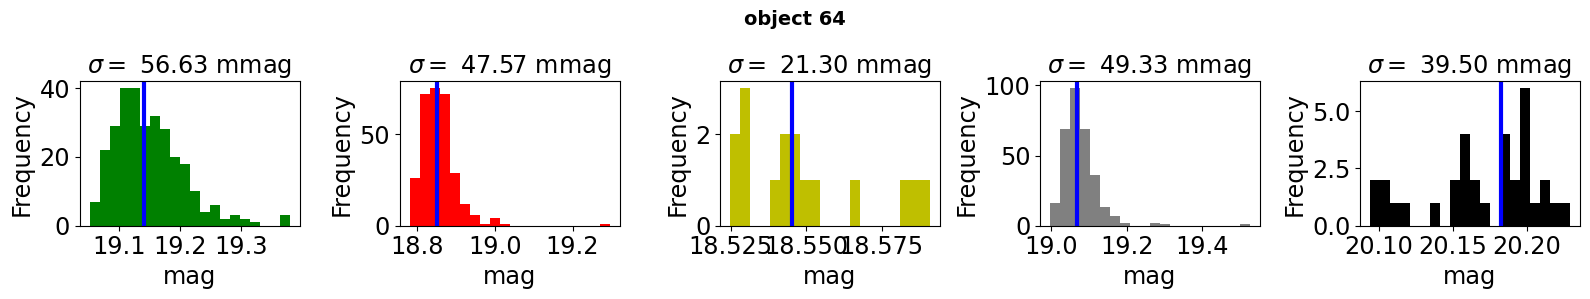

In [18]:
plothistogram_magperband(the_df)

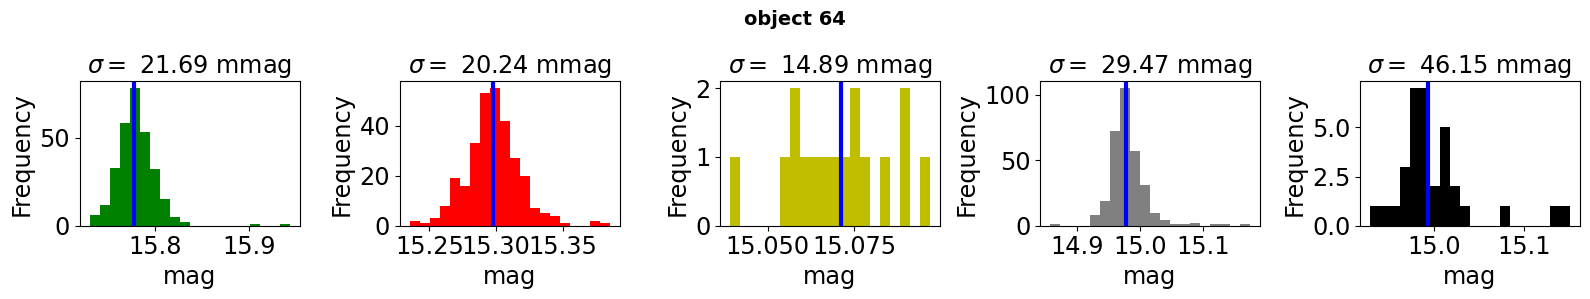

In [19]:
plothistogram_valperband(the_df,ctag="psfMag")

In [20]:
dfg,dfr,dfi,dfz,dfy = get_df_perband(the_df)   
(medg,medr,medi,medz,medy) = get_df_median(the_df)
(sigg,sigr,sigi,sigz,sigy) = get_df_sigma(the_df)

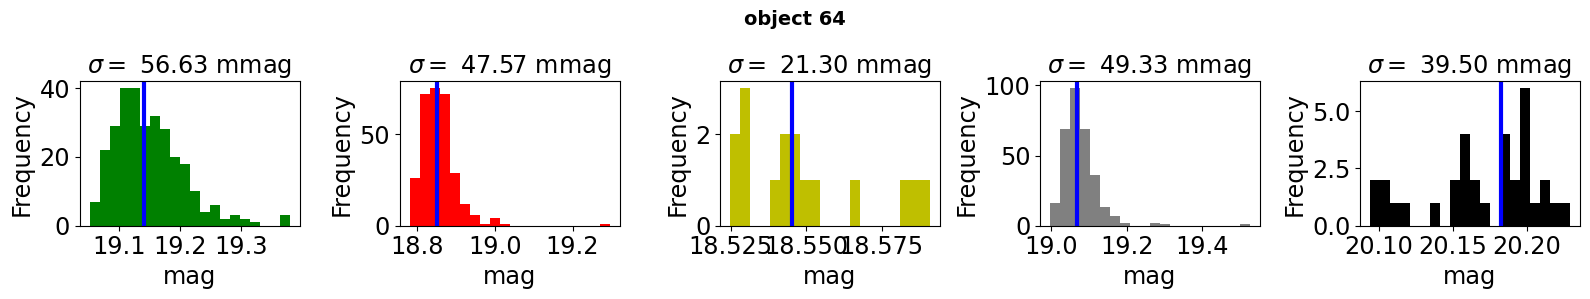

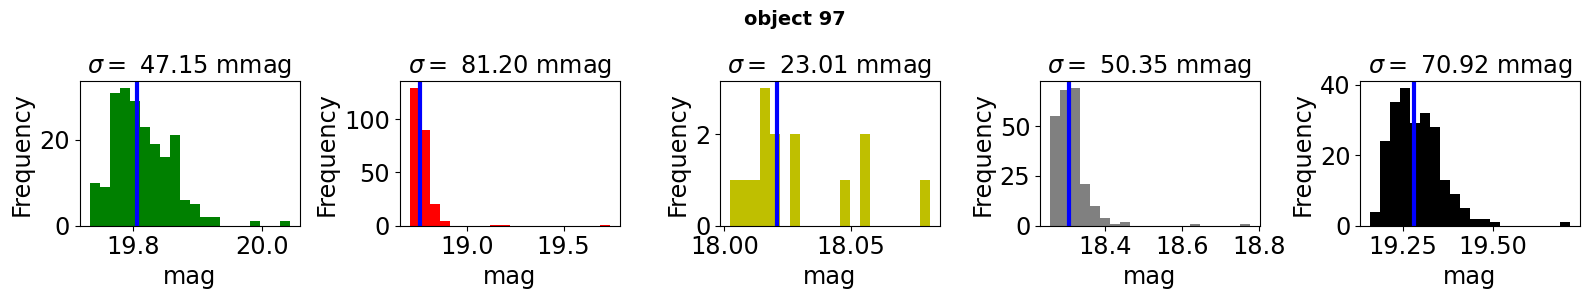

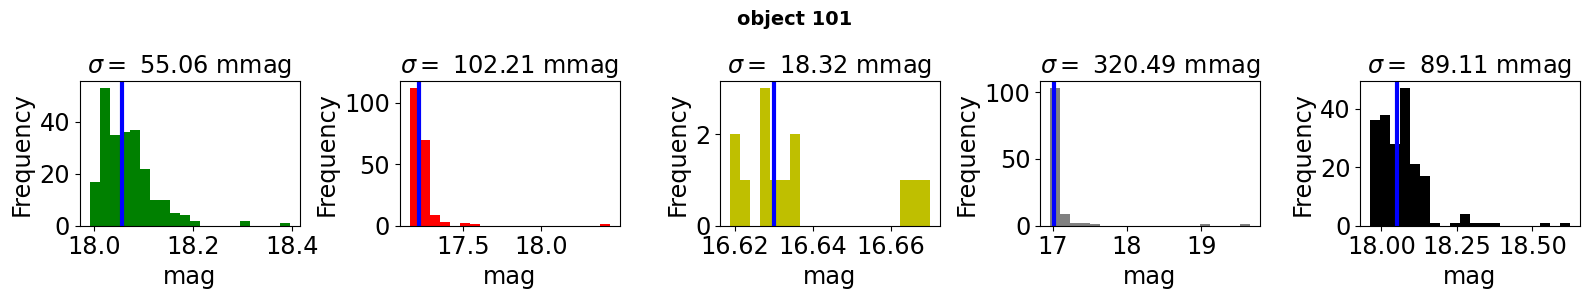

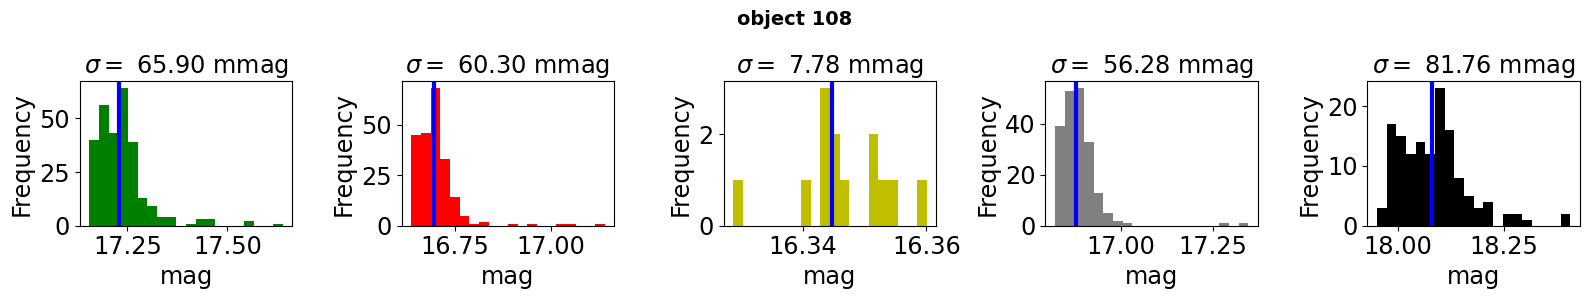

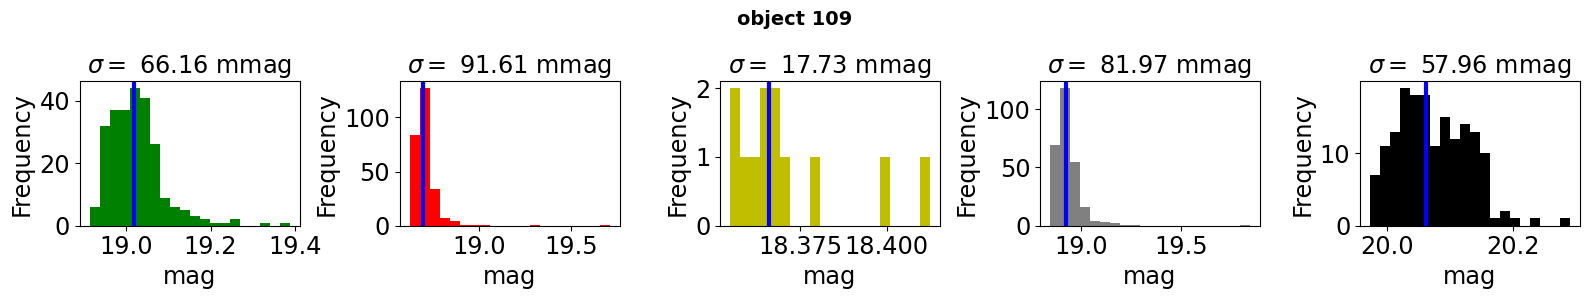

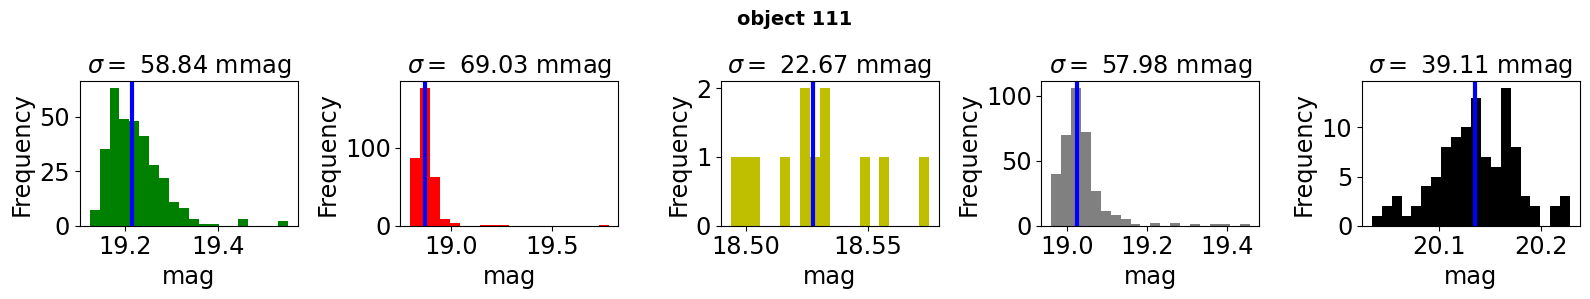

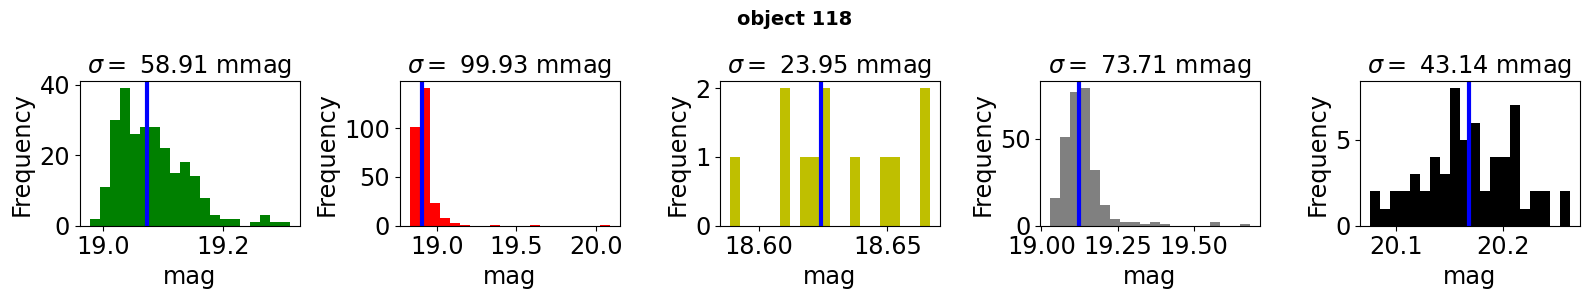

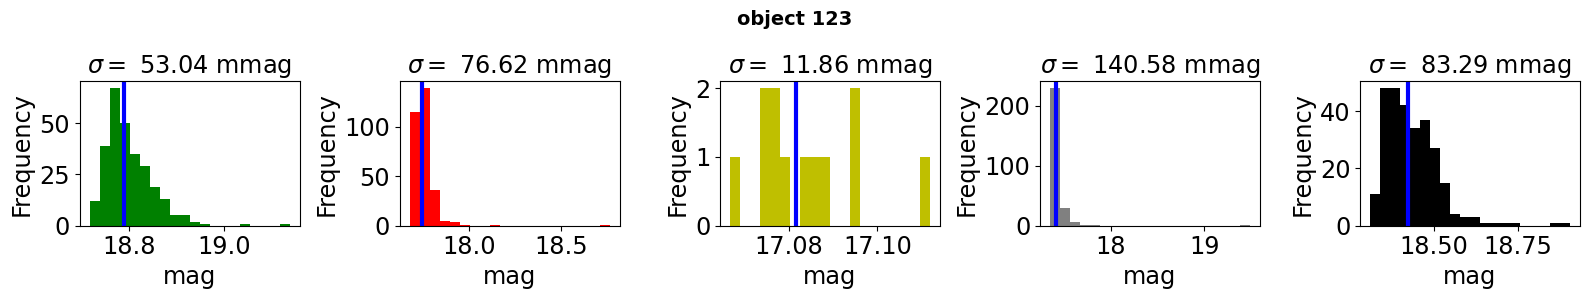

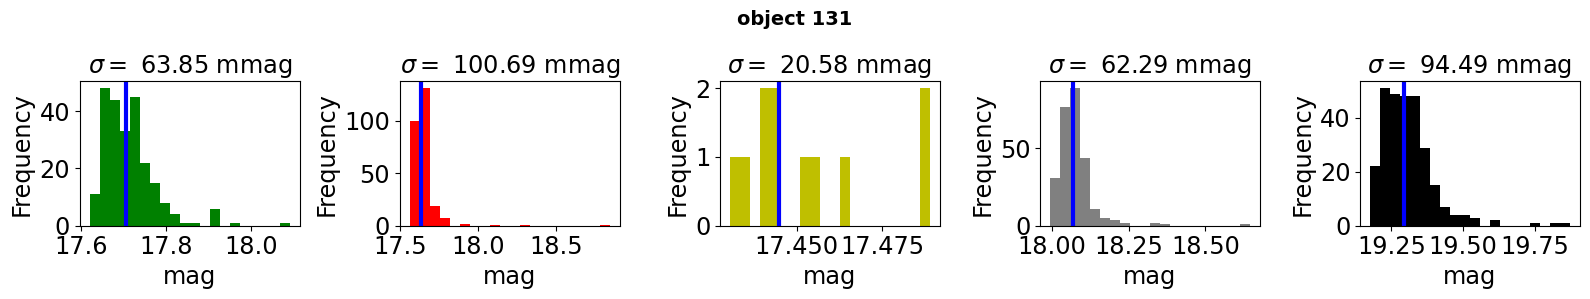

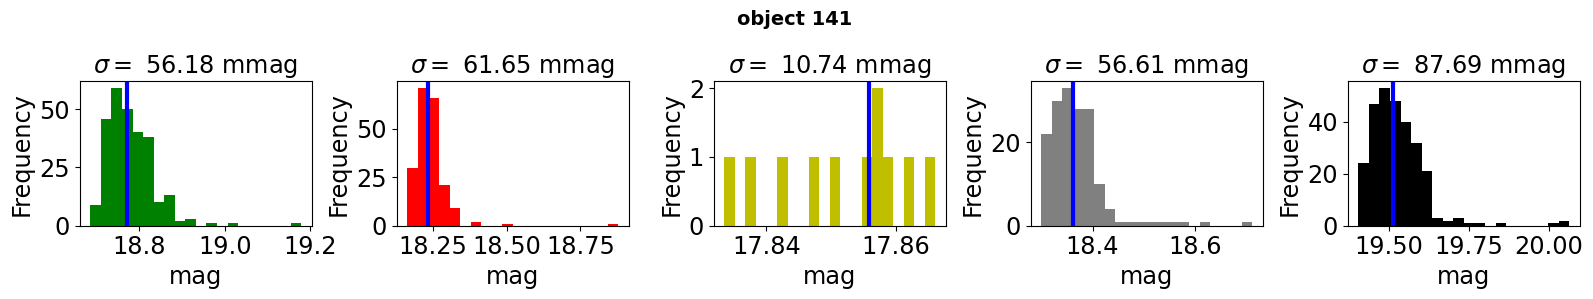

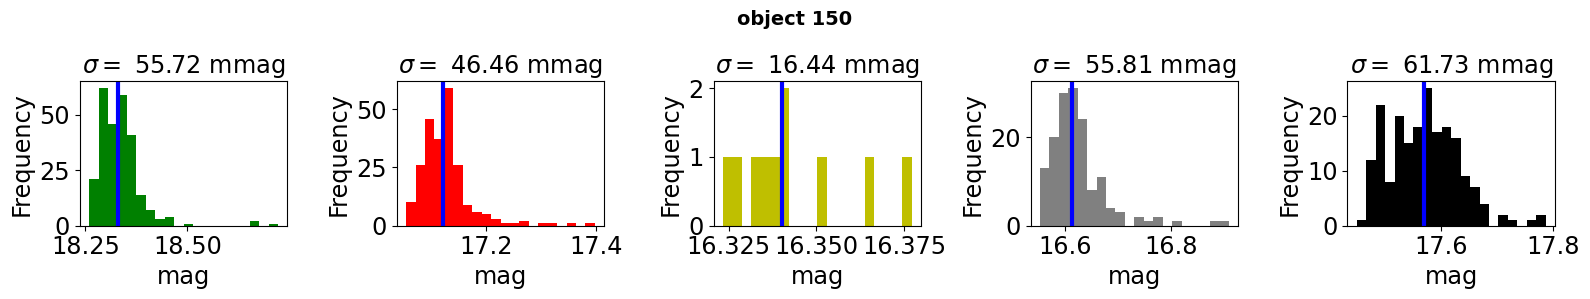

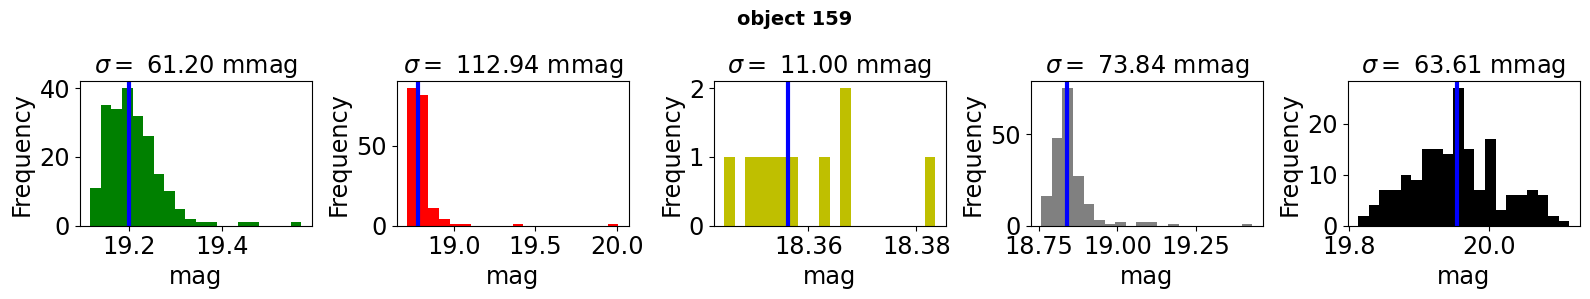

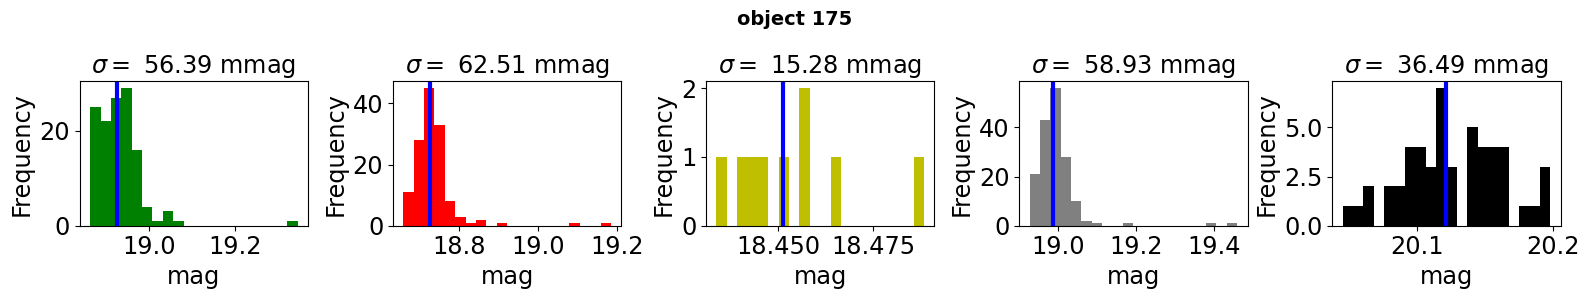

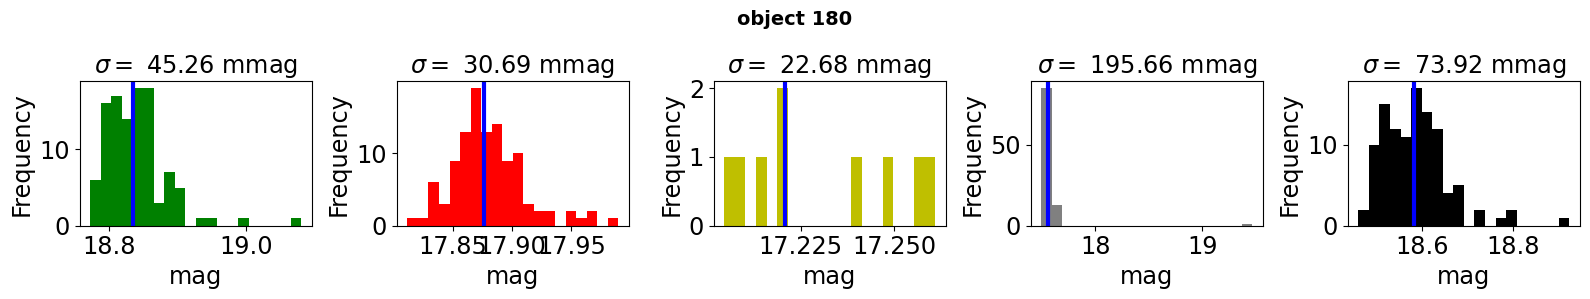

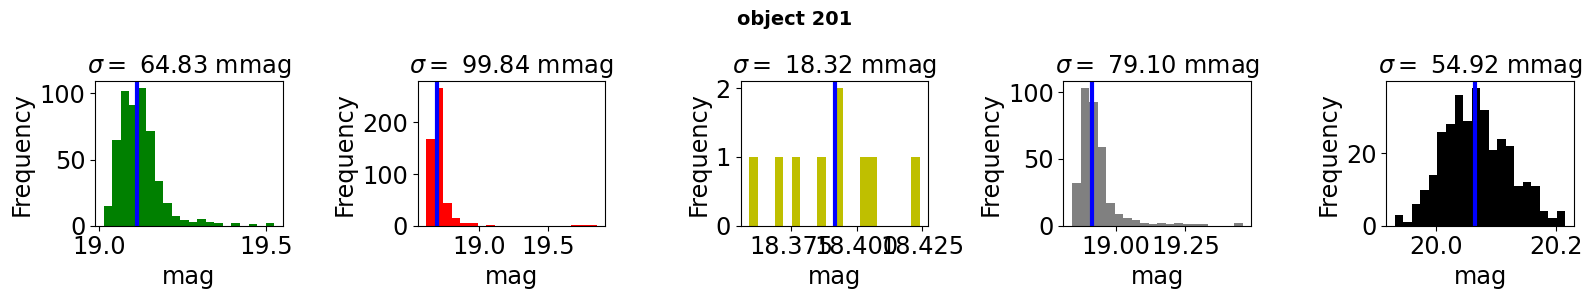

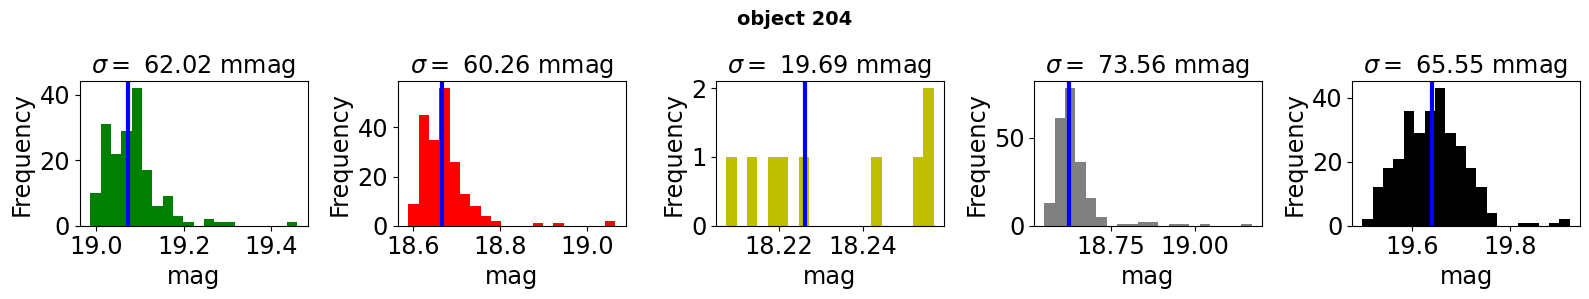

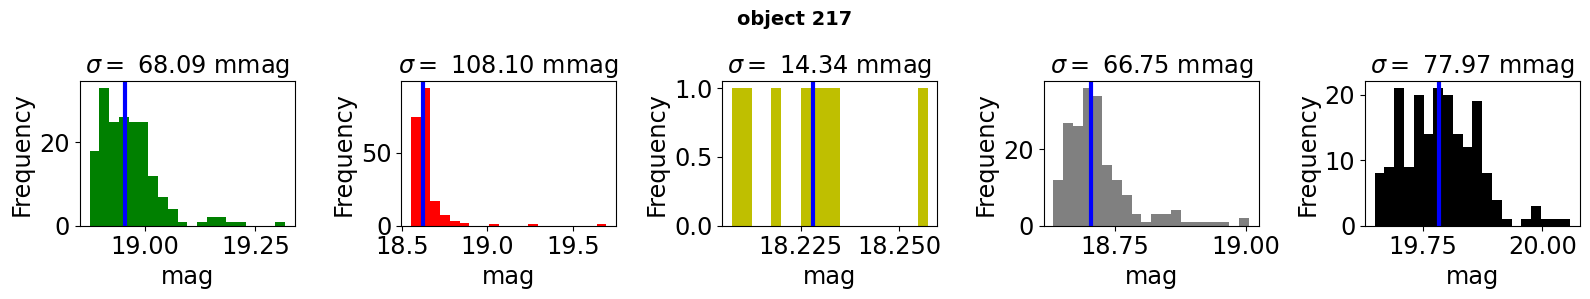

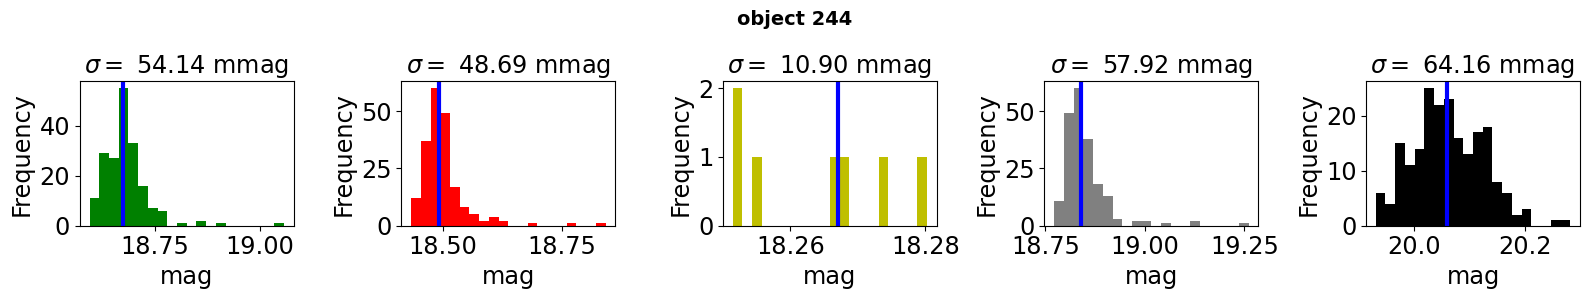

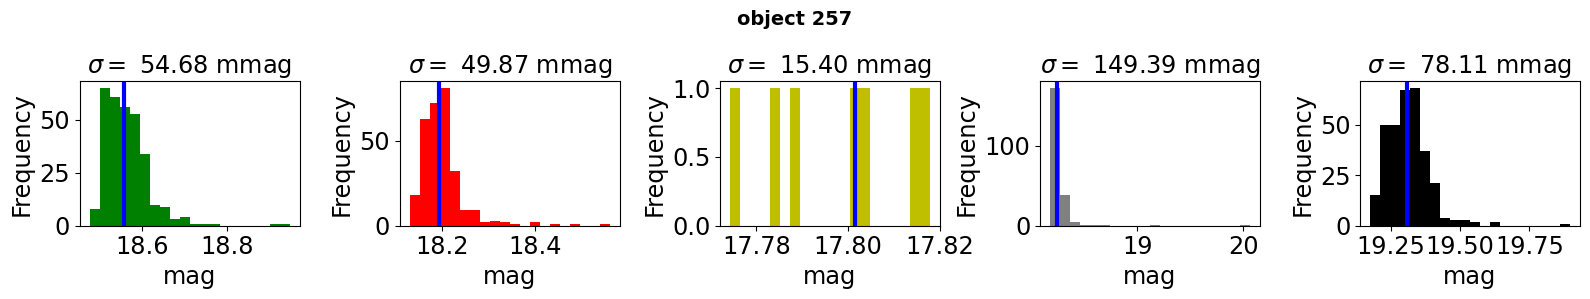

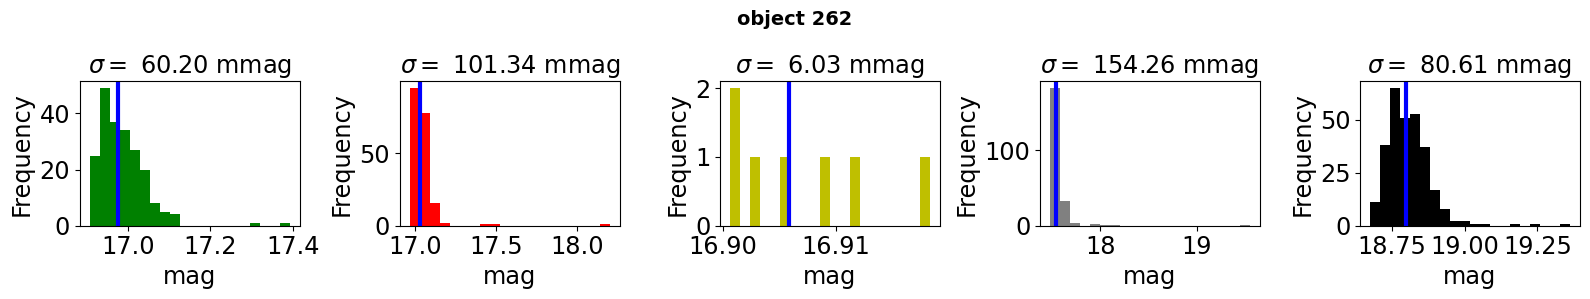

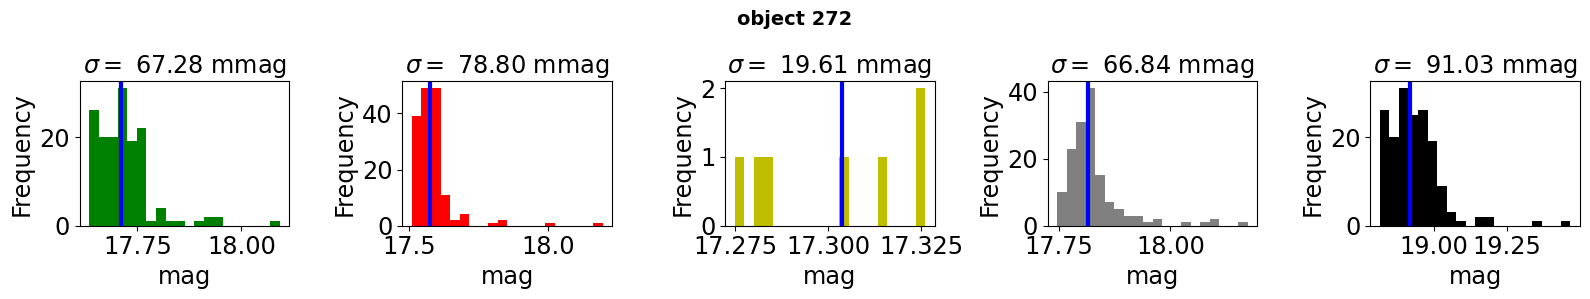

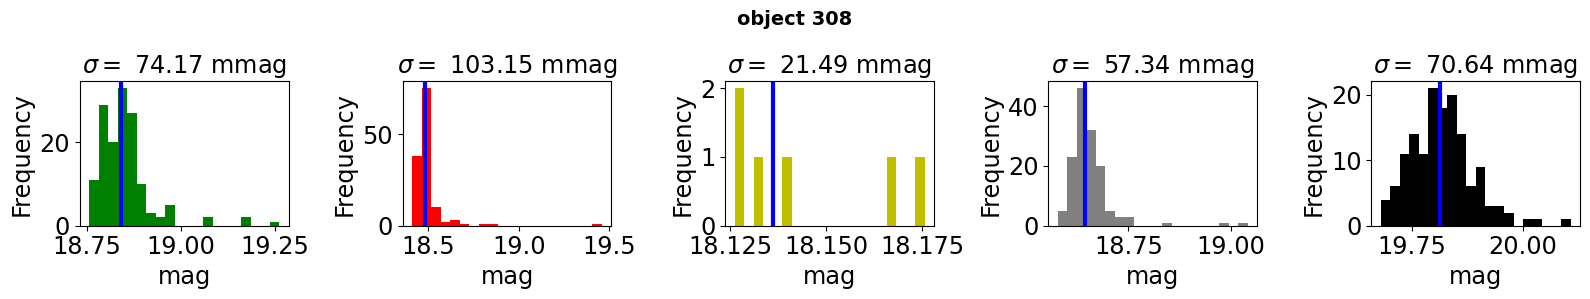

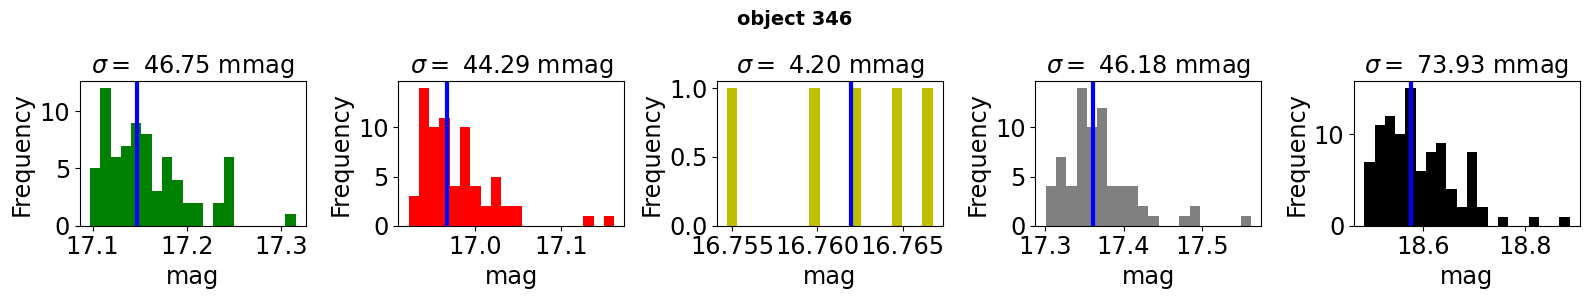

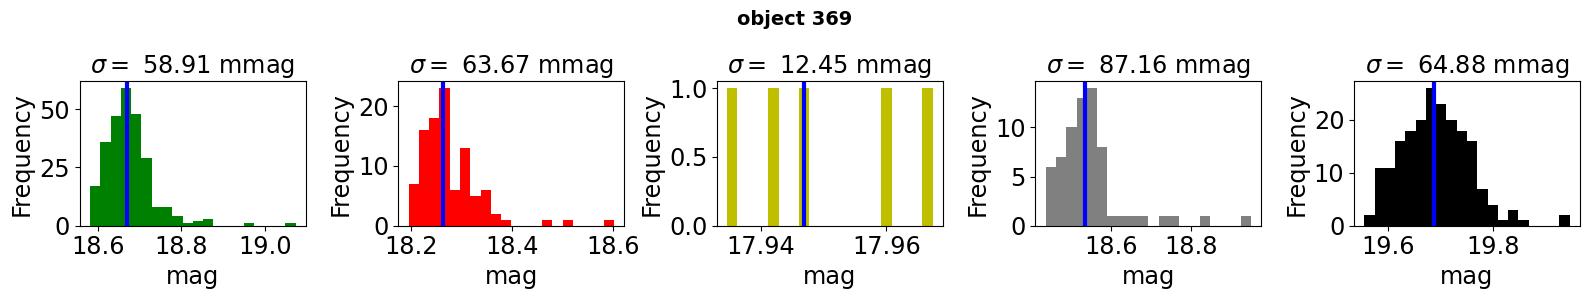

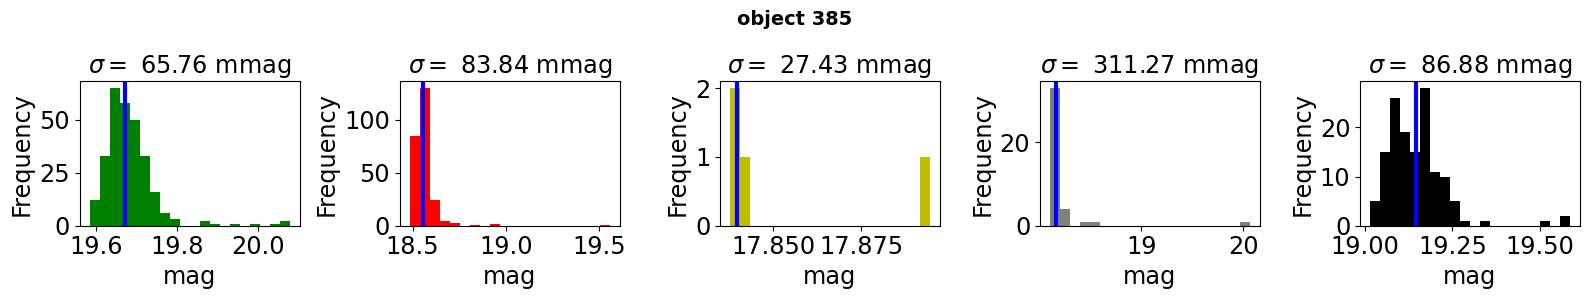

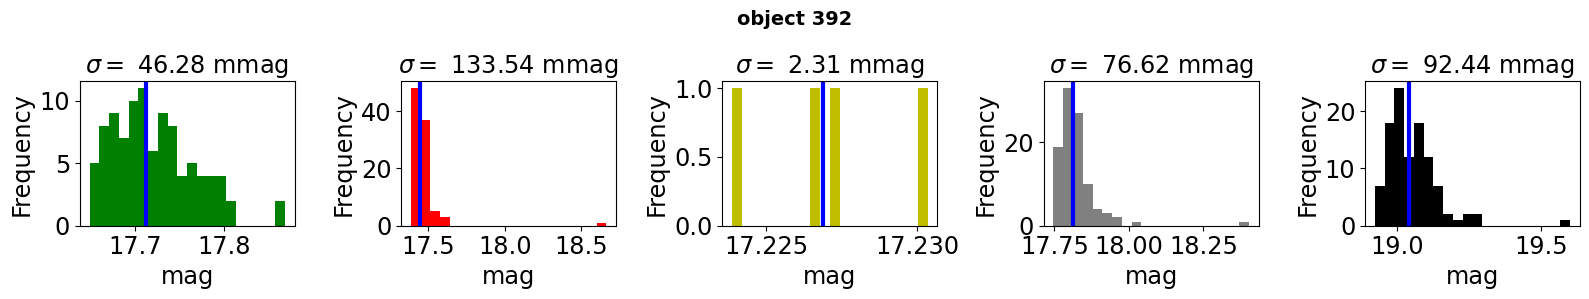

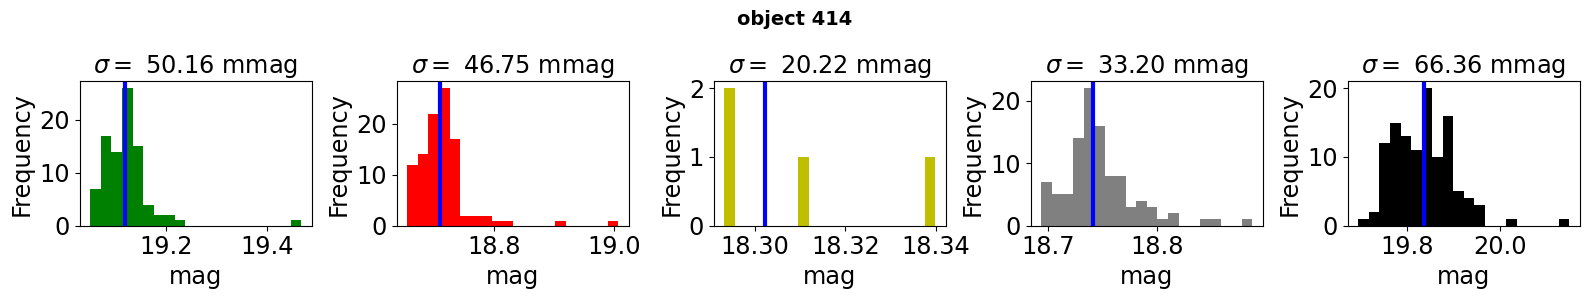

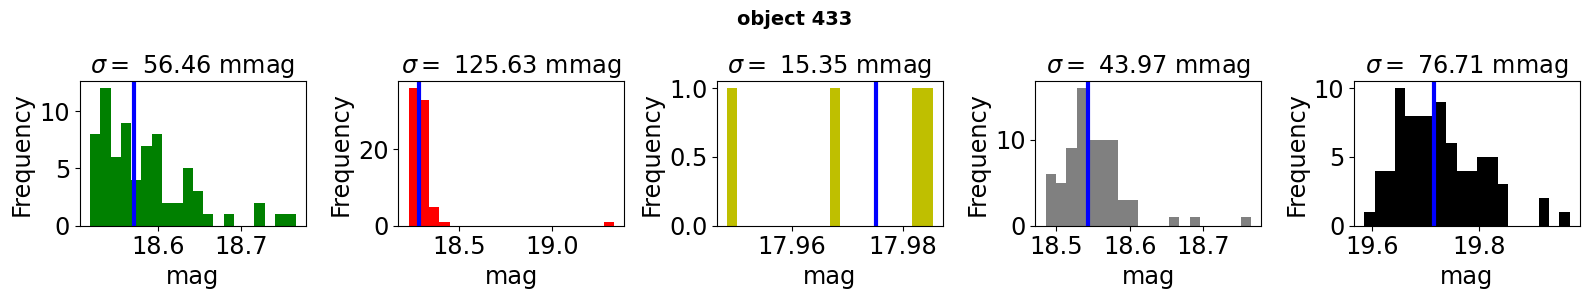

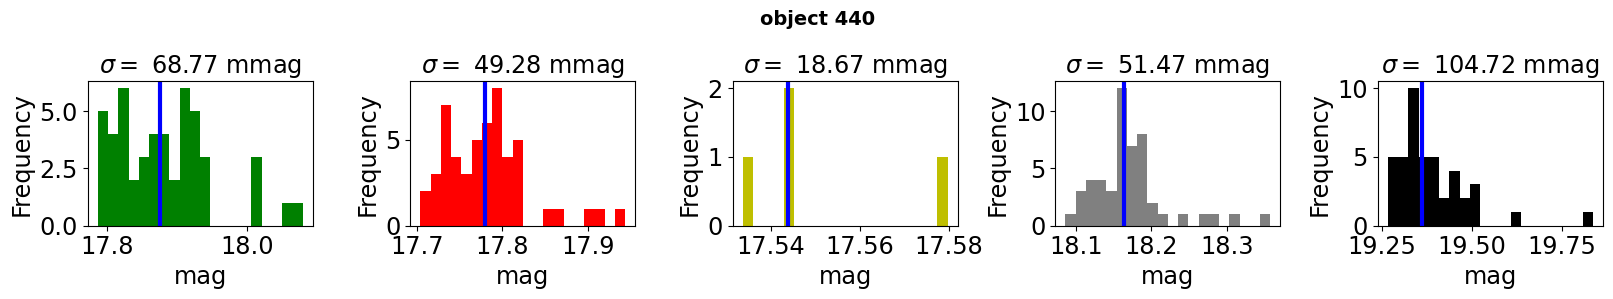

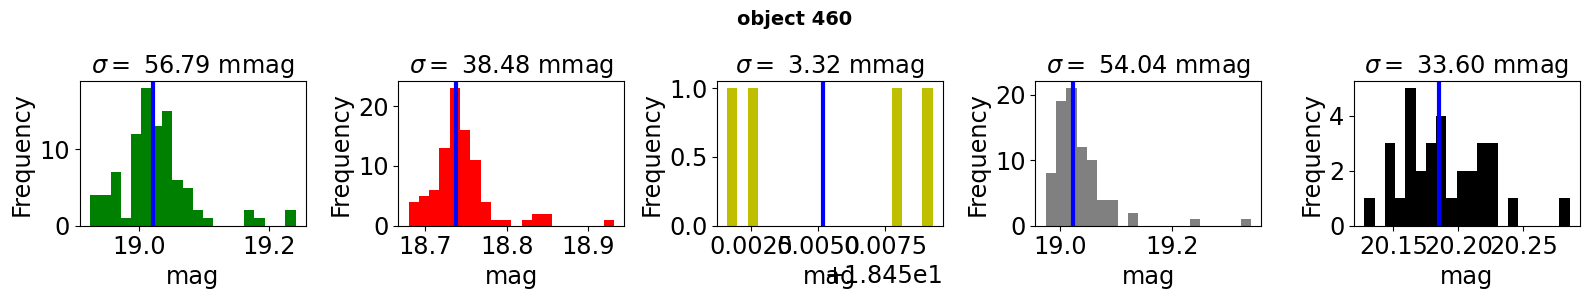

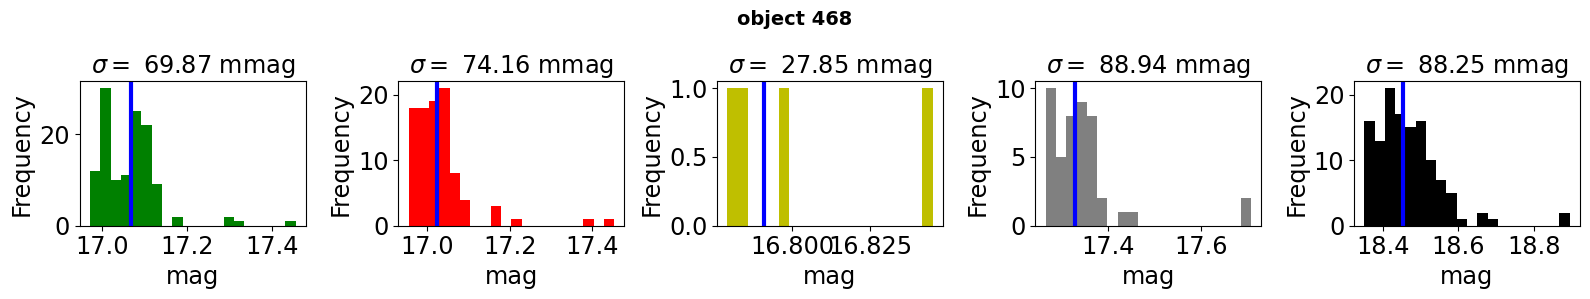

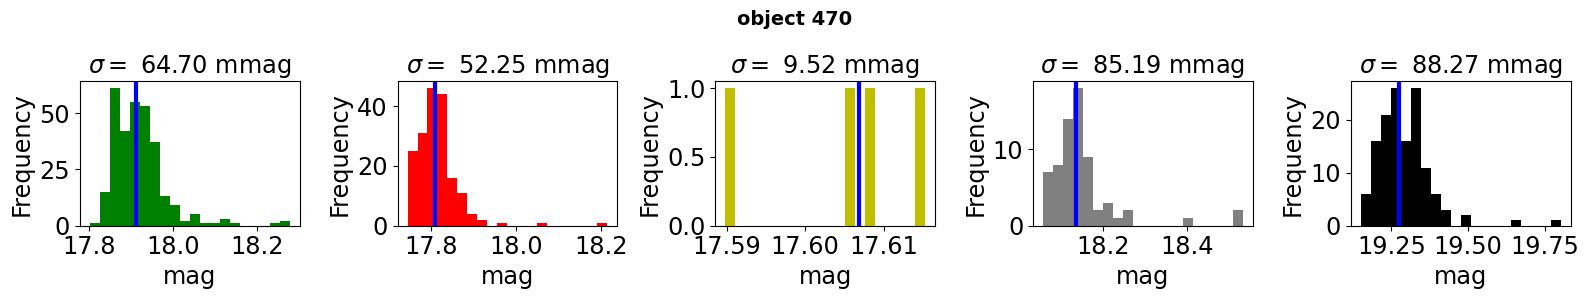

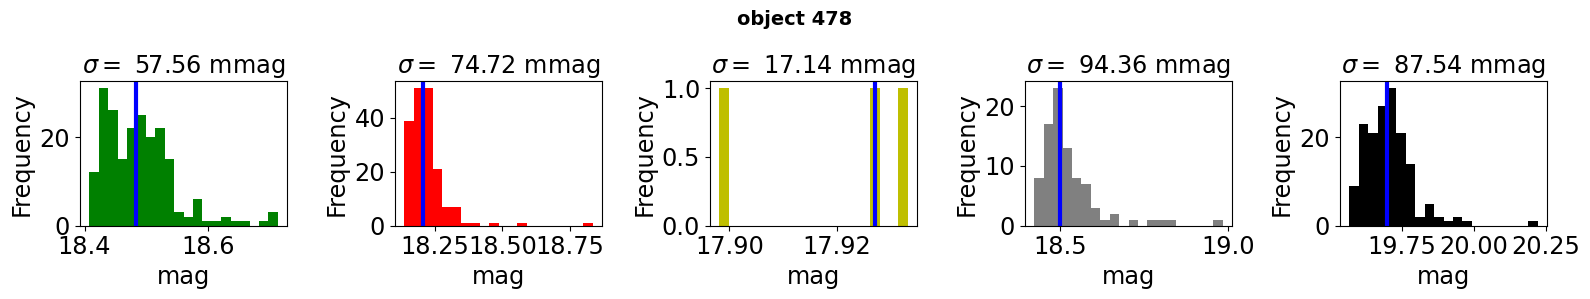

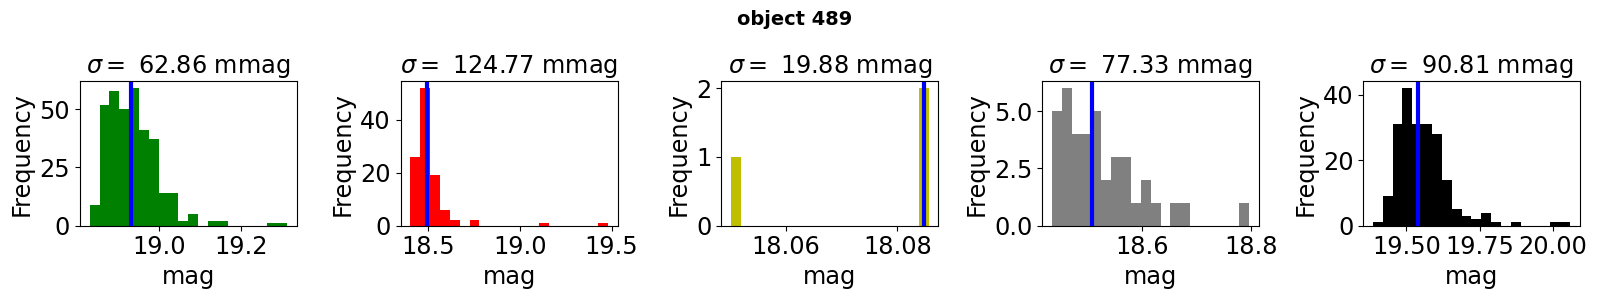

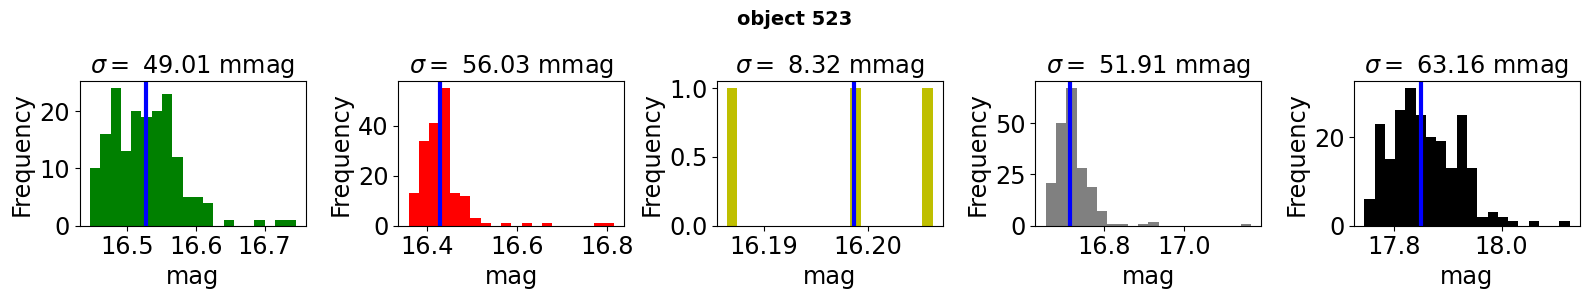

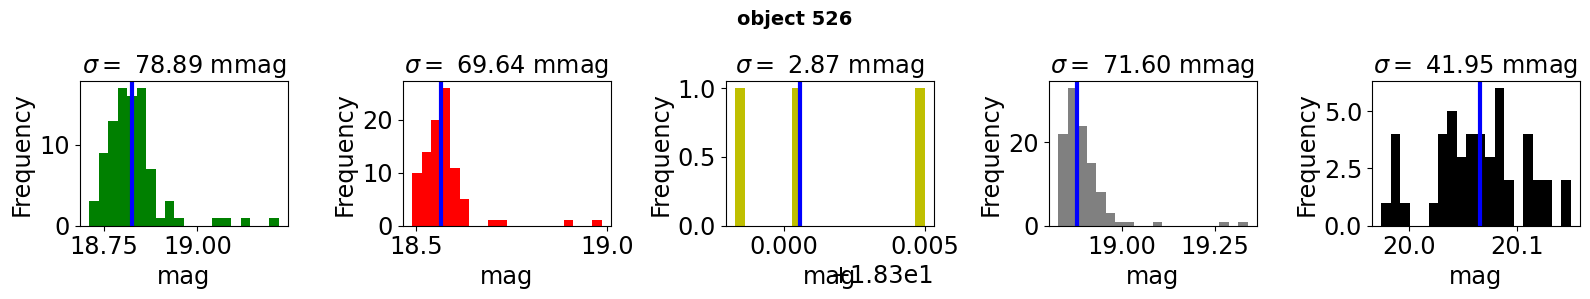

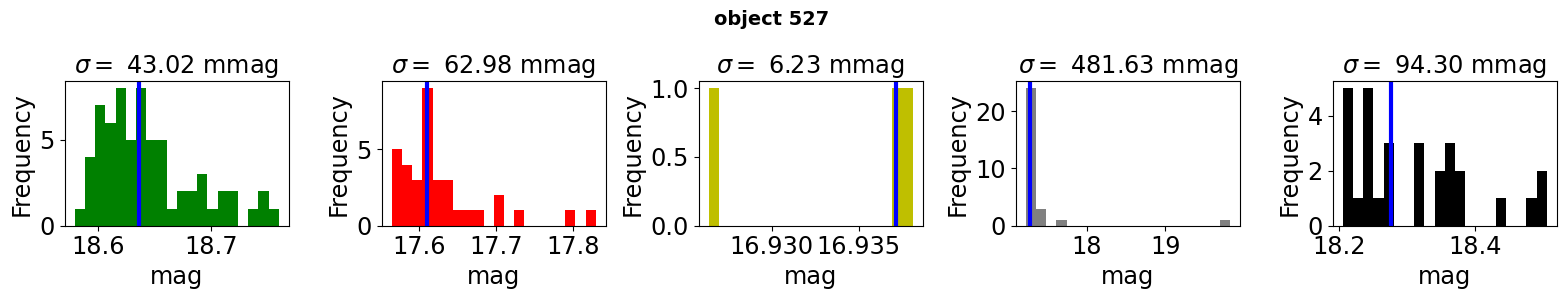

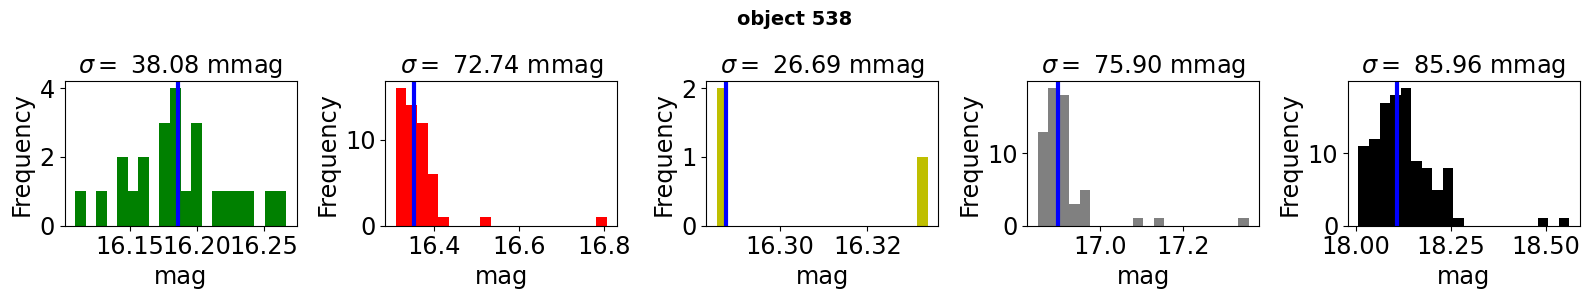

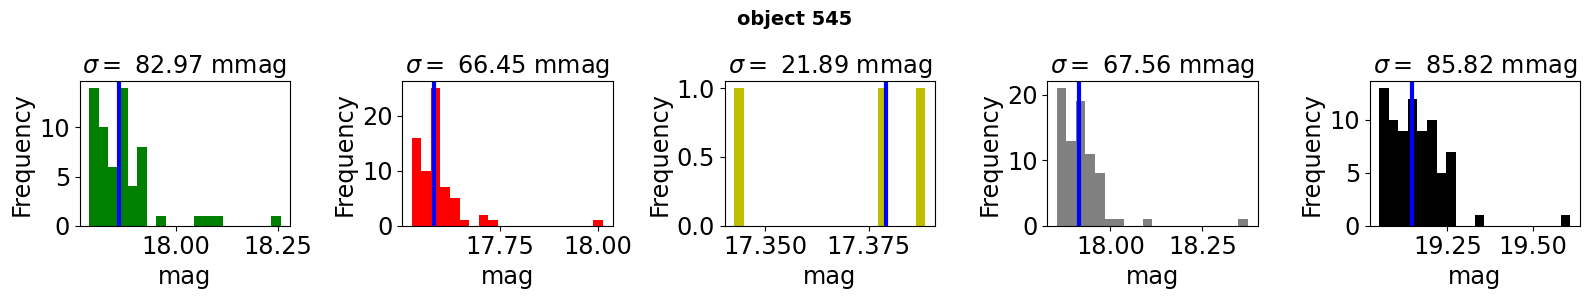

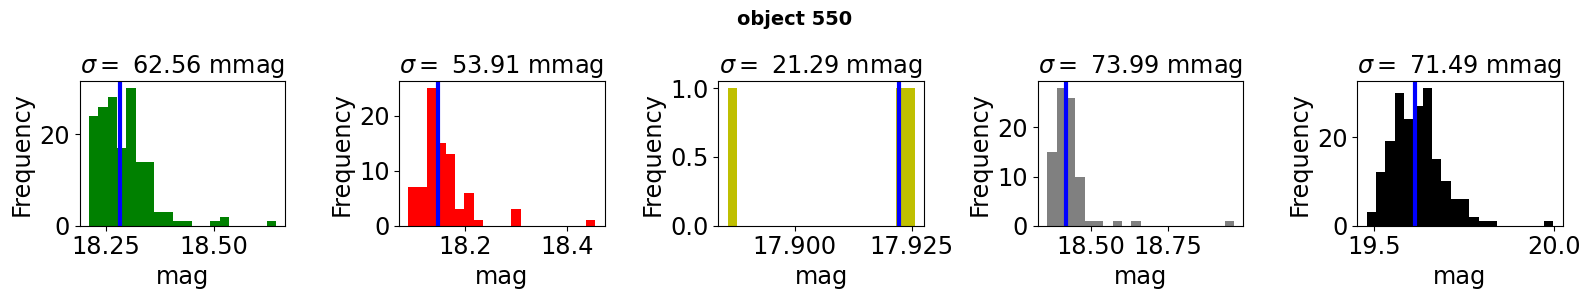

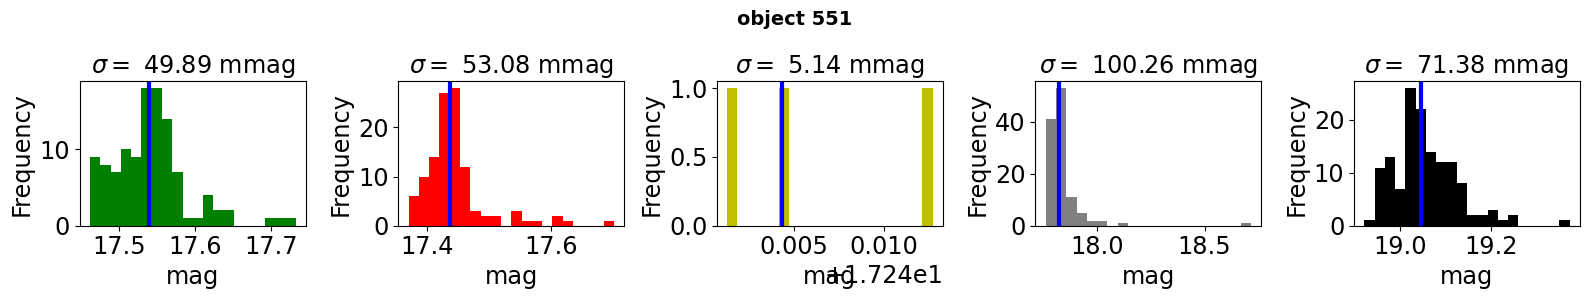

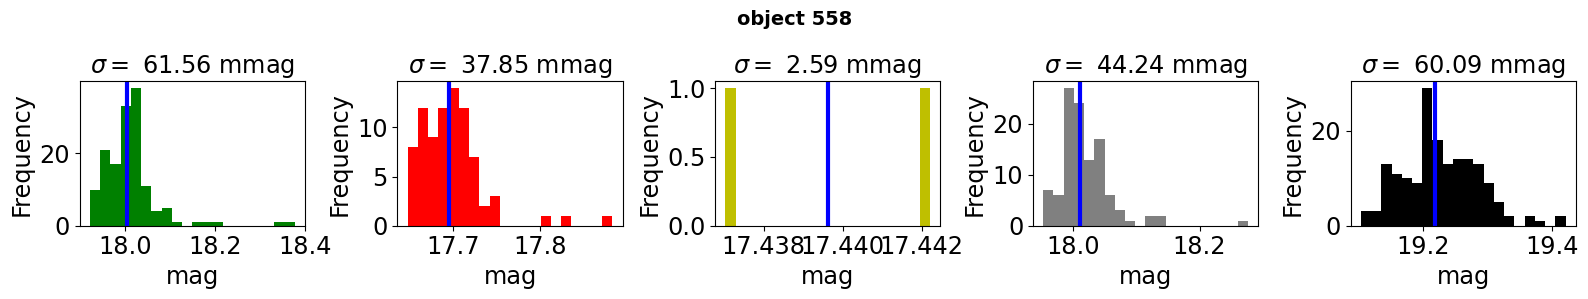

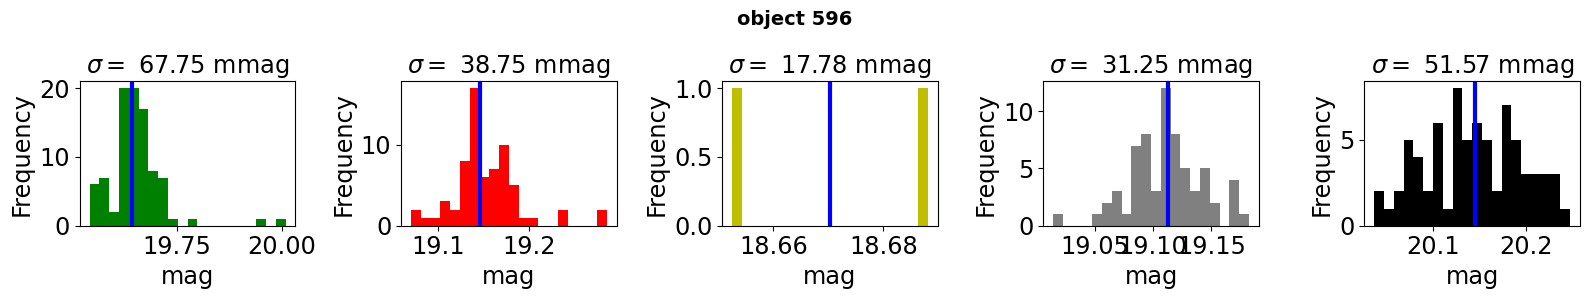

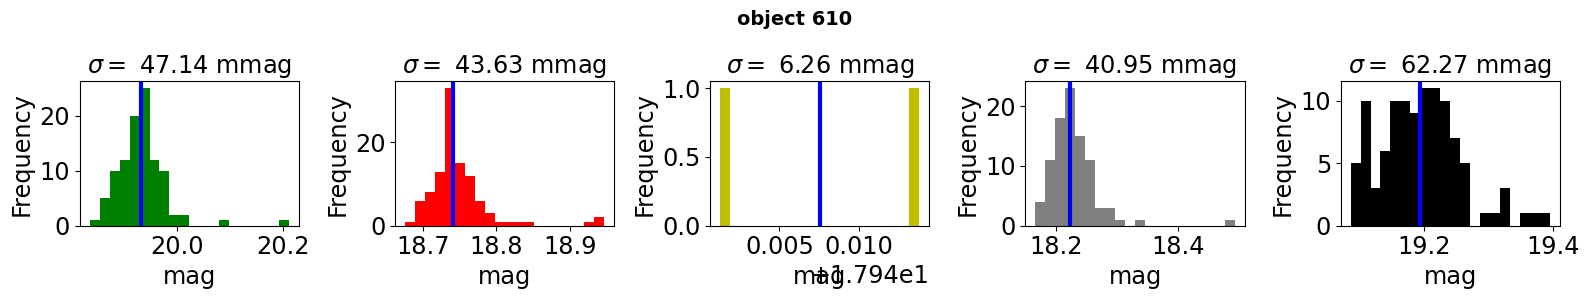

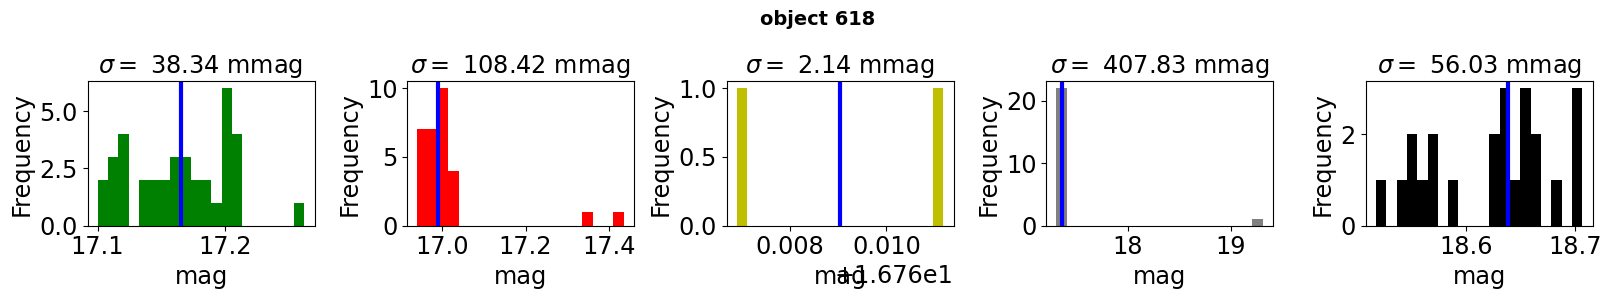

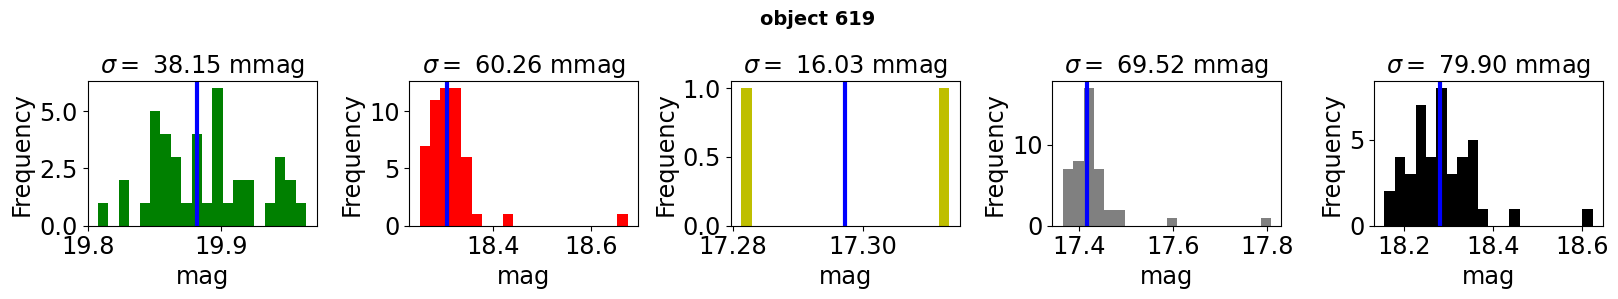

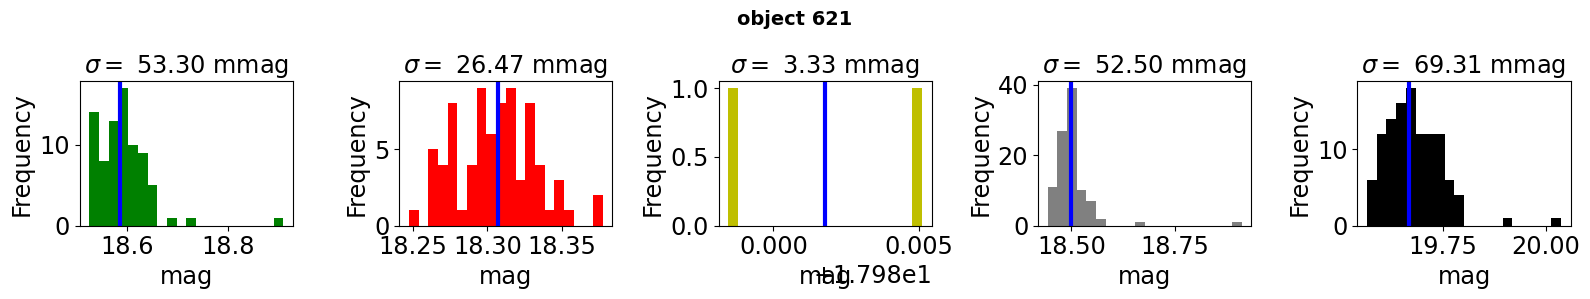

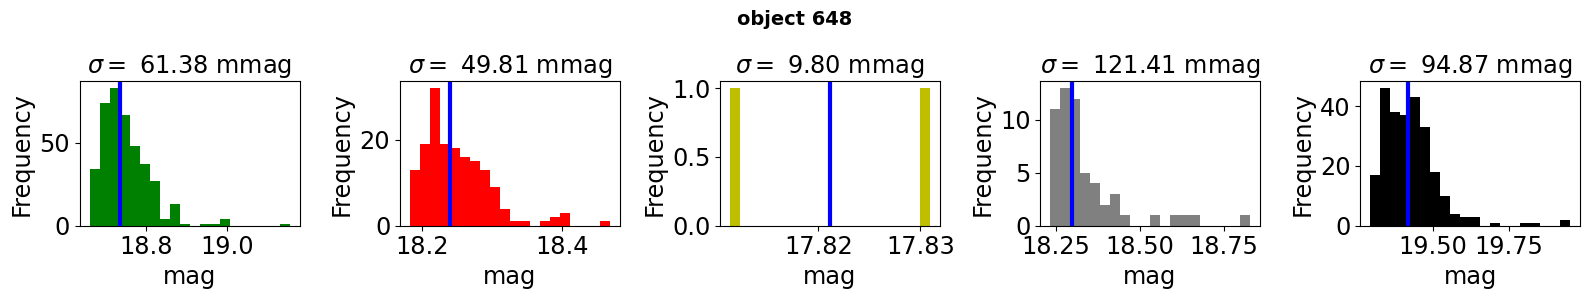

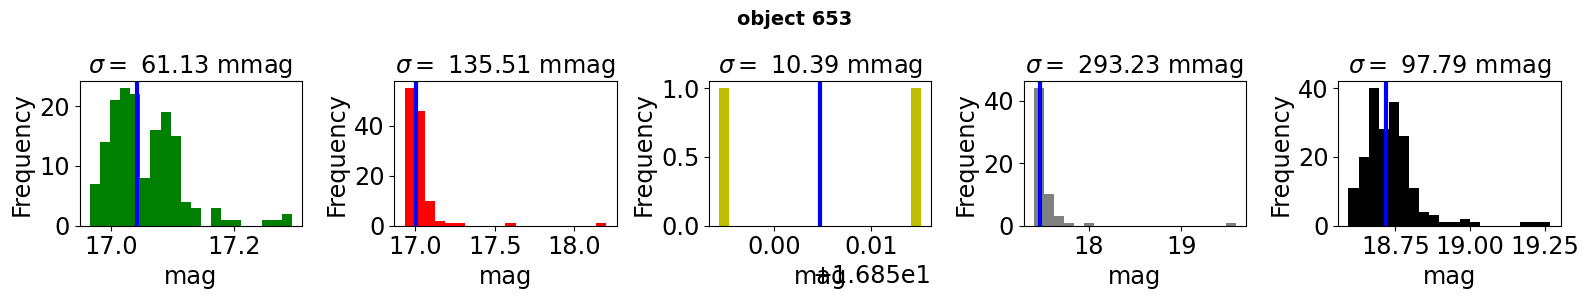

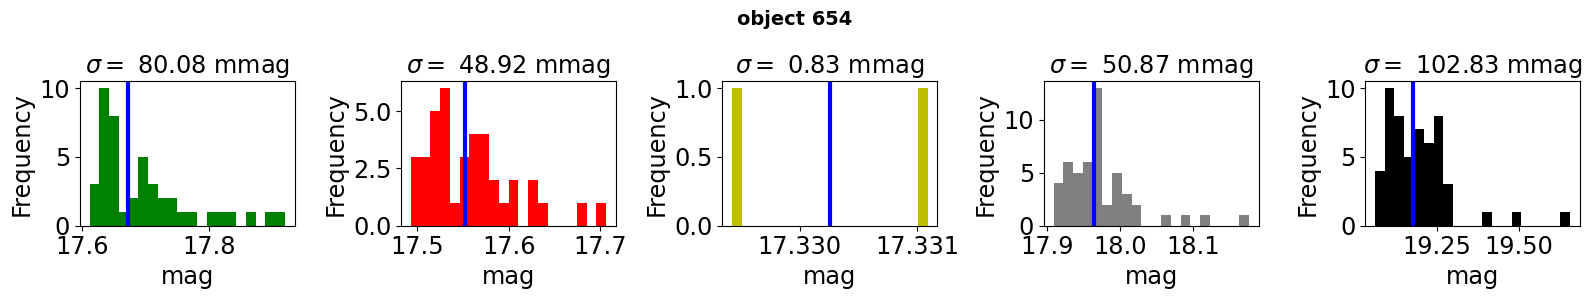

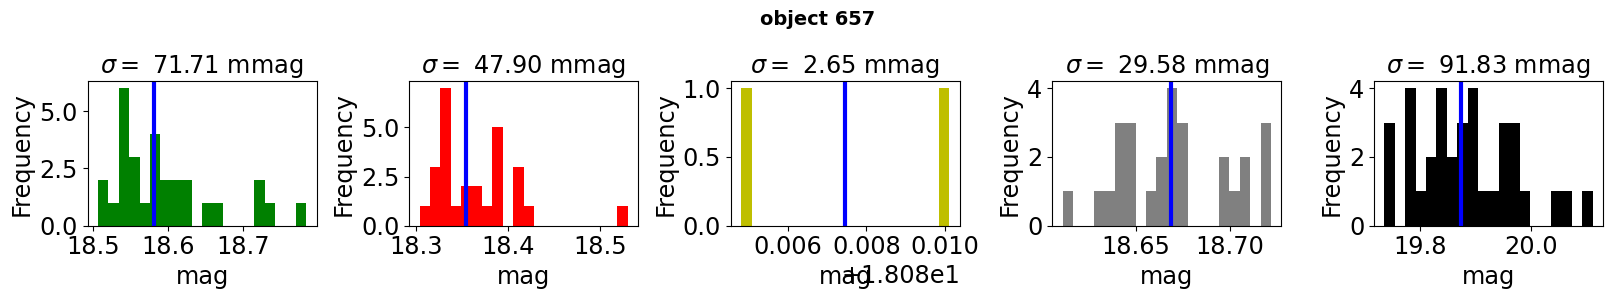

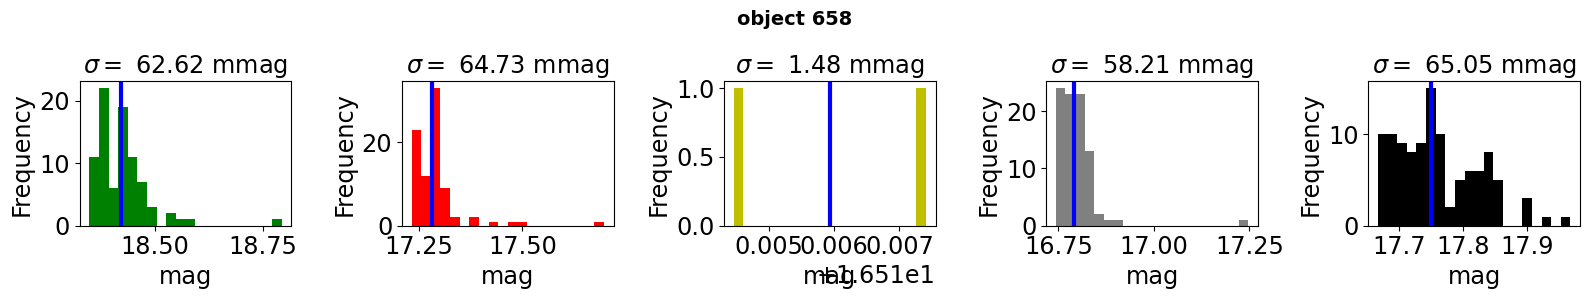

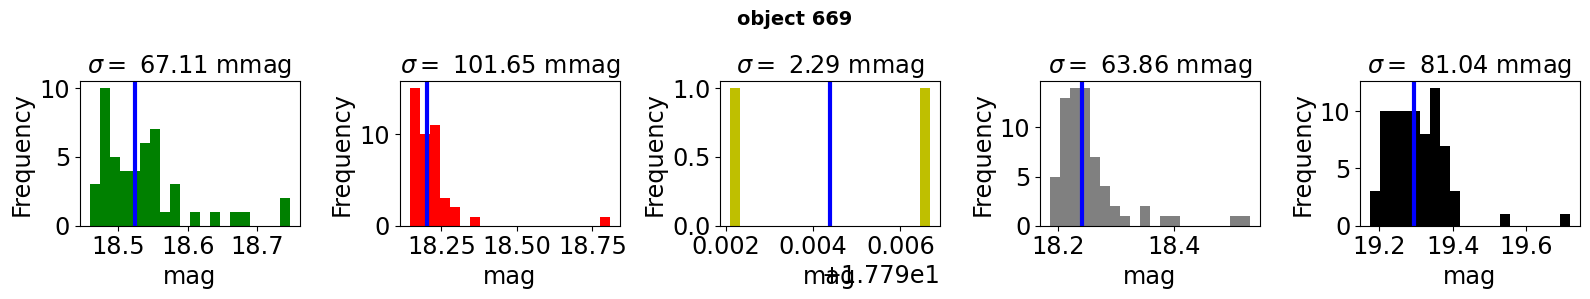

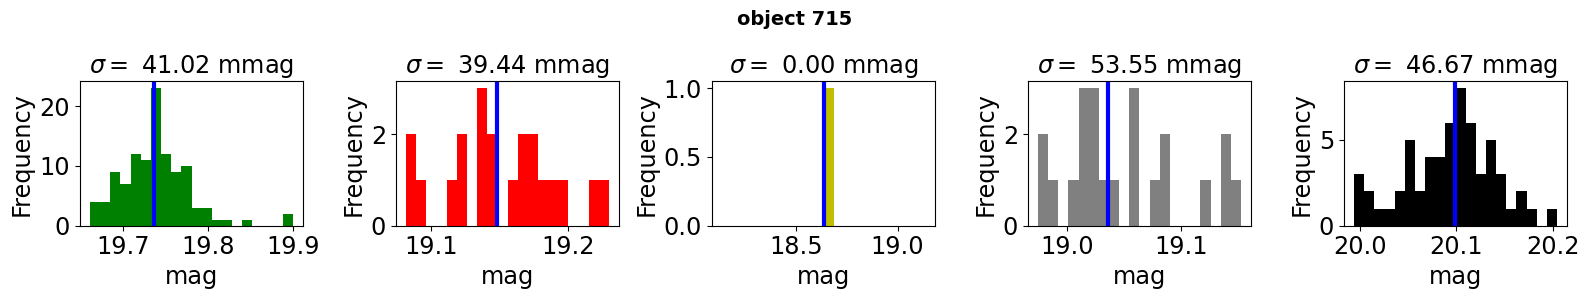

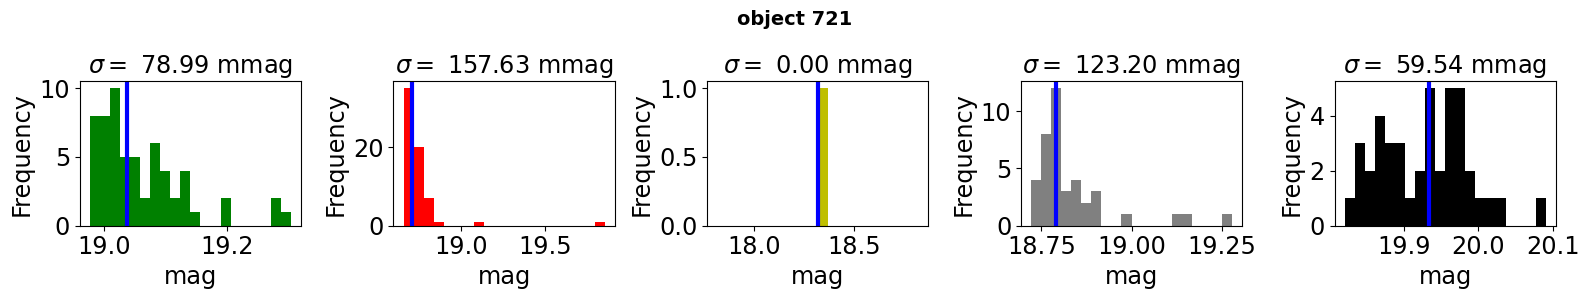

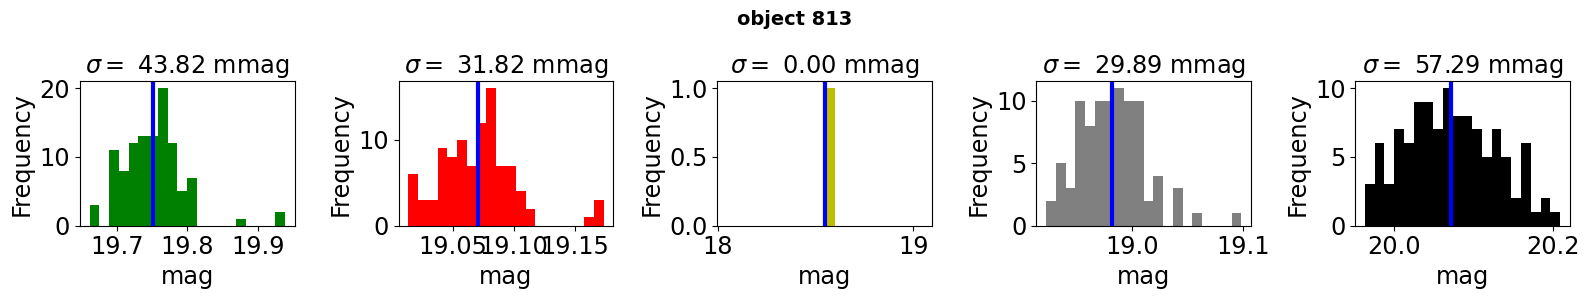

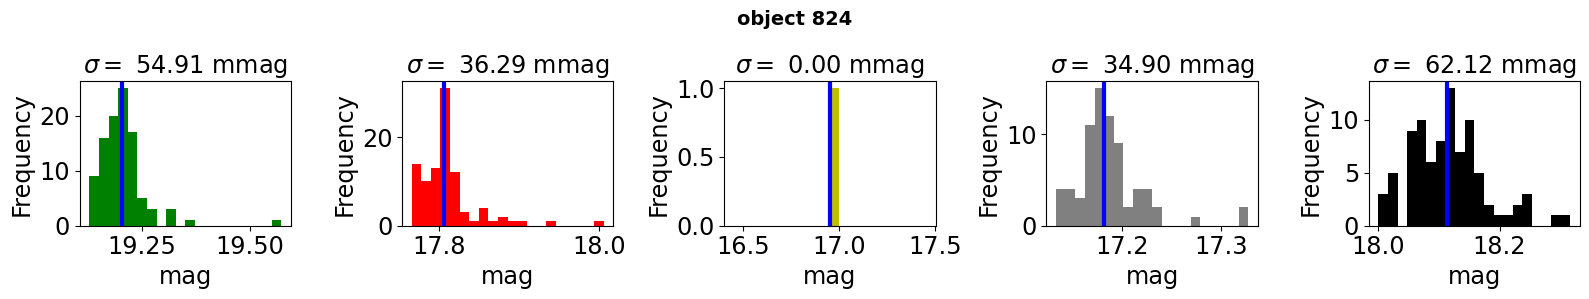

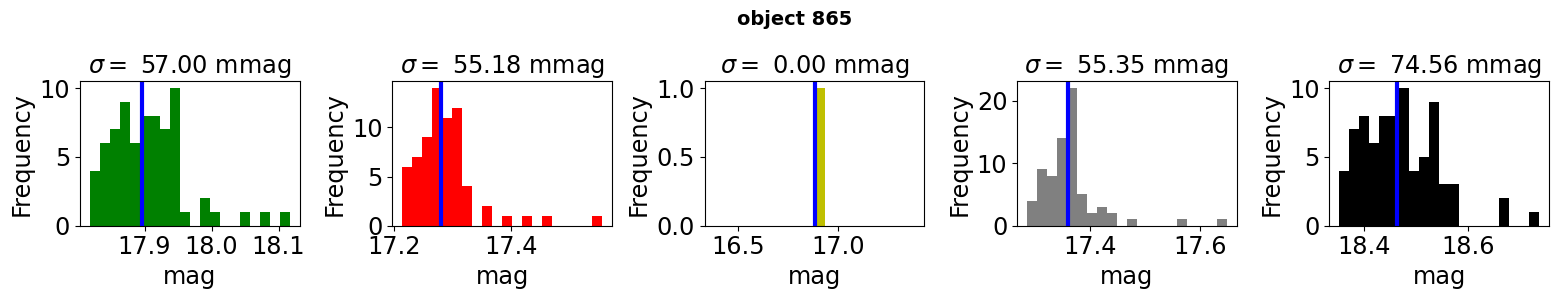

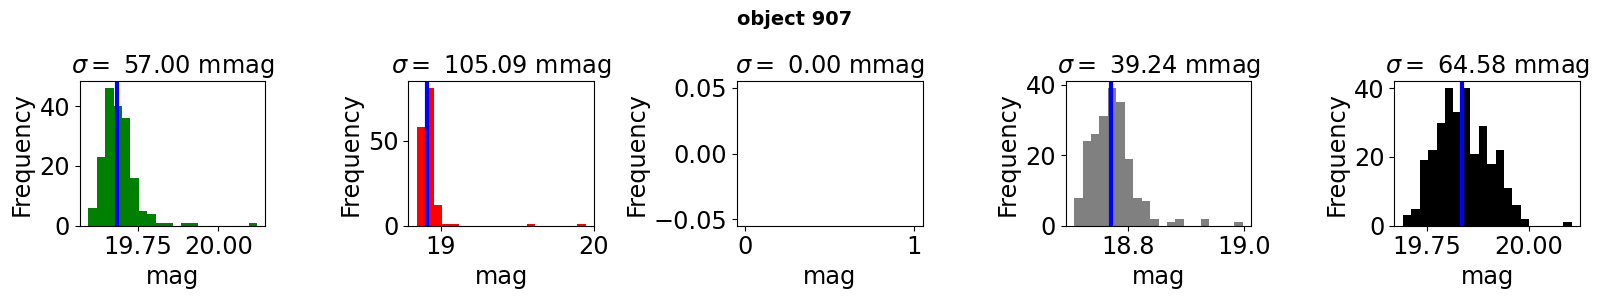

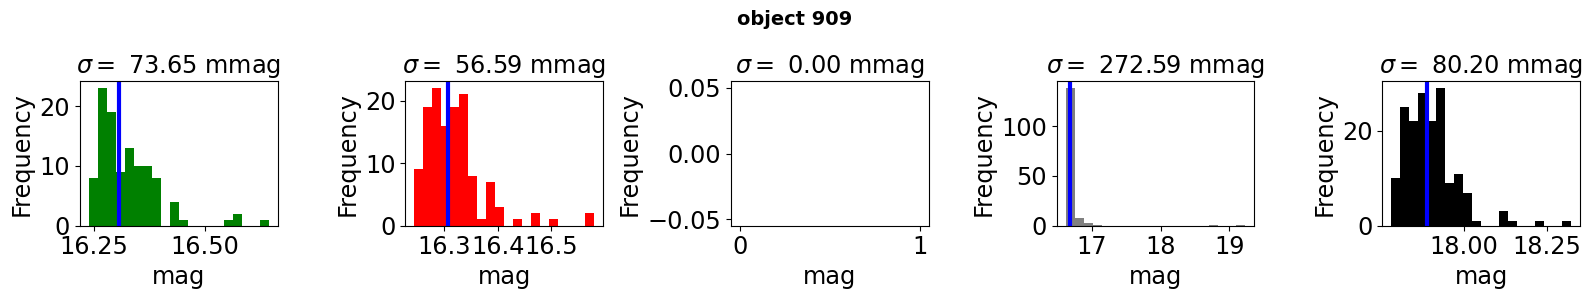

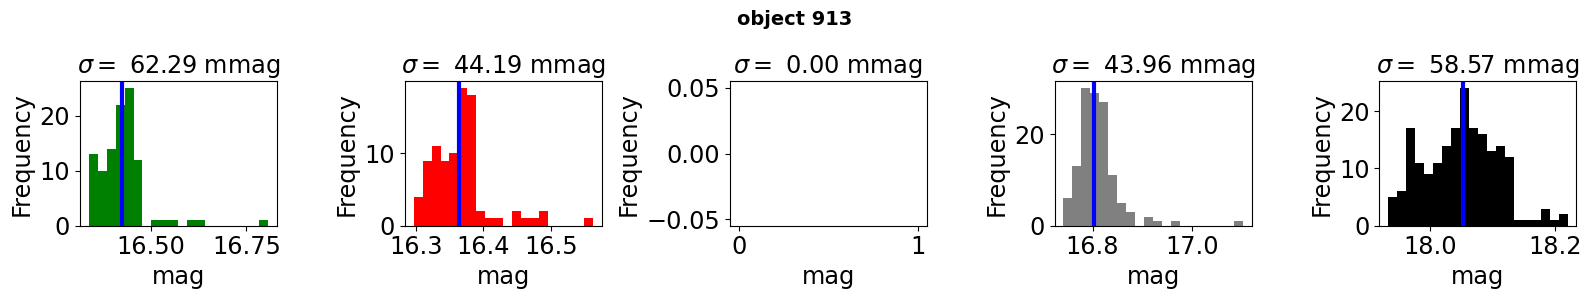

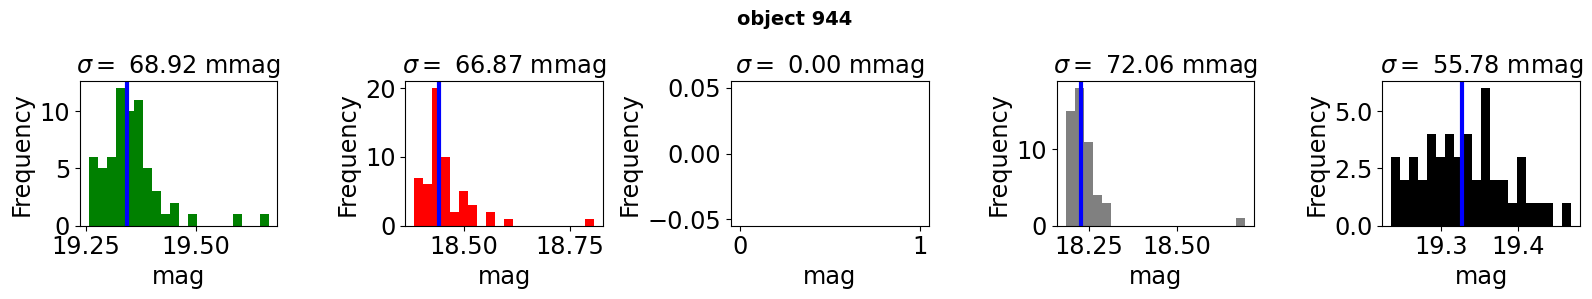

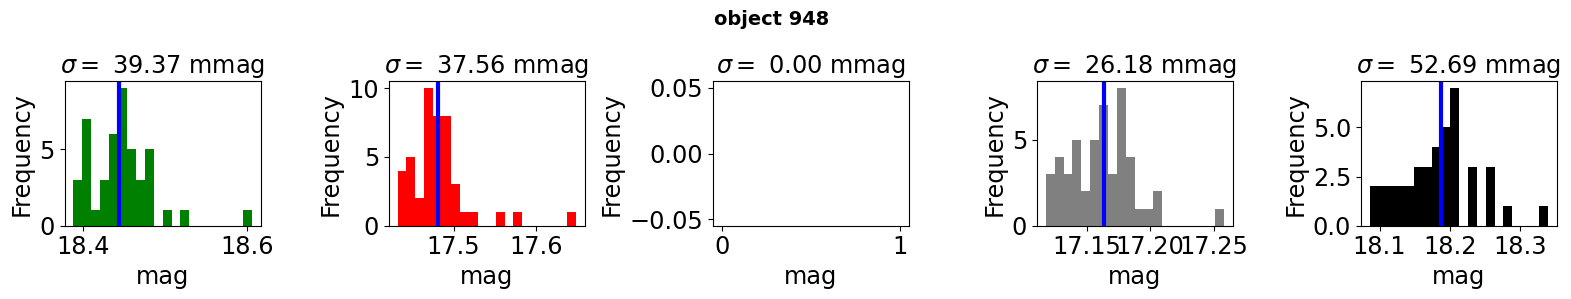

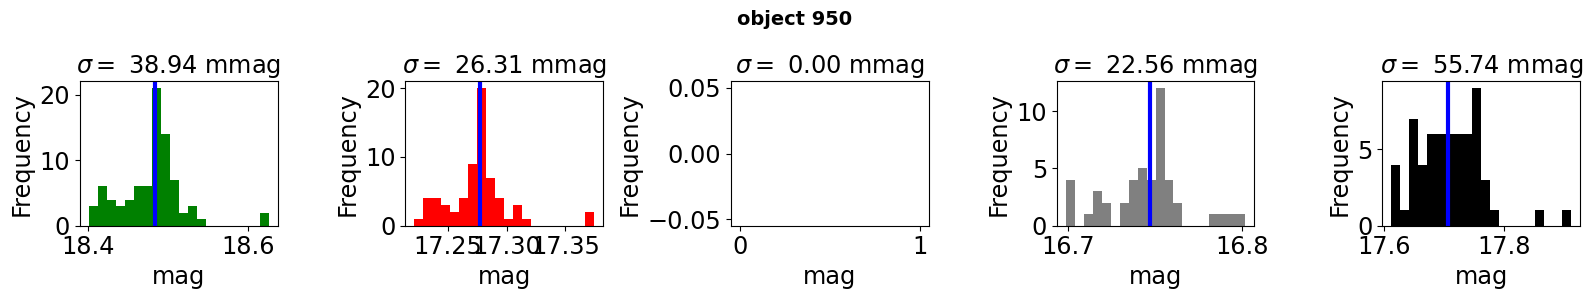

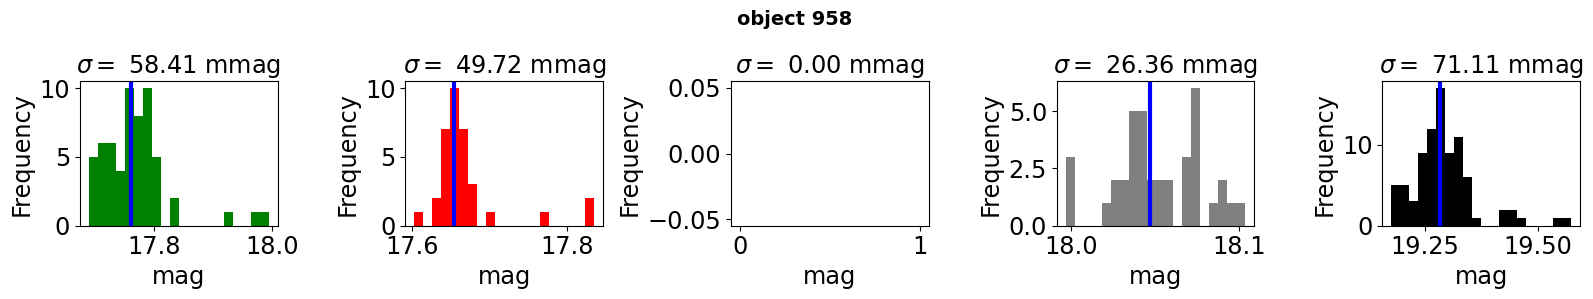

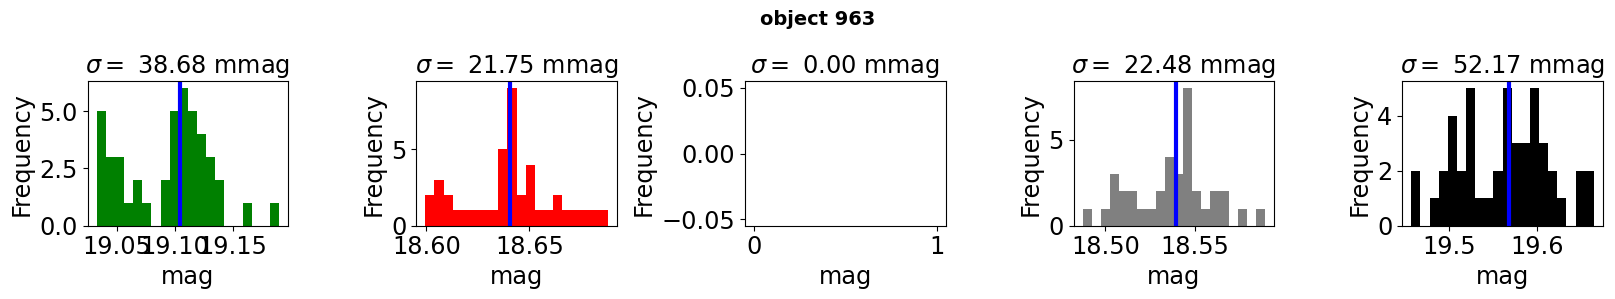

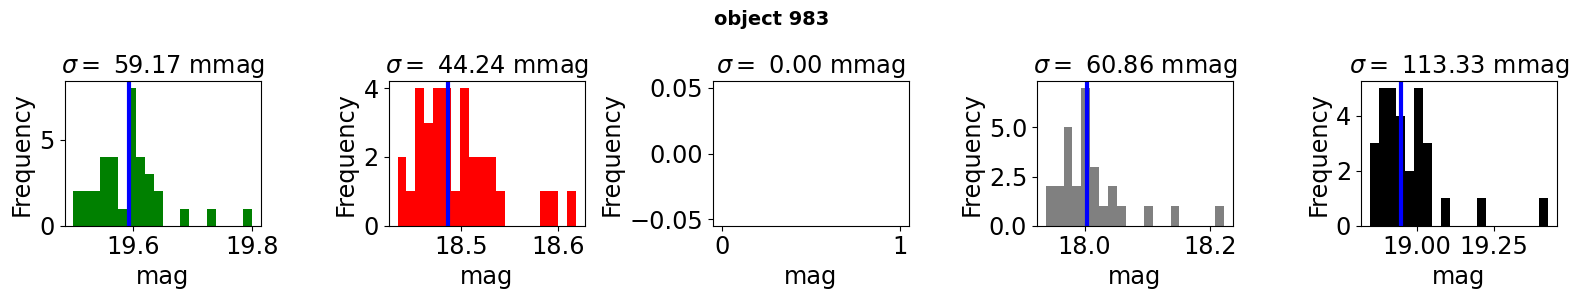

In [21]:
df_col_ap = pd.DataFrame(columns=["obj","g","r","i","z","y","sg","sr","si","sz","sy"])
for index in range(N):
    the_df = all_df[index]
    obj=selected_objectnum[index]
    plothistogram_magperband(the_df)

    (medg,medr,medi,medz,medy) = get_df_median(the_df)
    (sigg,sigr,sigi,sigz,sigy) = get_df_sigma(the_df)
    df_col_ap.loc[index]=[obj,medg,medr,medi,medz,medy,sigg,sigr,sigi,sigz,sigy]

In [22]:
df_col_ap["g_r"] = df_col_ap["g"]- df_col_ap["r"]
df_col_ap["z_y"] = df_col_ap["z"]- df_col_ap["y"]
df_col_ap["sig_g_r"] = df_col_ap.apply(lambda row: np.sqrt(row["sg"]**2+ row["sr"]**2),axis=1)
df_col_ap["sig_z_y"] = df_col_ap.apply(lambda row: np.sqrt(row["sz"]**2+ row["sy"]**2),axis=1)

In [30]:
#df_col_ap

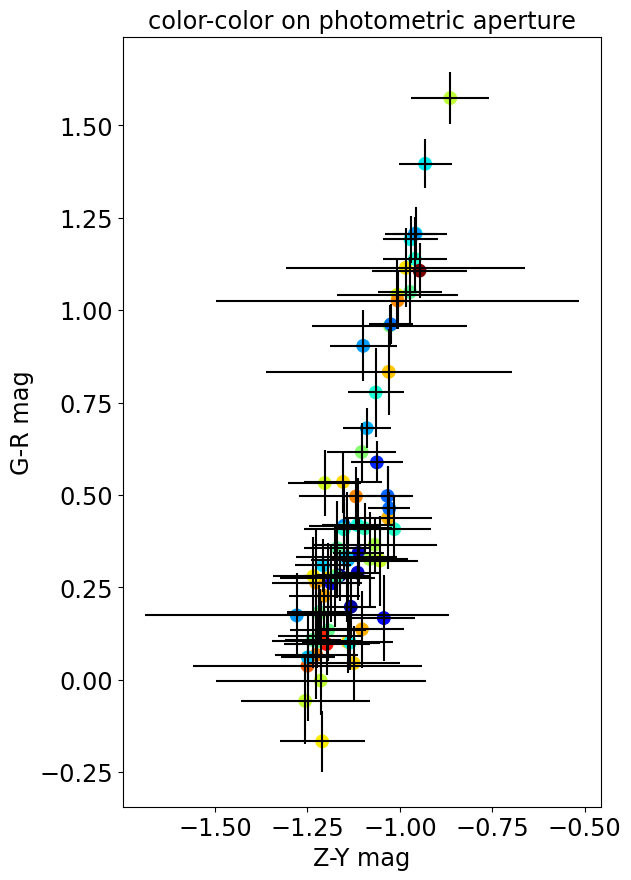

In [24]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.errorbar(df_col_ap["z_y"],df_col_ap["g_r"],xerr=df_col_ap["sig_z_y"] , yerr=df_col_ap["sig_g_r"], fmt=".",color='k',ecolor='k',markersize=1) 
df_col_ap.plot.scatter(x="z_y", y="g_r",marker= "o", s=80,c="sy",cmap="jet",ax=ax,colorbar=True)
ax.set_xlabel("Z-Y (mag)")
ax.set_ylabel("G-R (mag)")
ax.set_title("color-color on aperture photometry")
ax.set_aspect("equal")
#ax.grid()
plt.show()

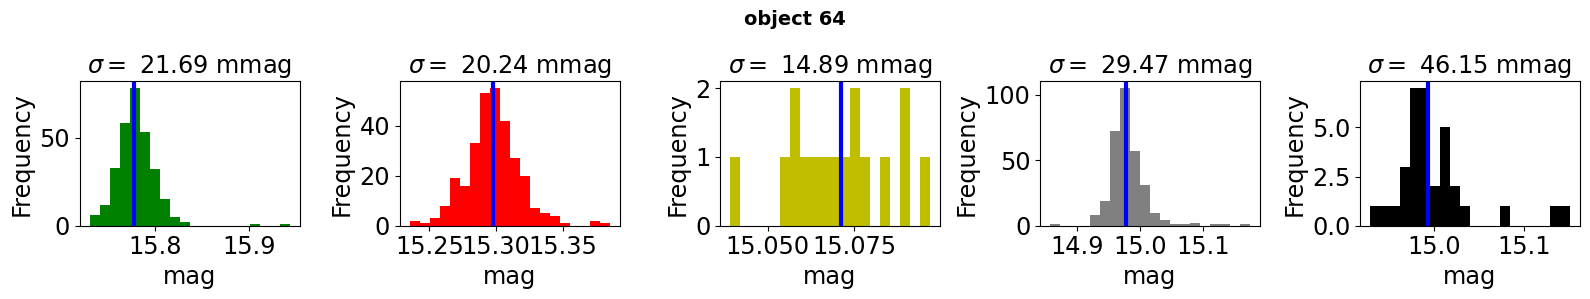

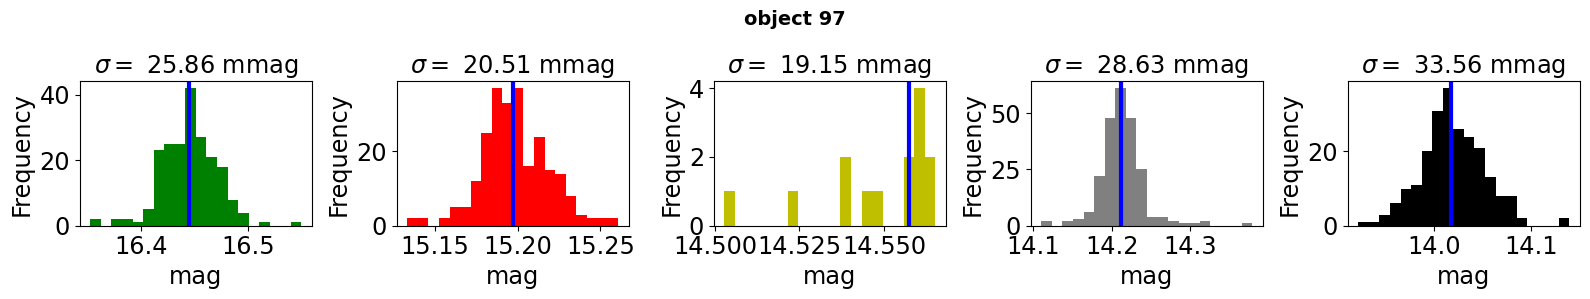

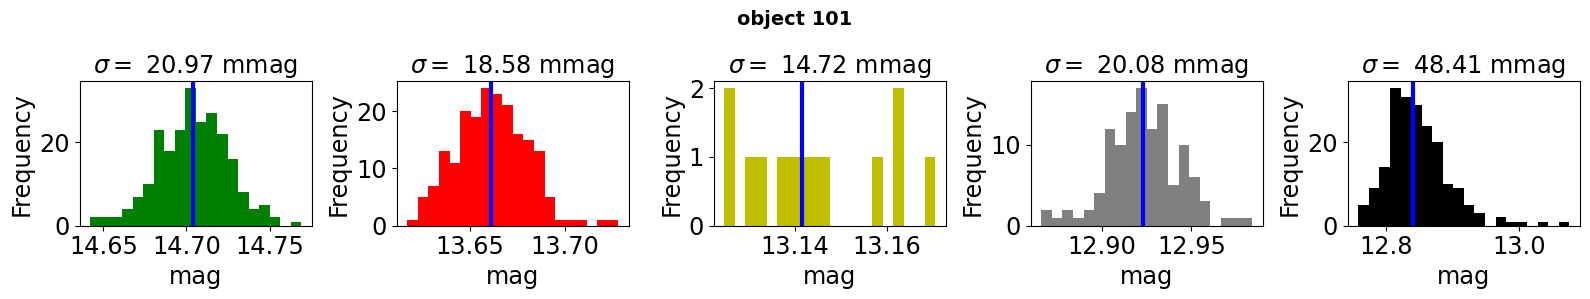

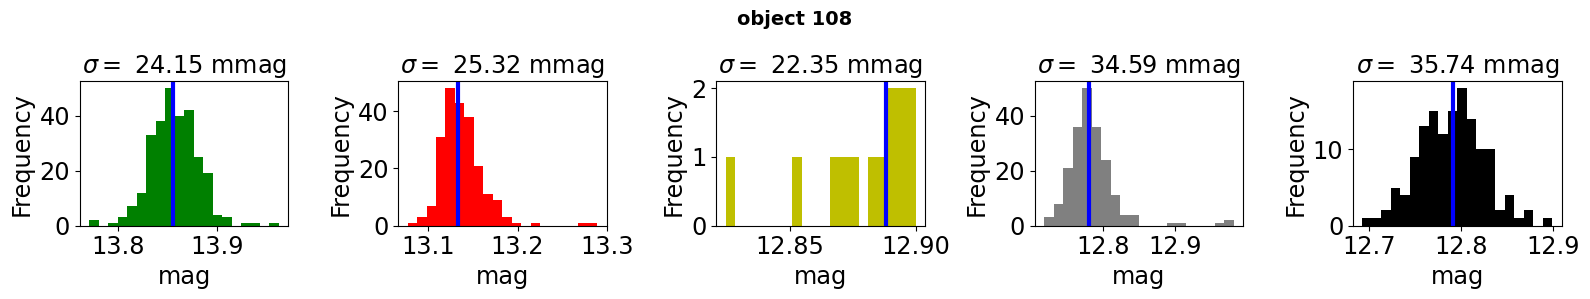

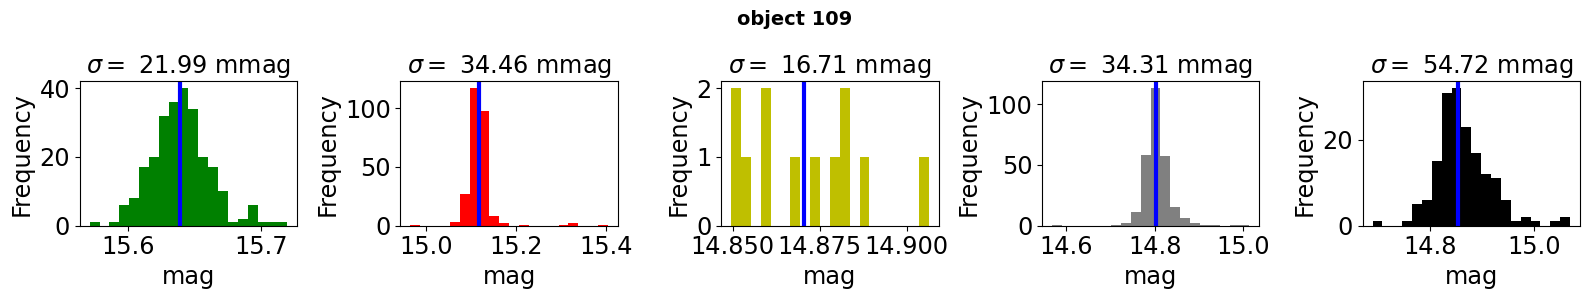

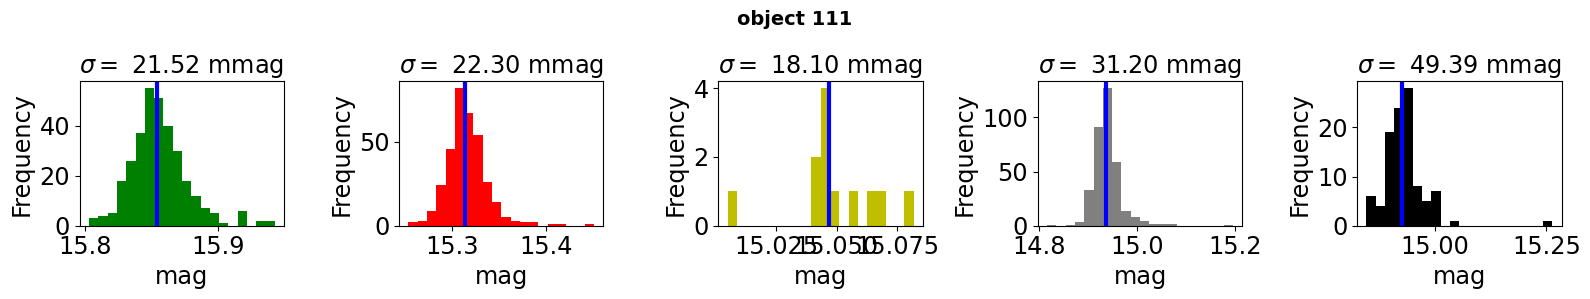

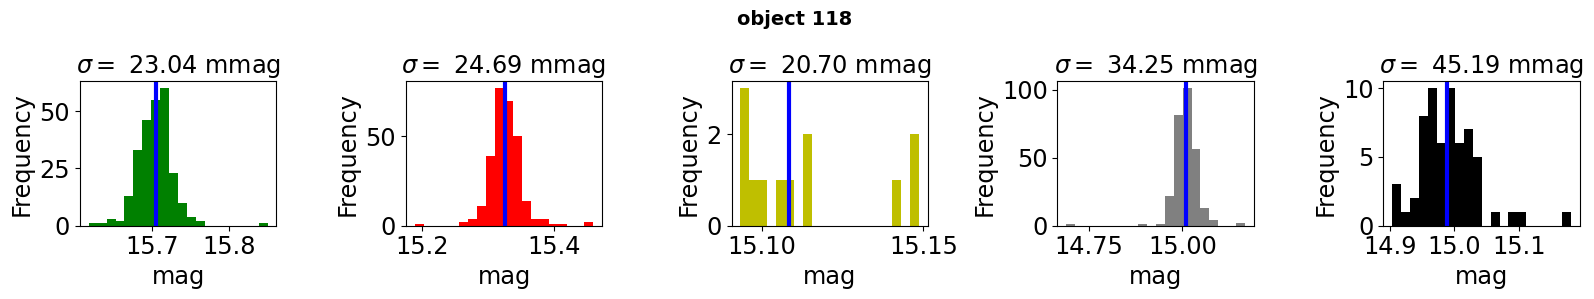

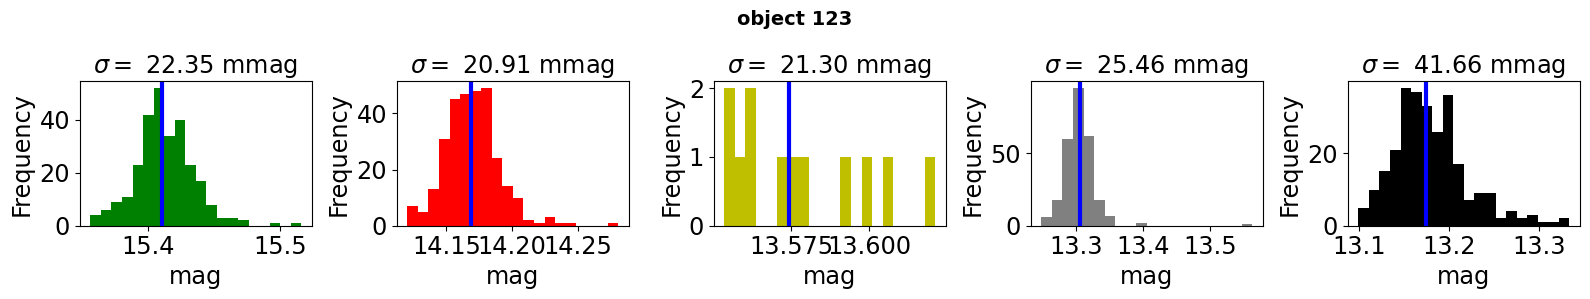

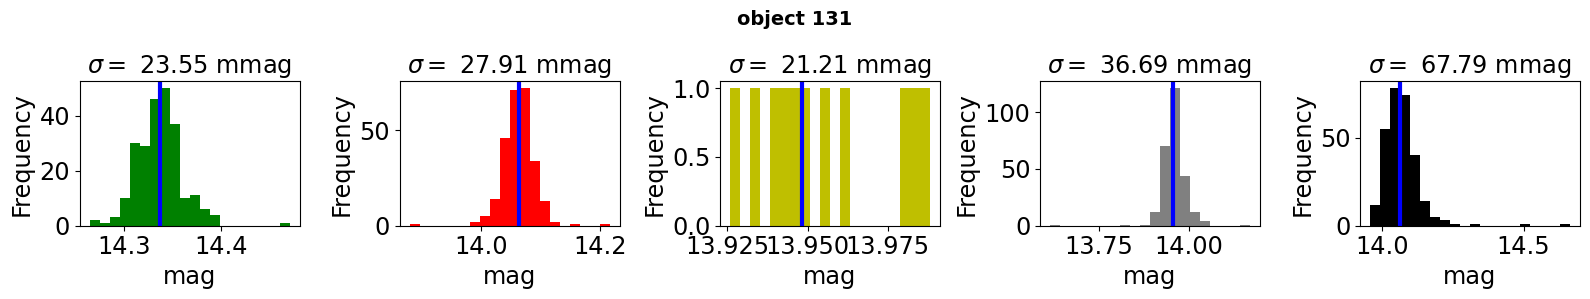

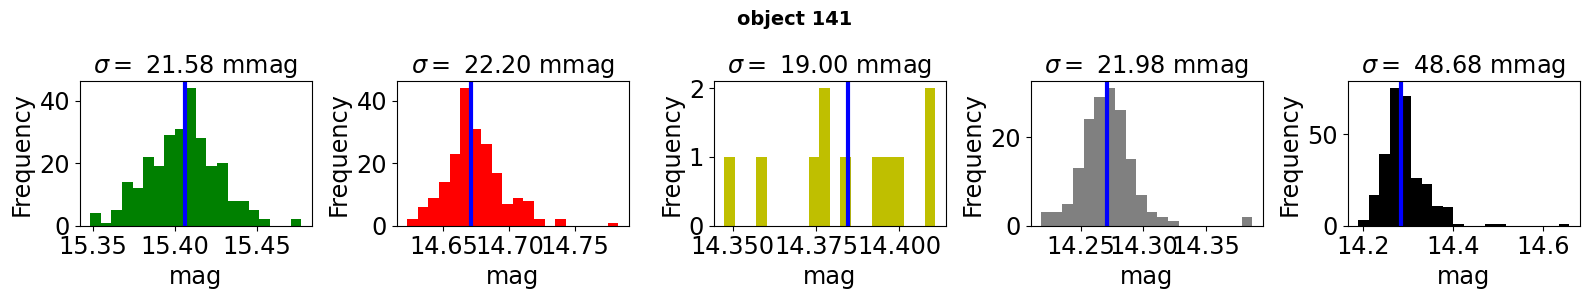

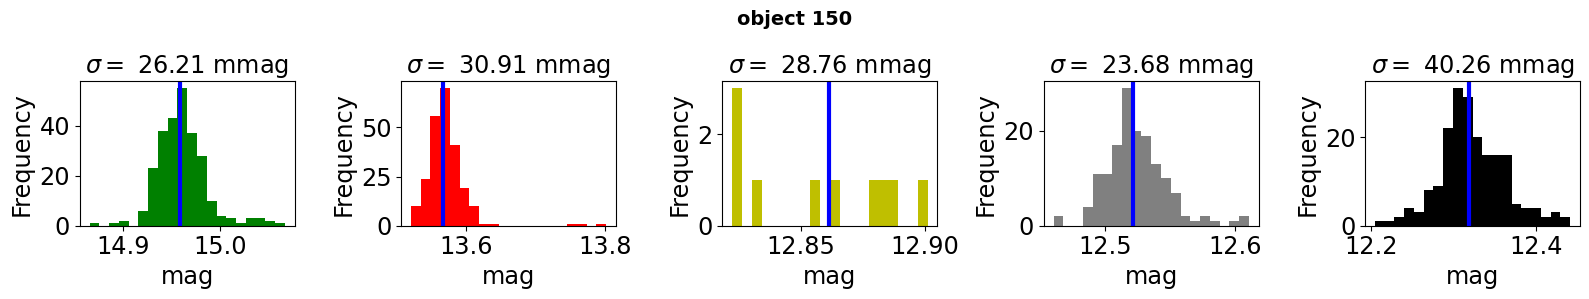

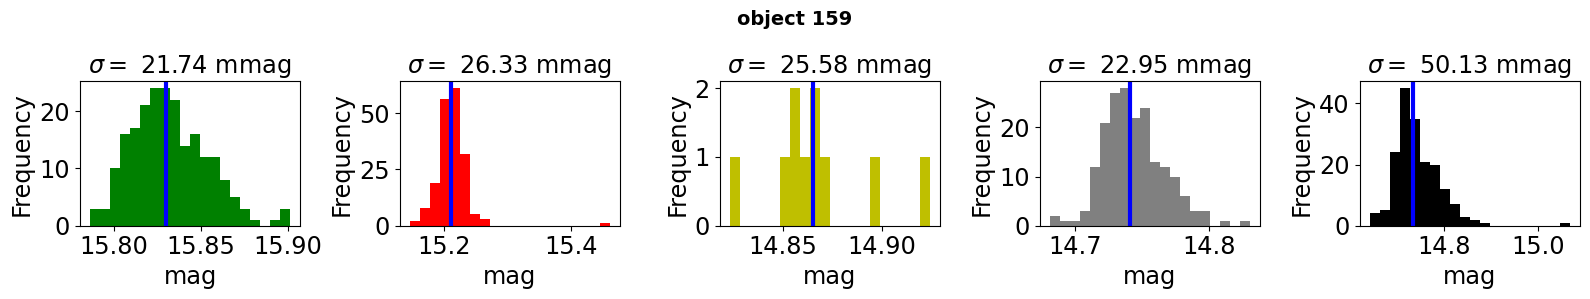

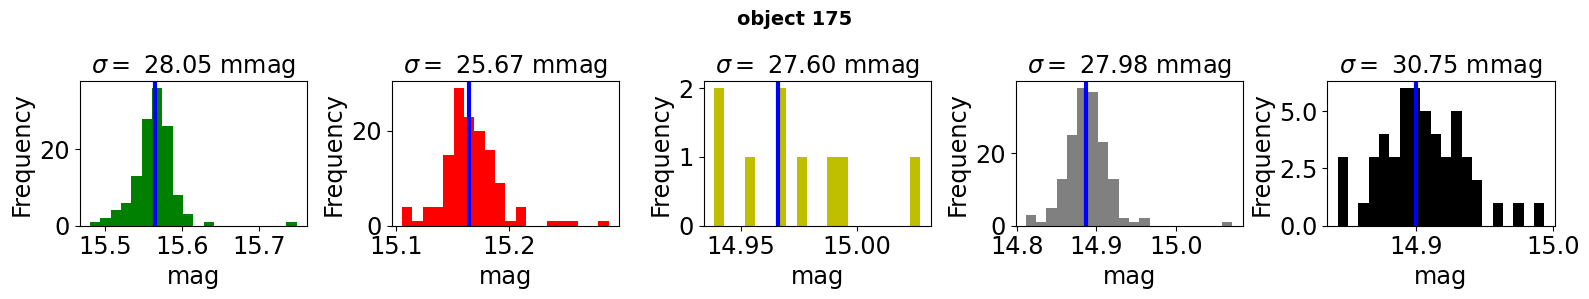

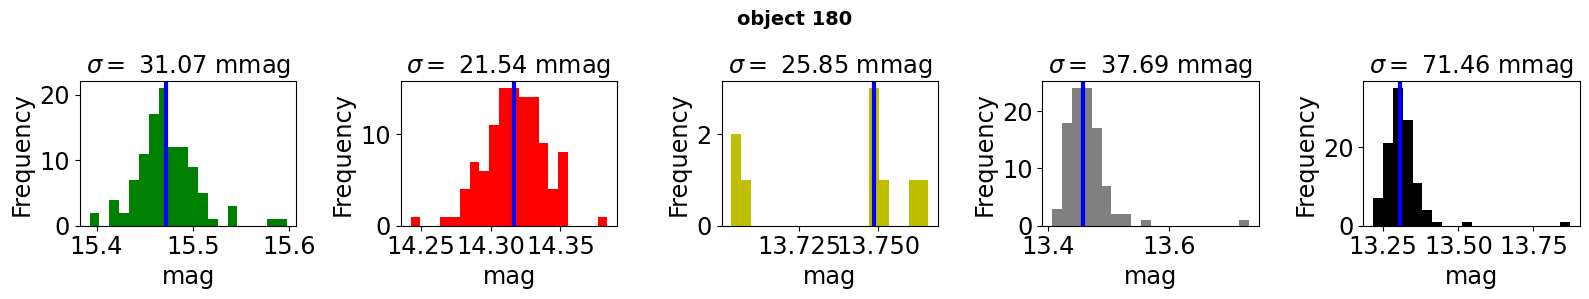

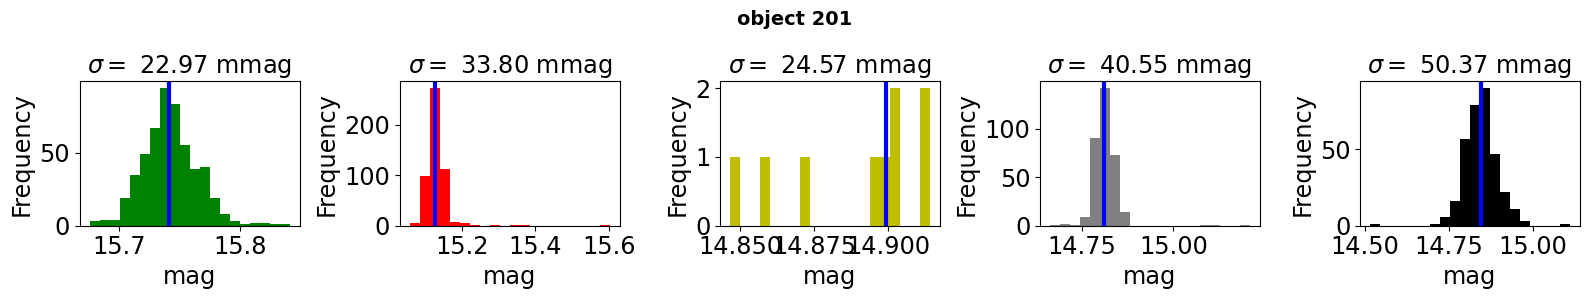

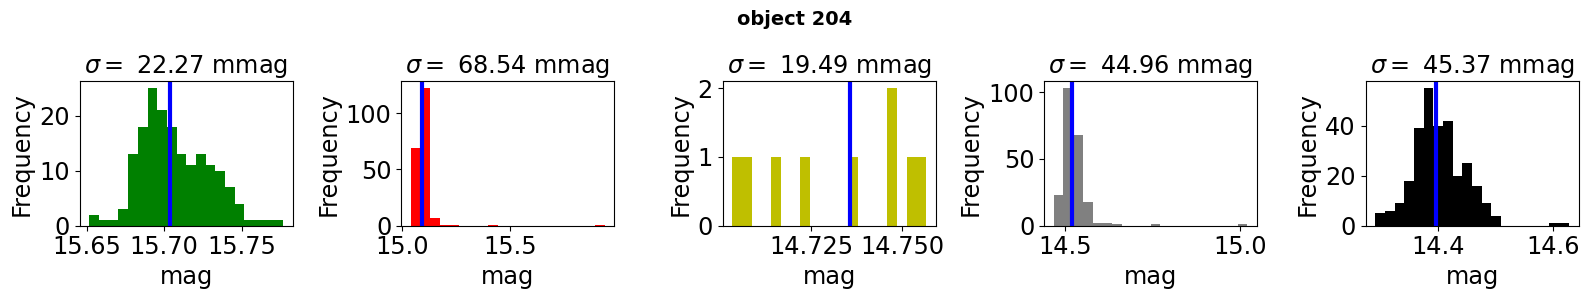

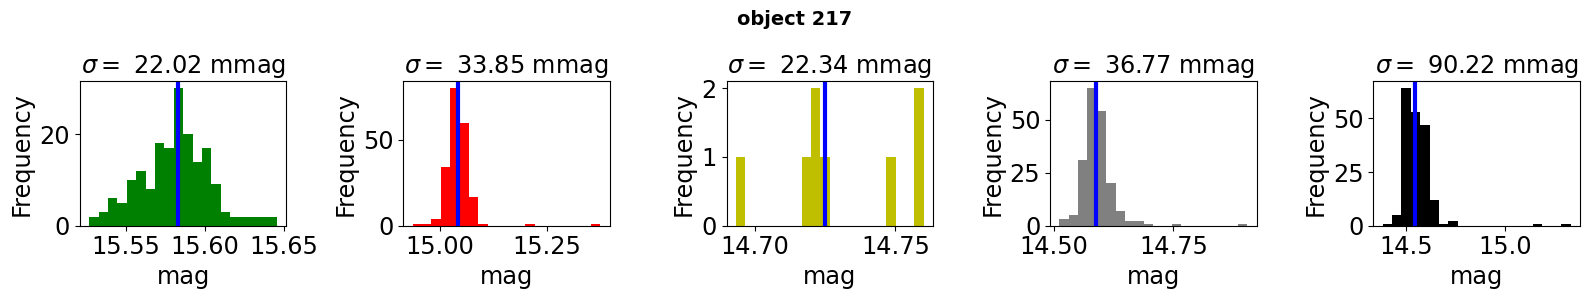

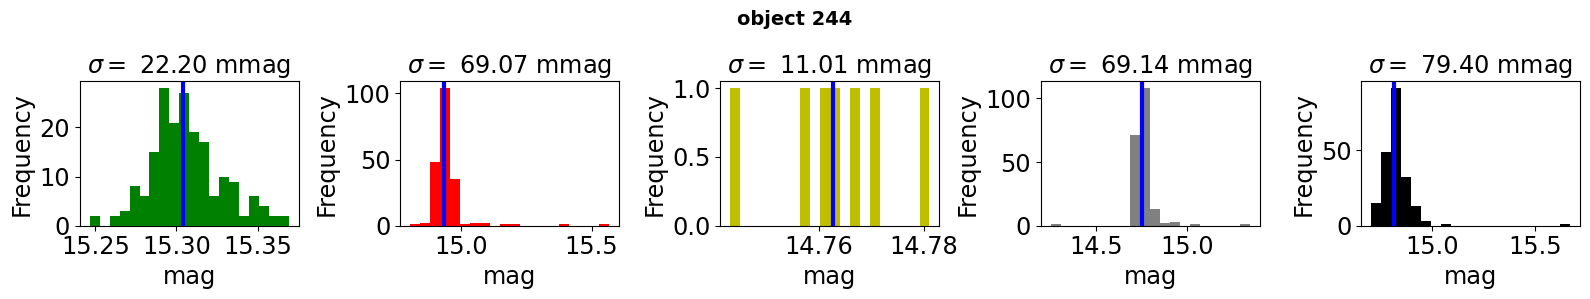

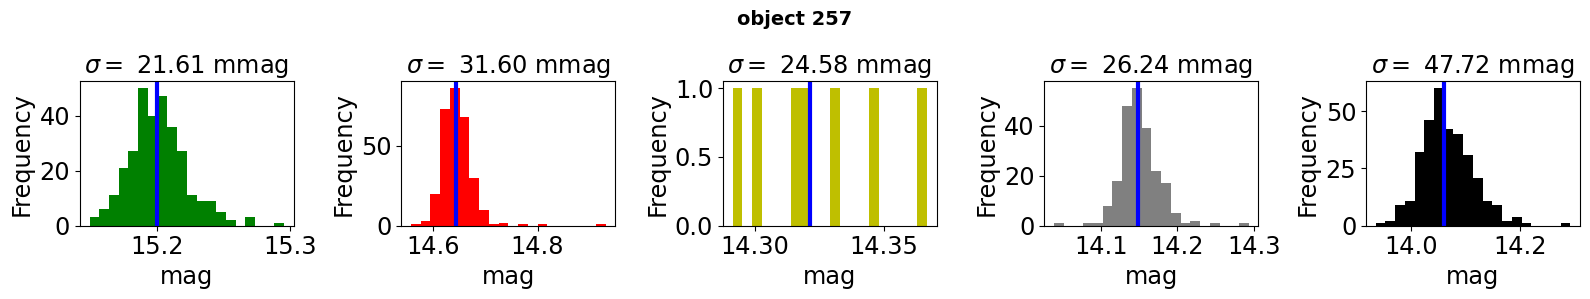

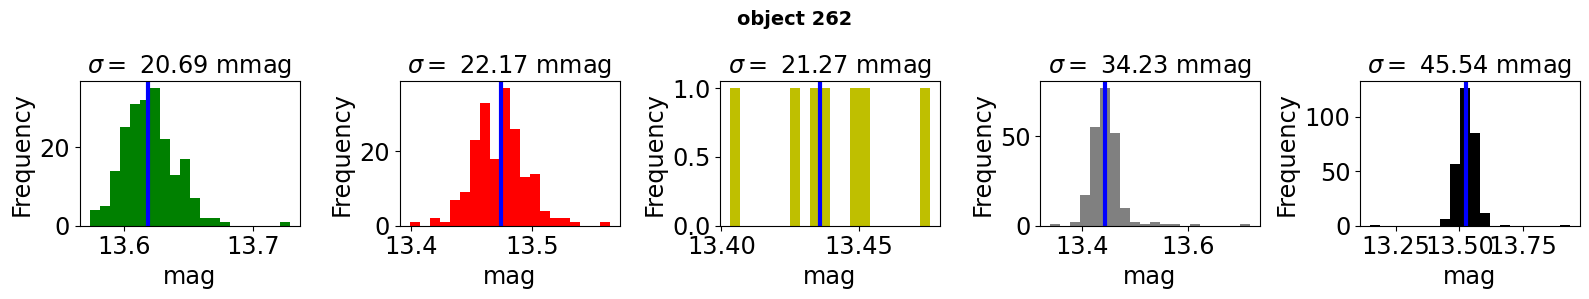

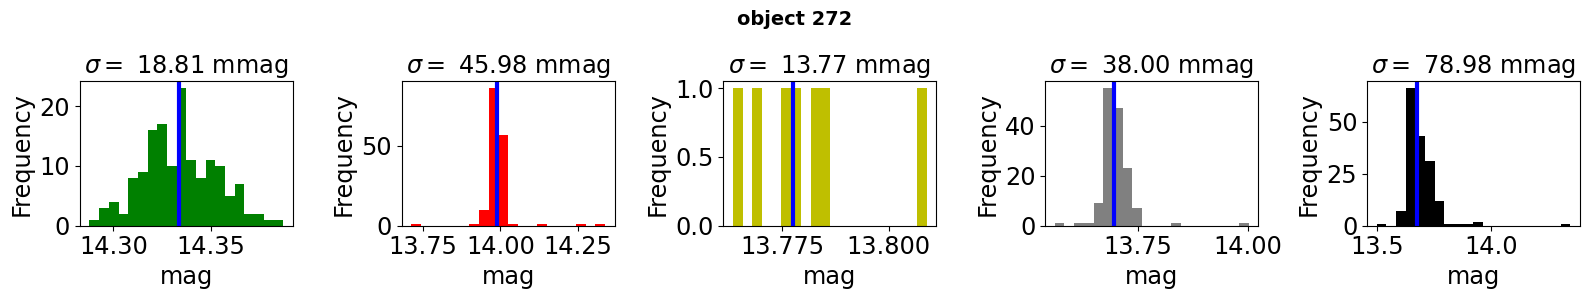

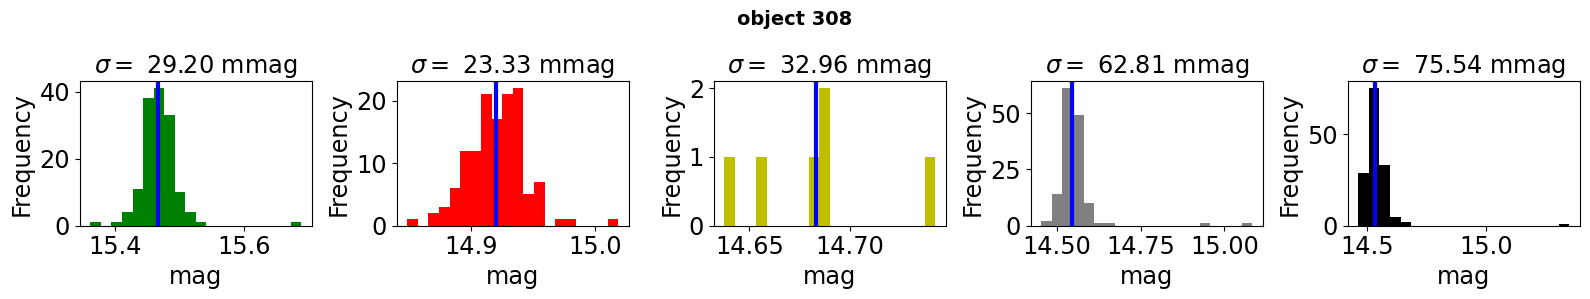

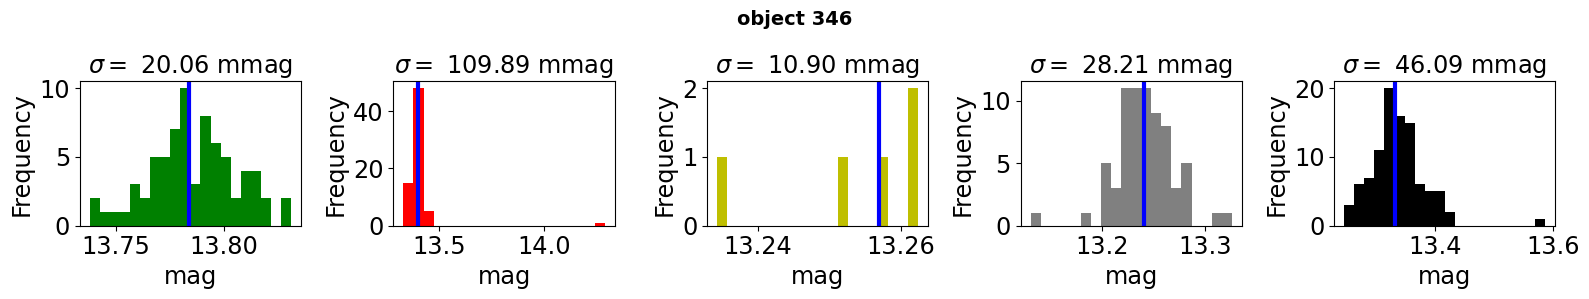

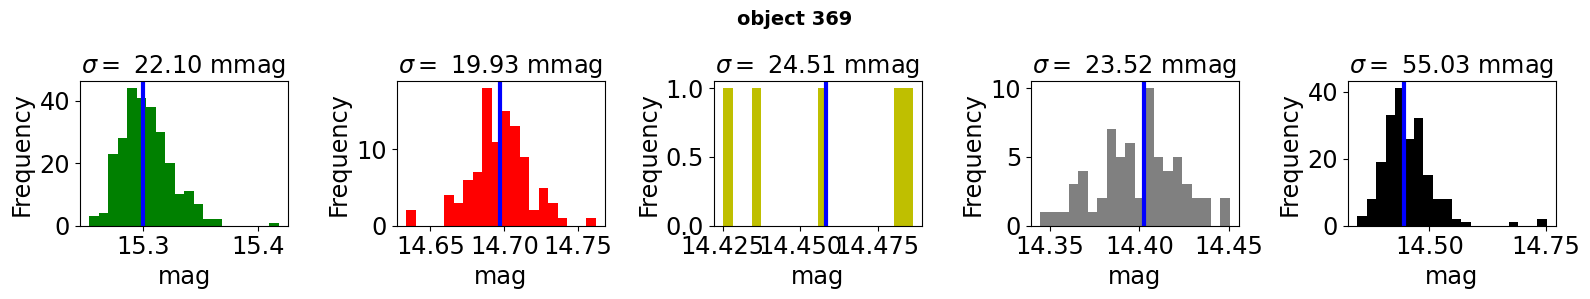

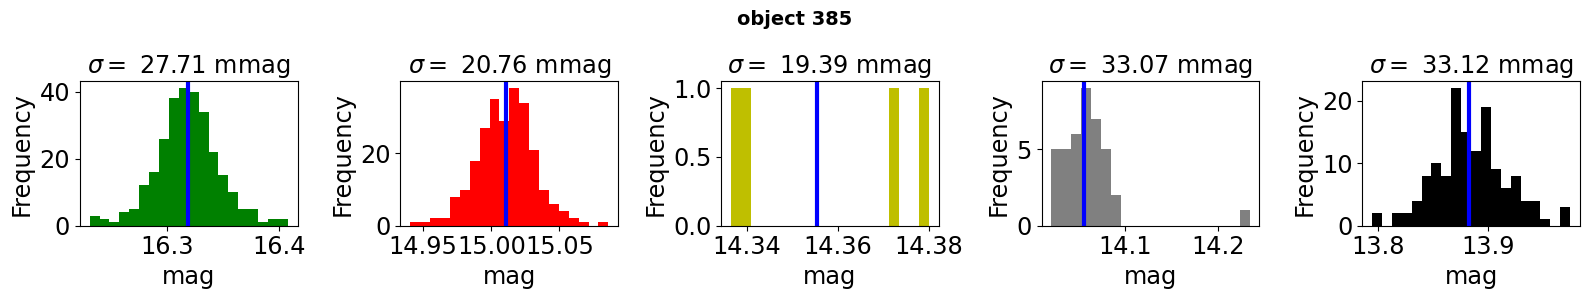

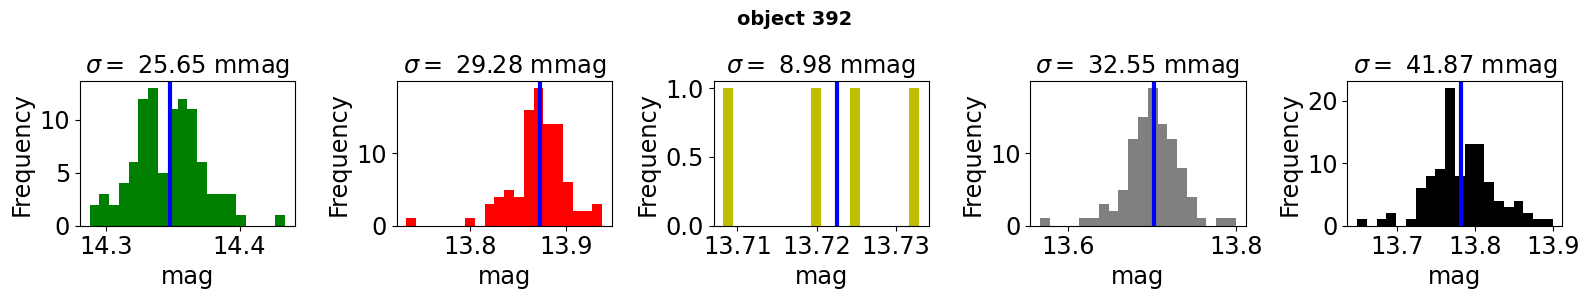

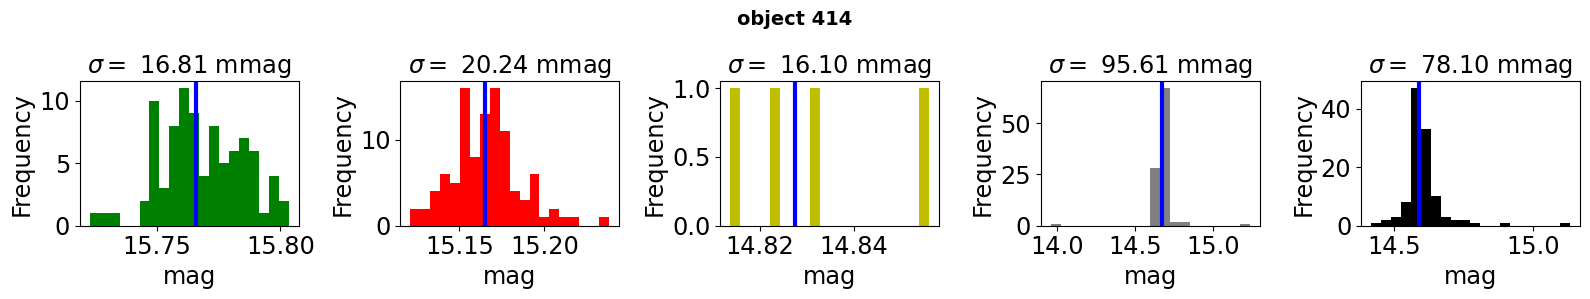

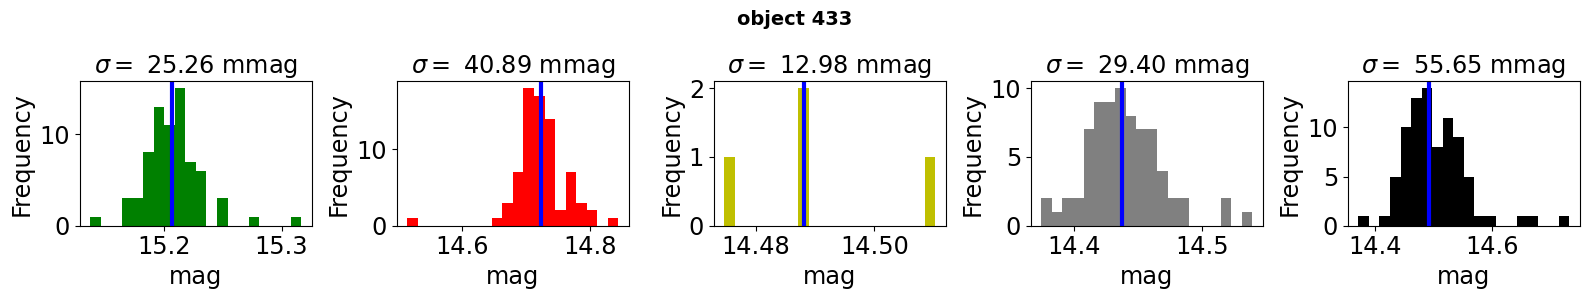

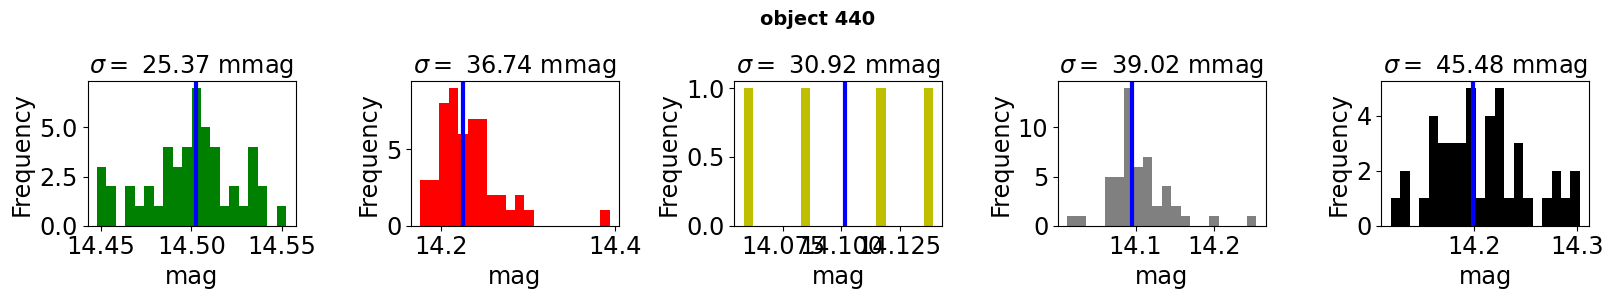

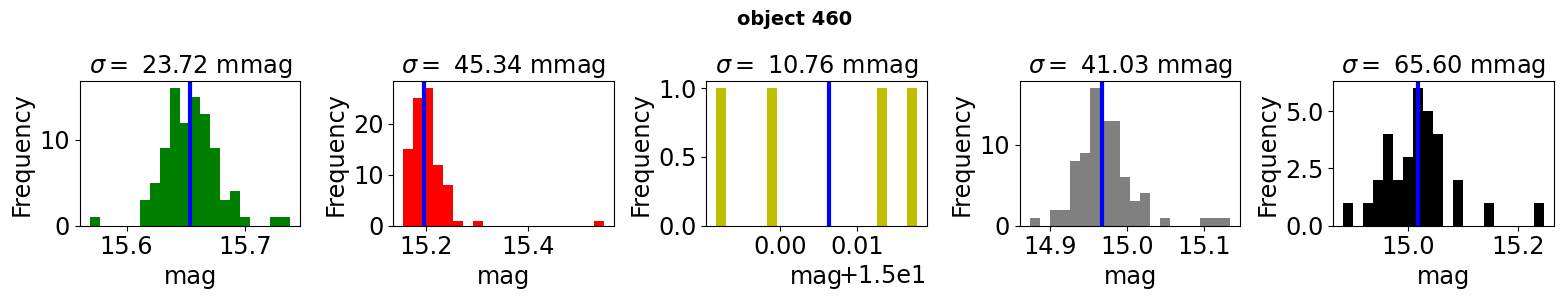

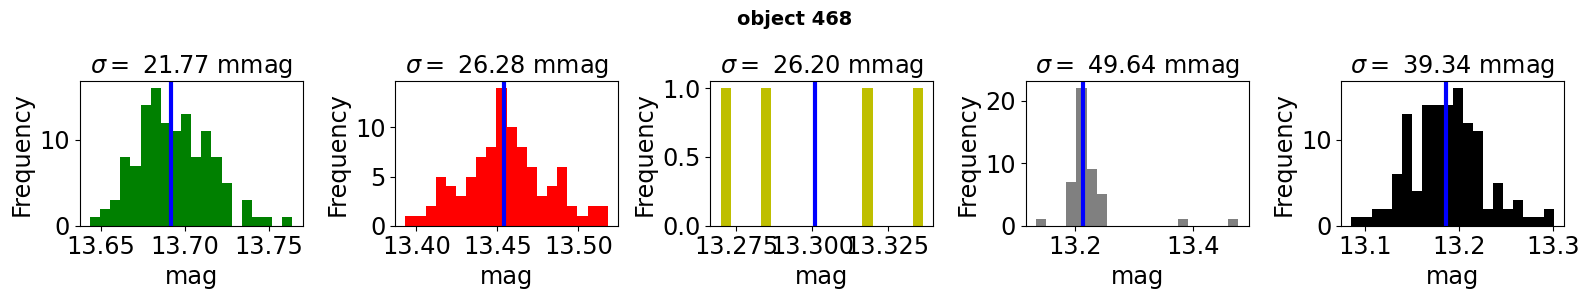

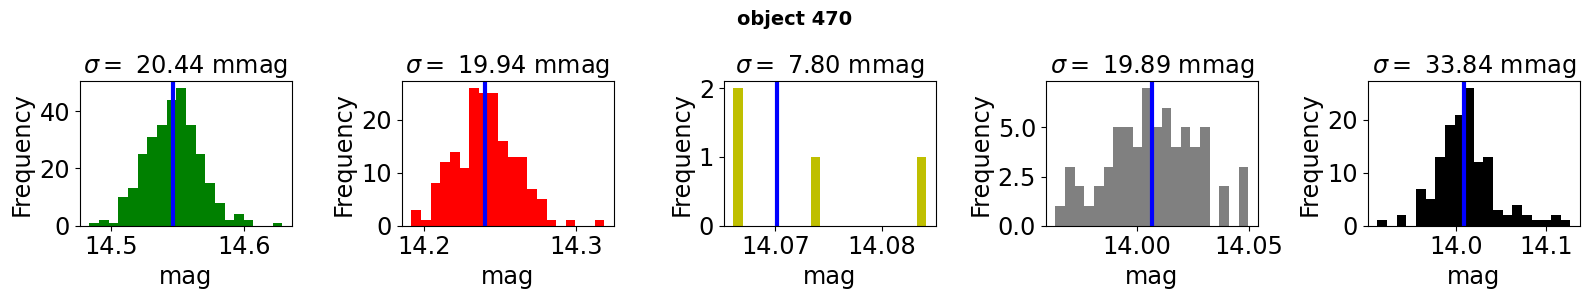

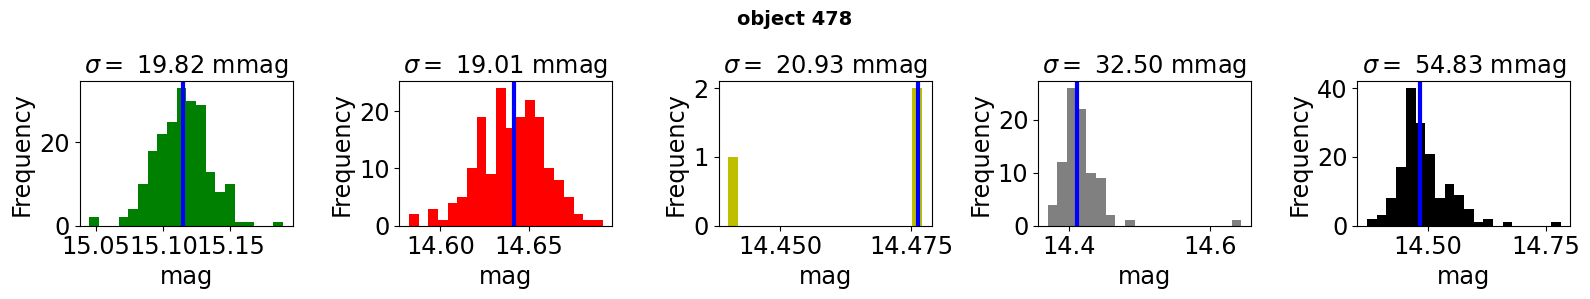

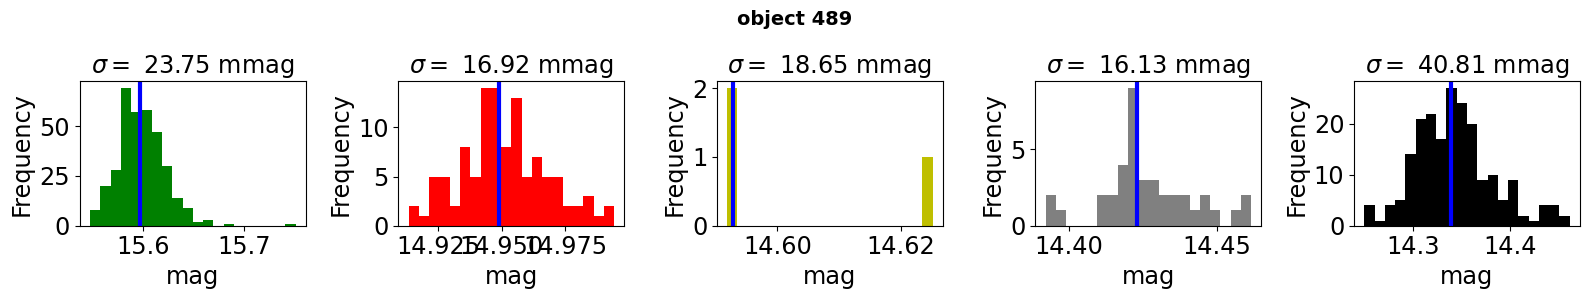

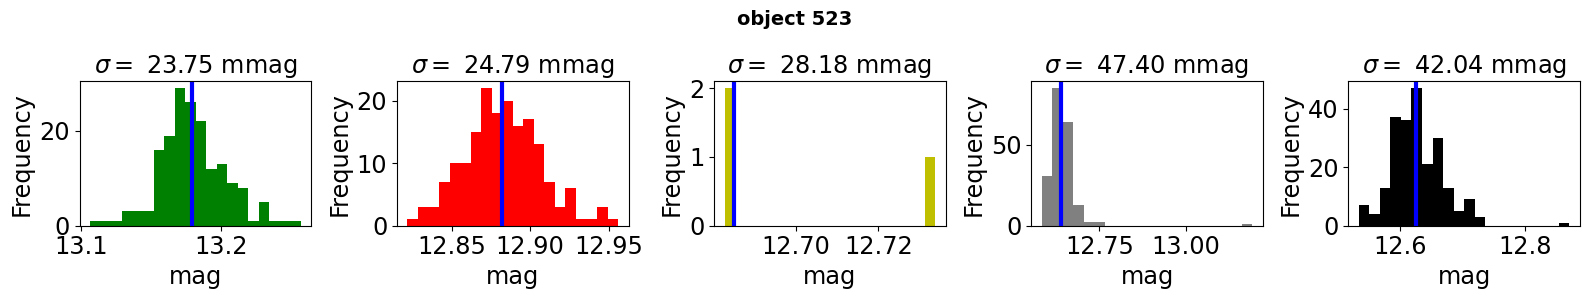

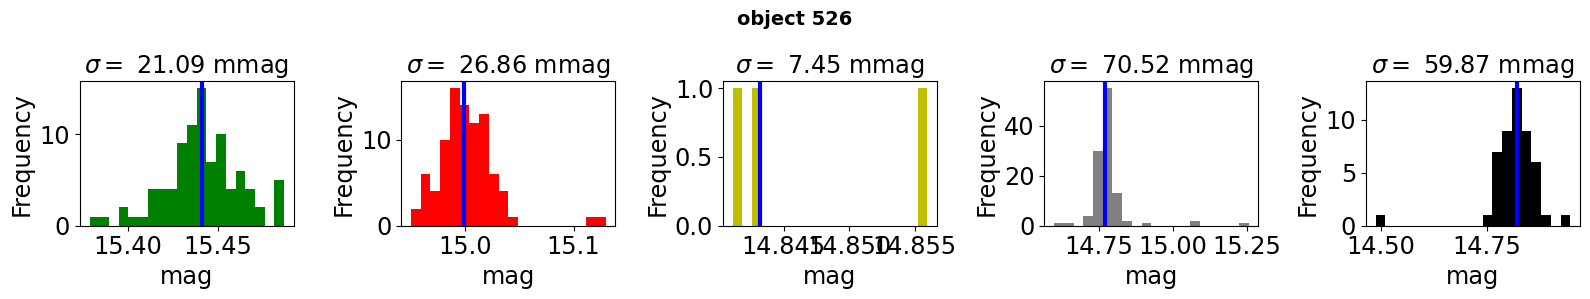

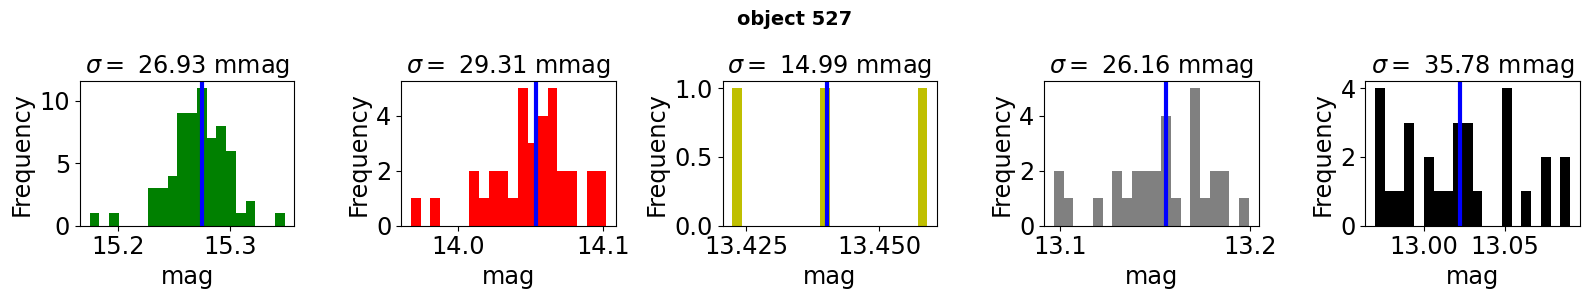

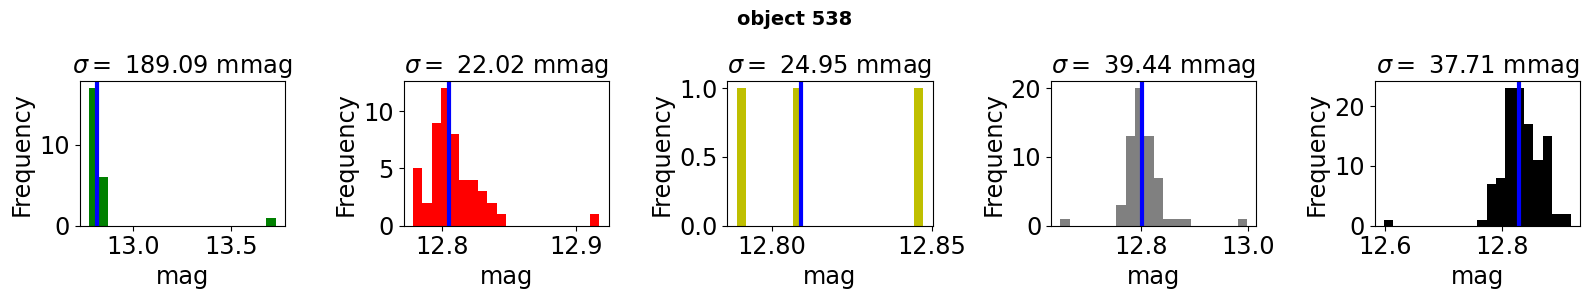

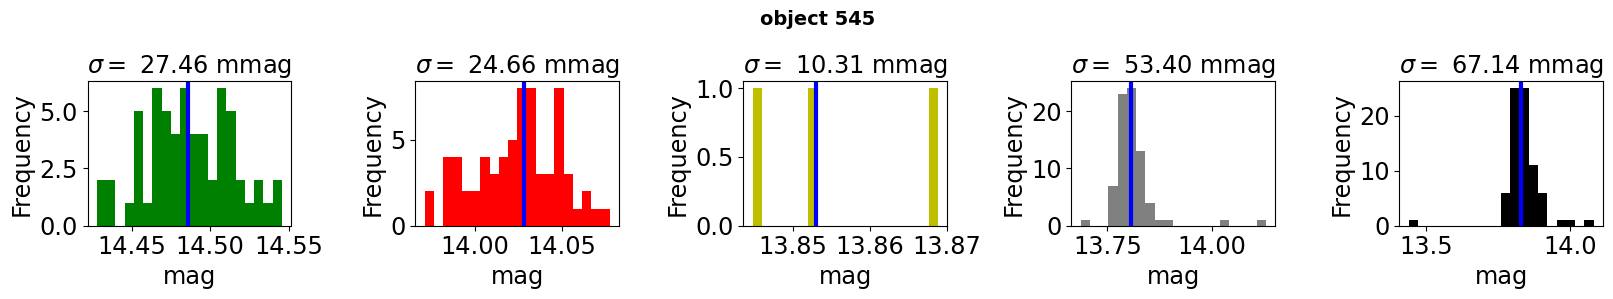

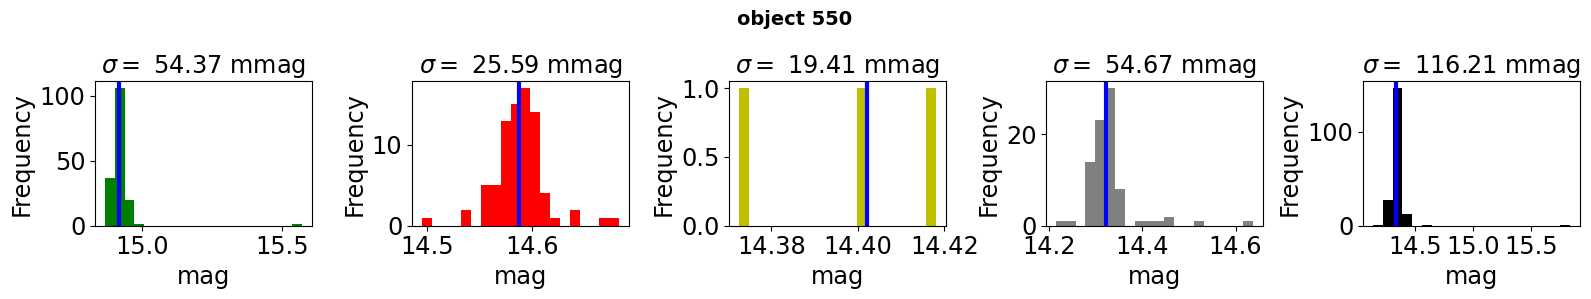

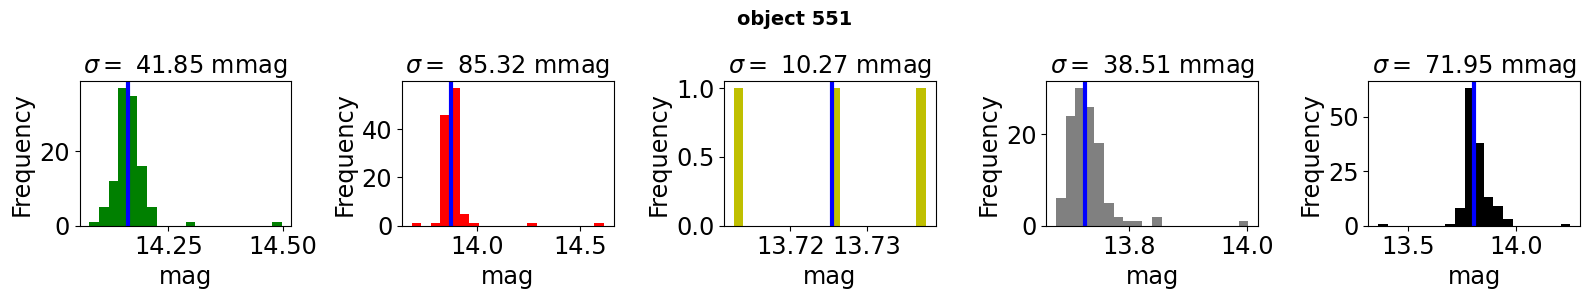

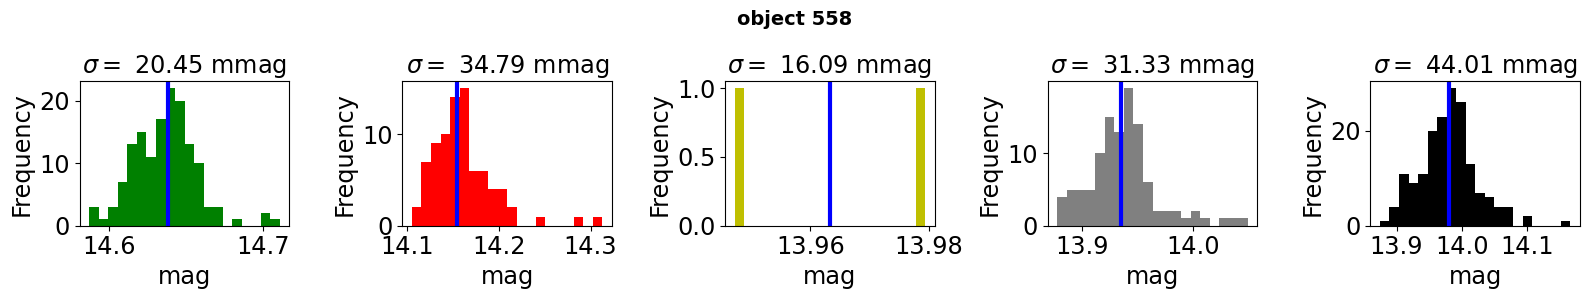

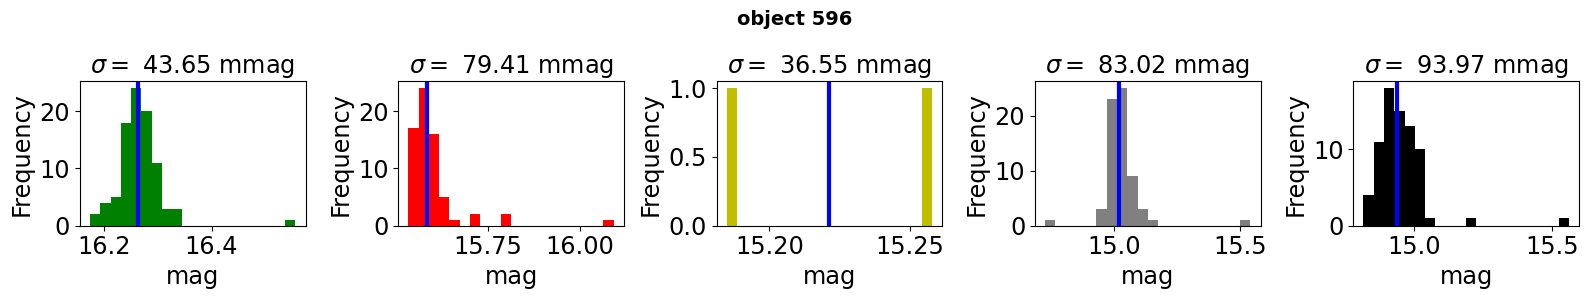

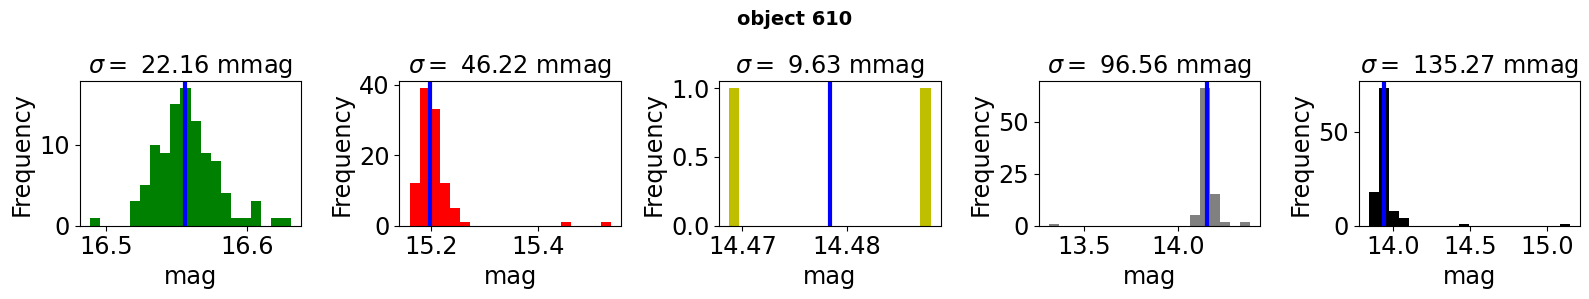

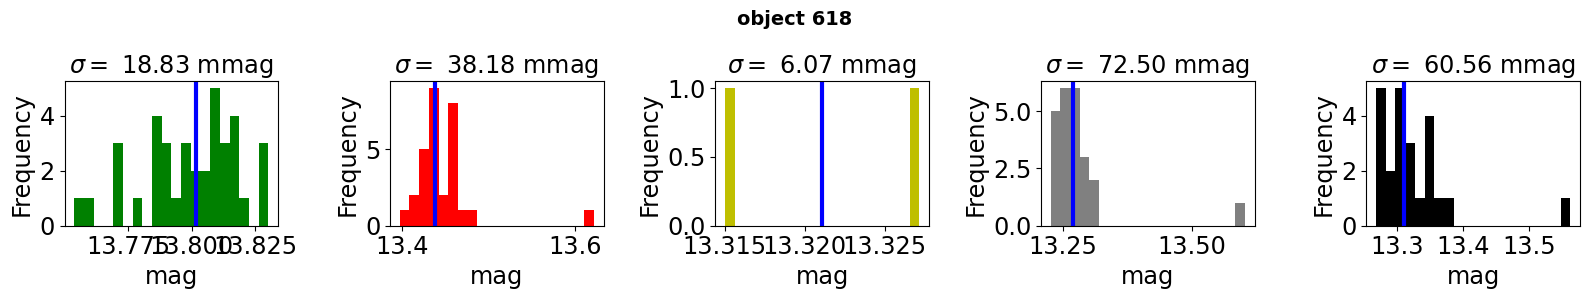

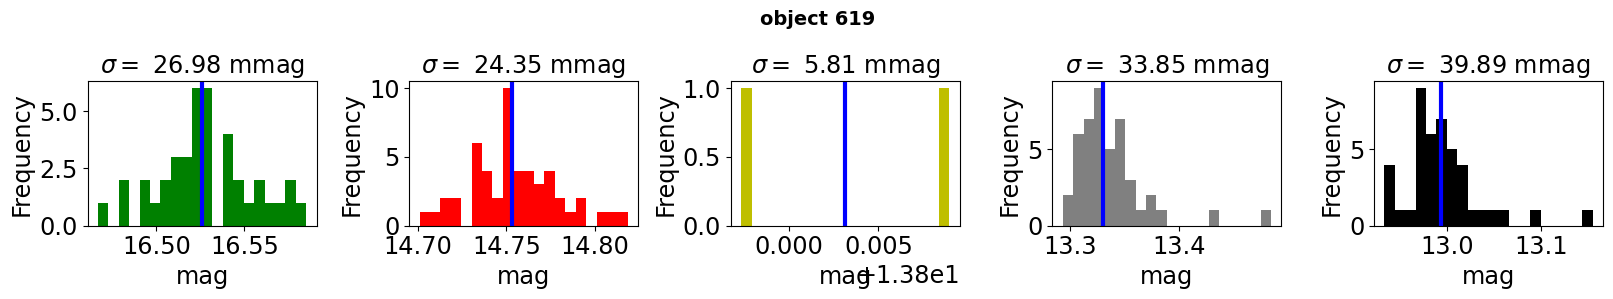

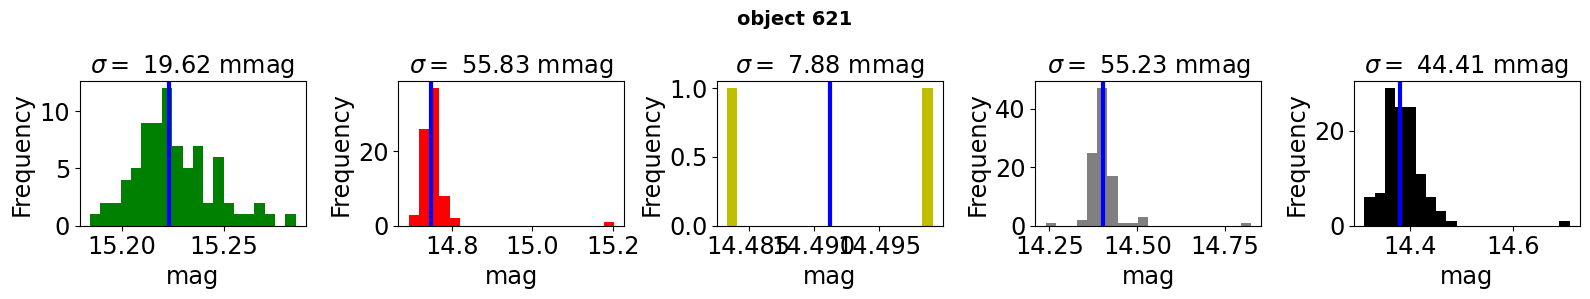

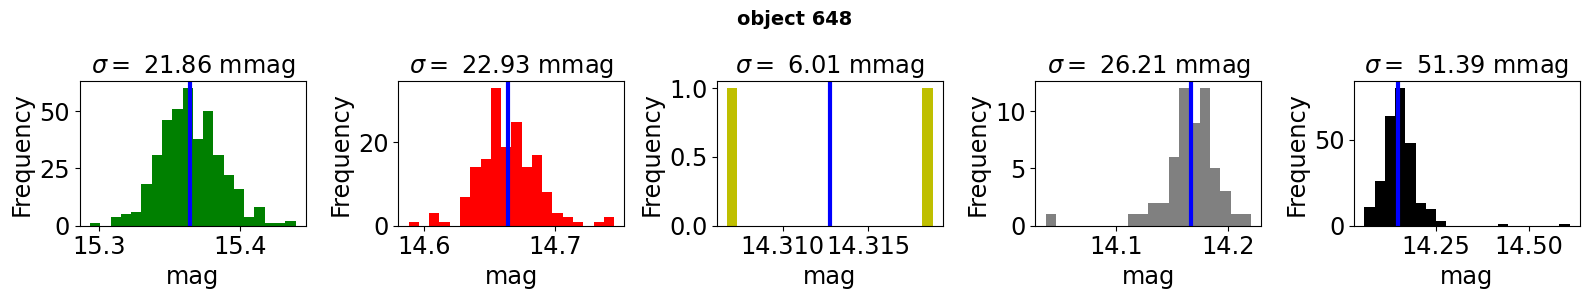

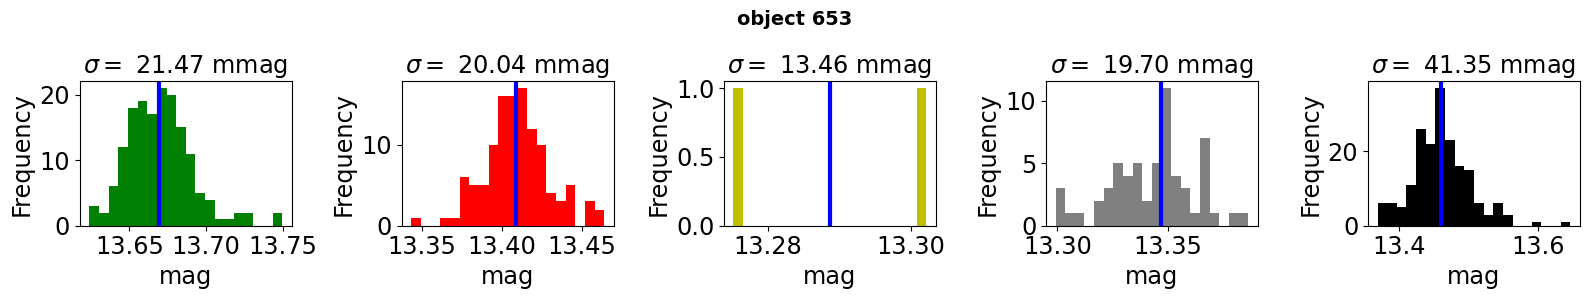

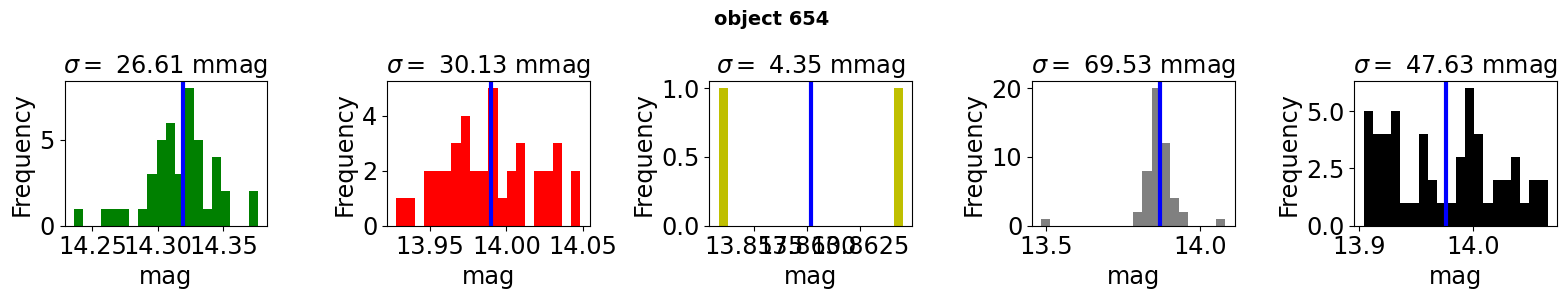

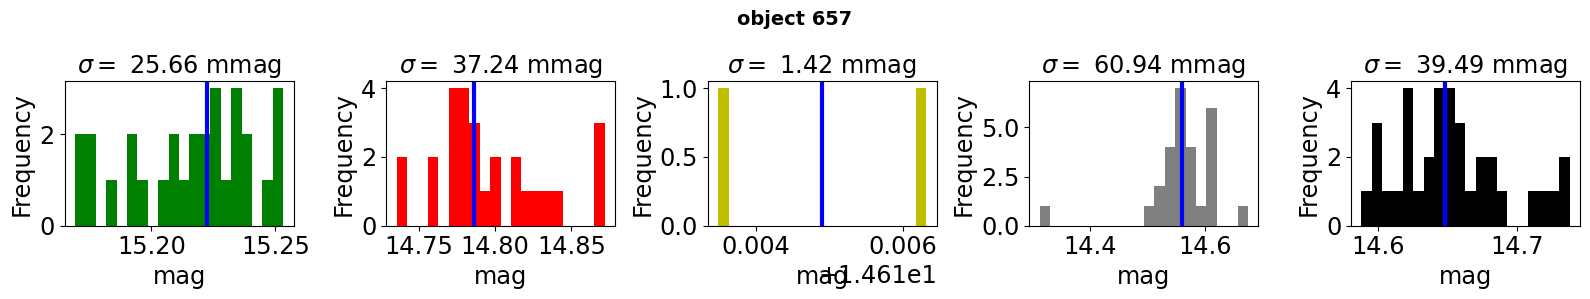

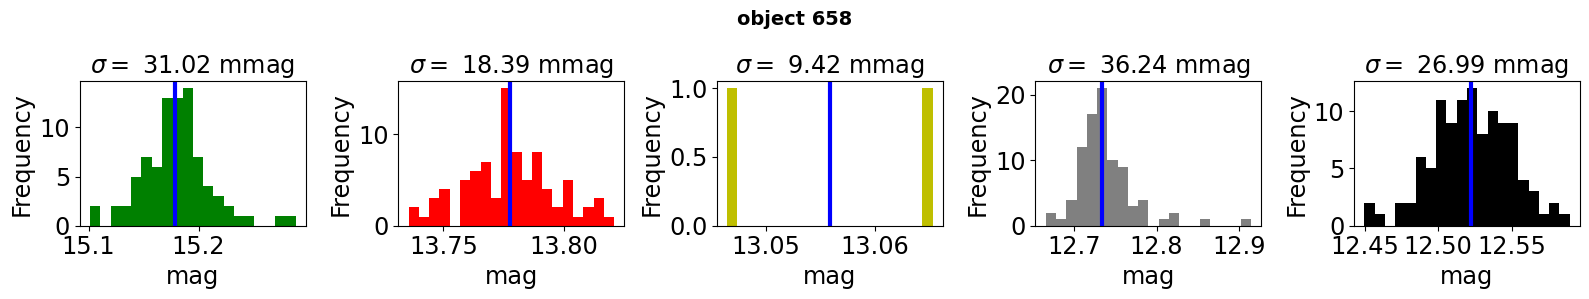

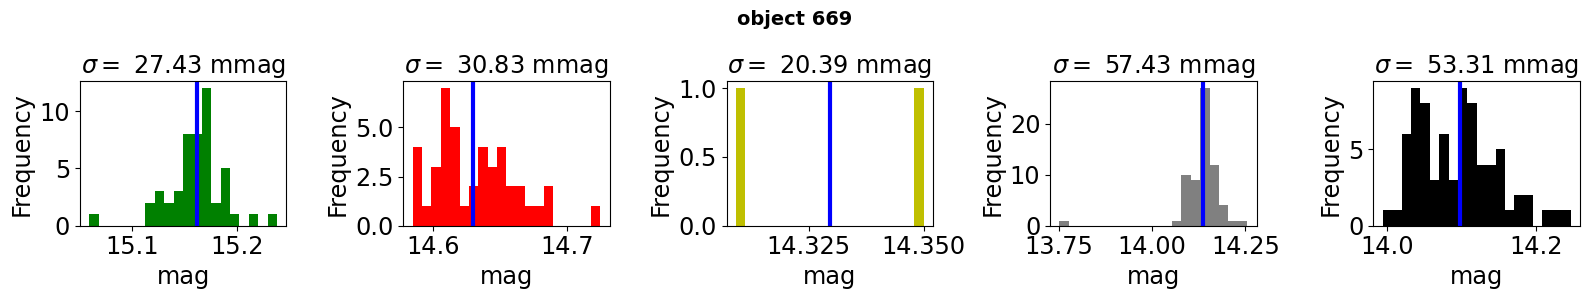

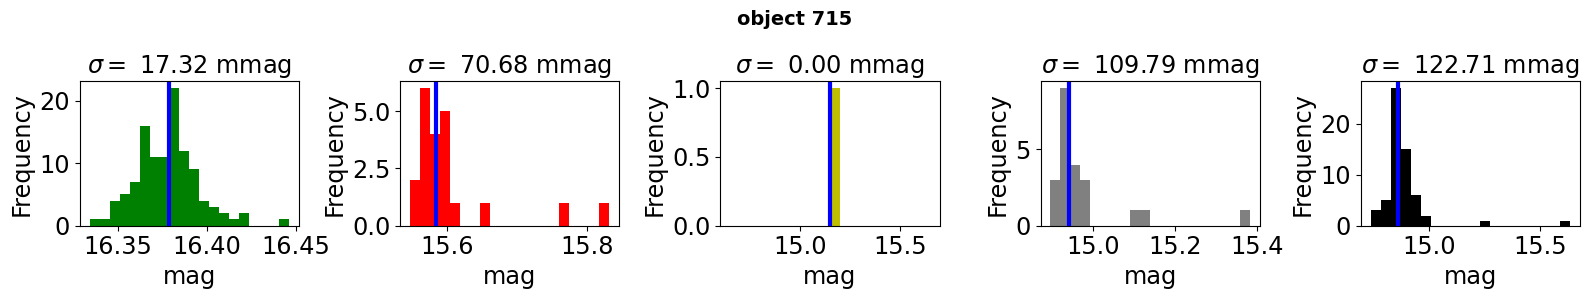

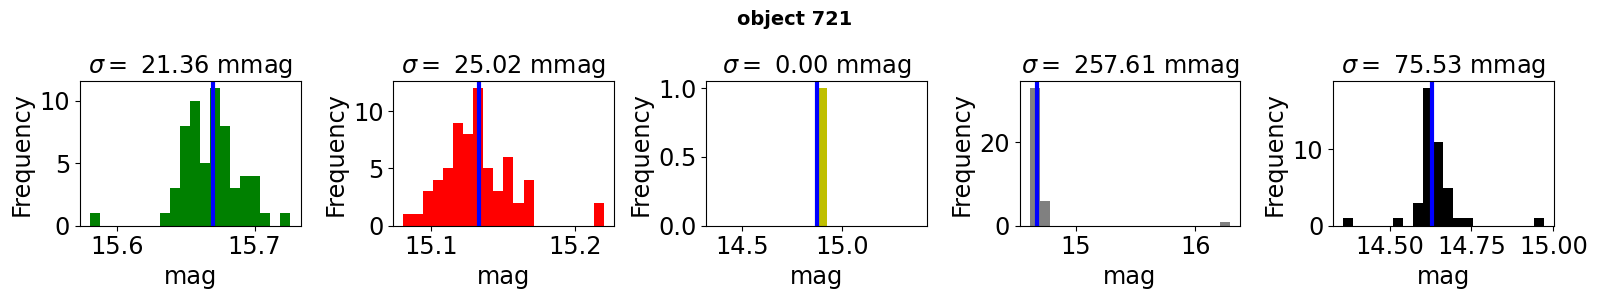

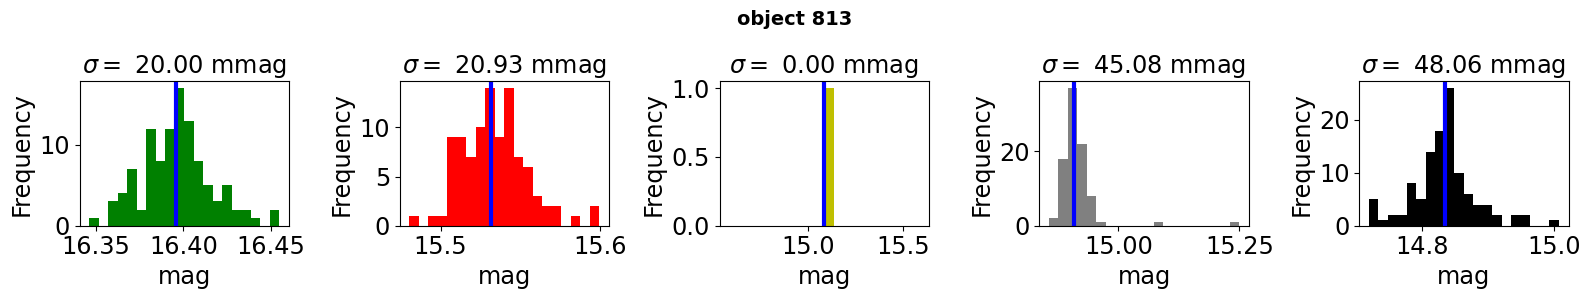

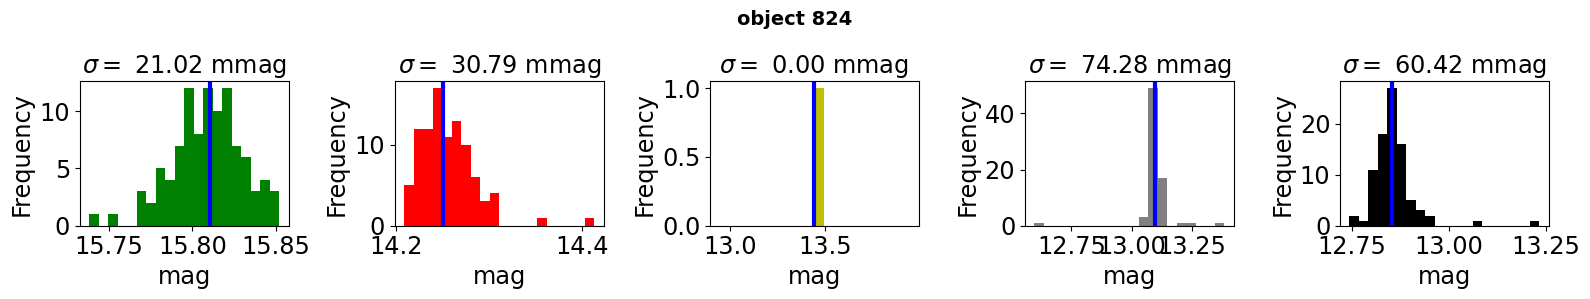

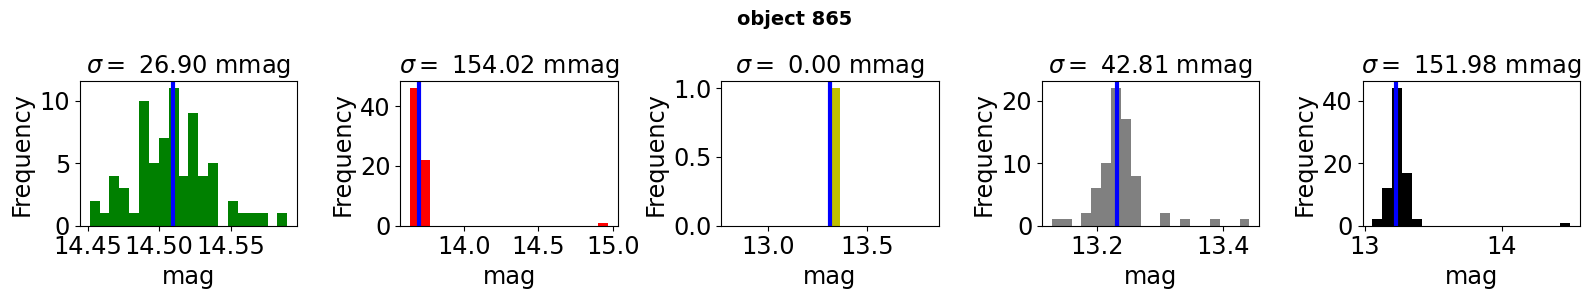

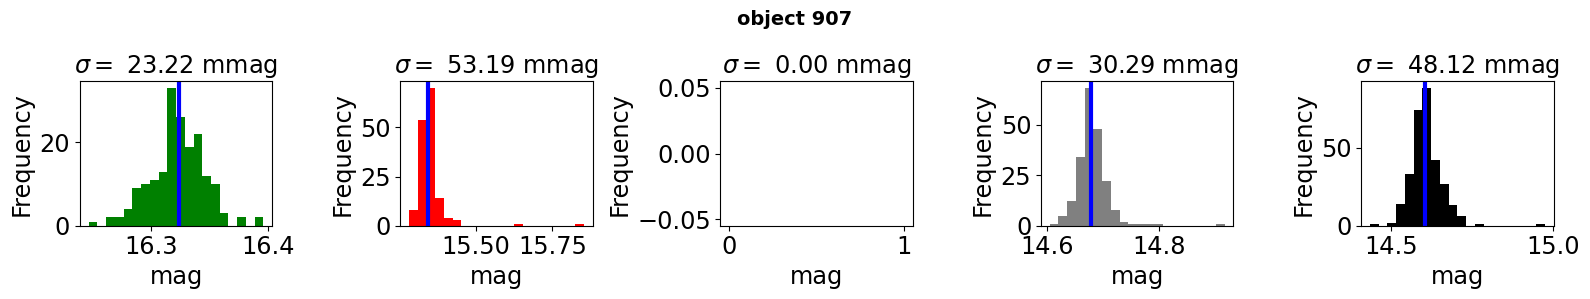

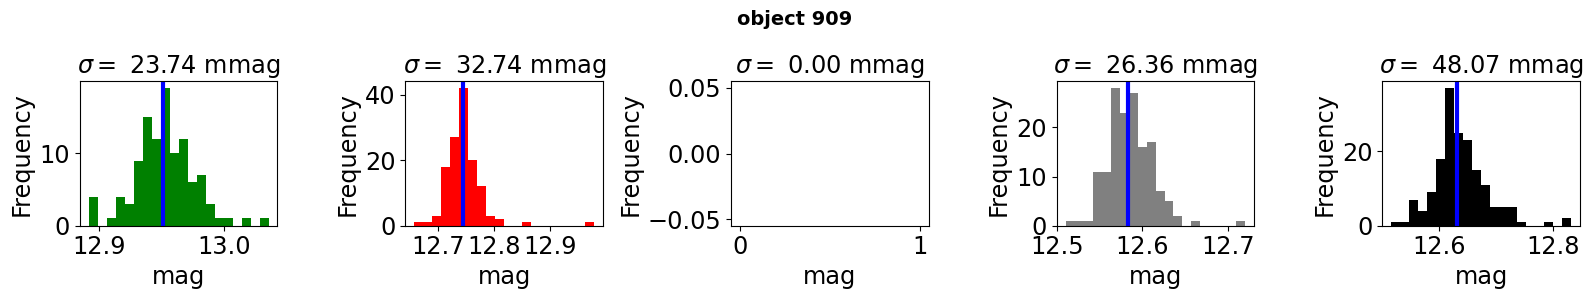

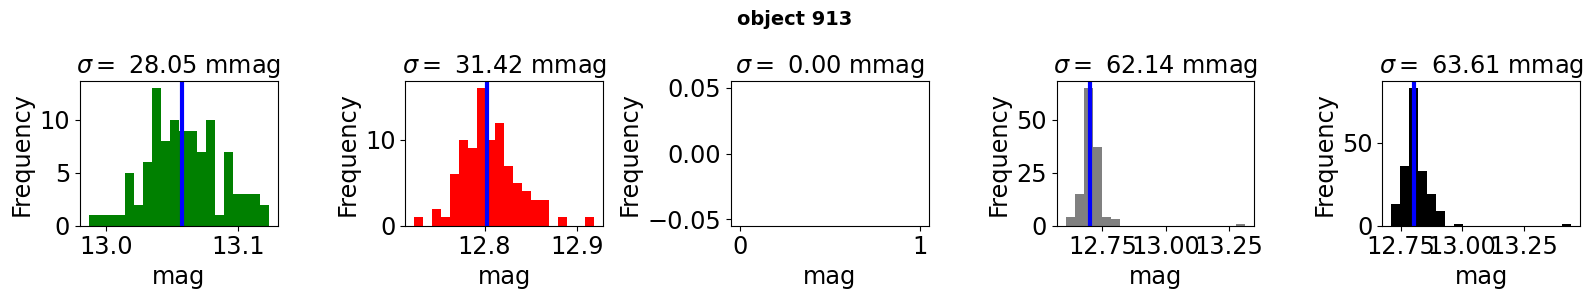

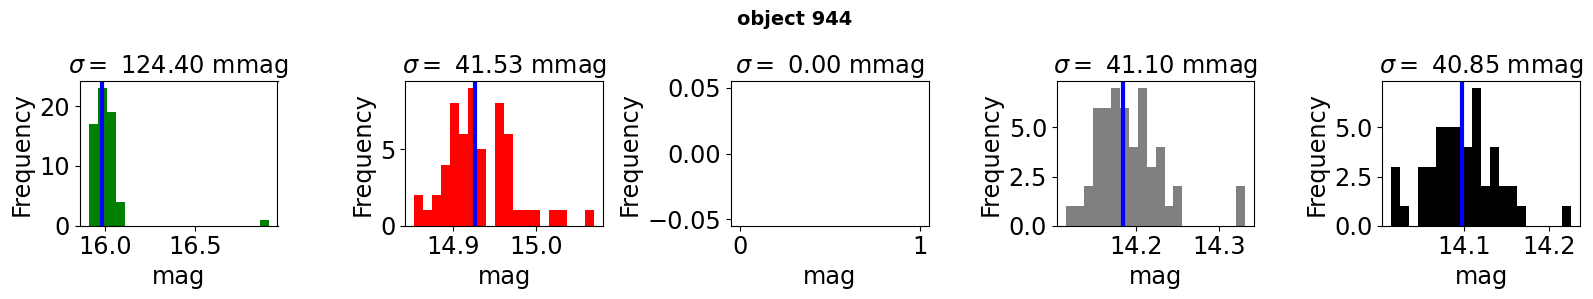

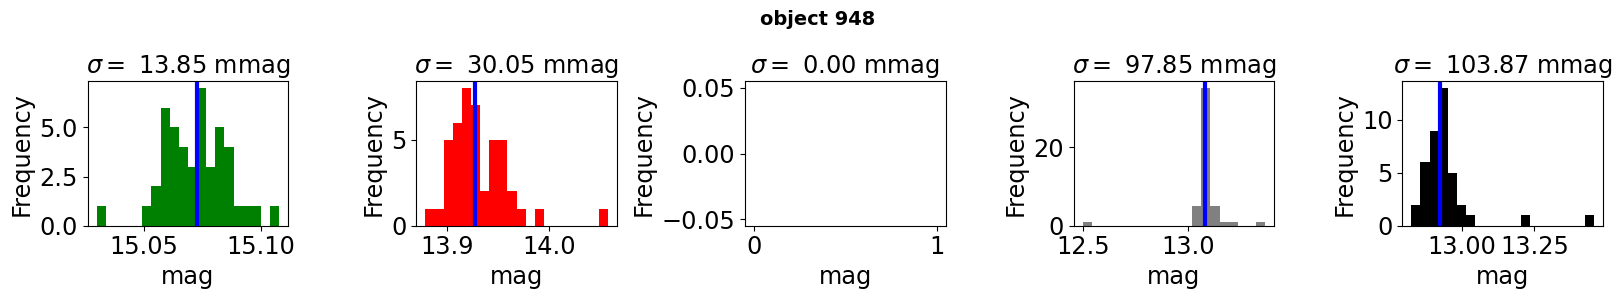

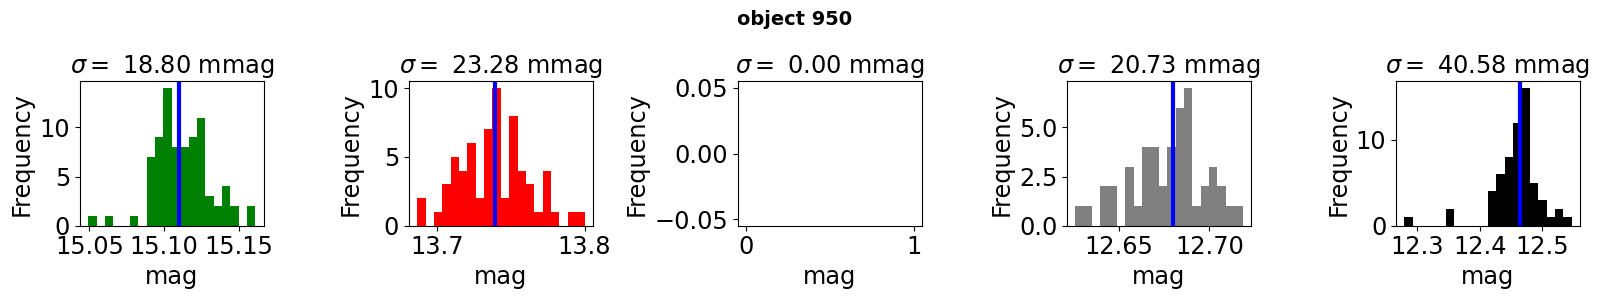

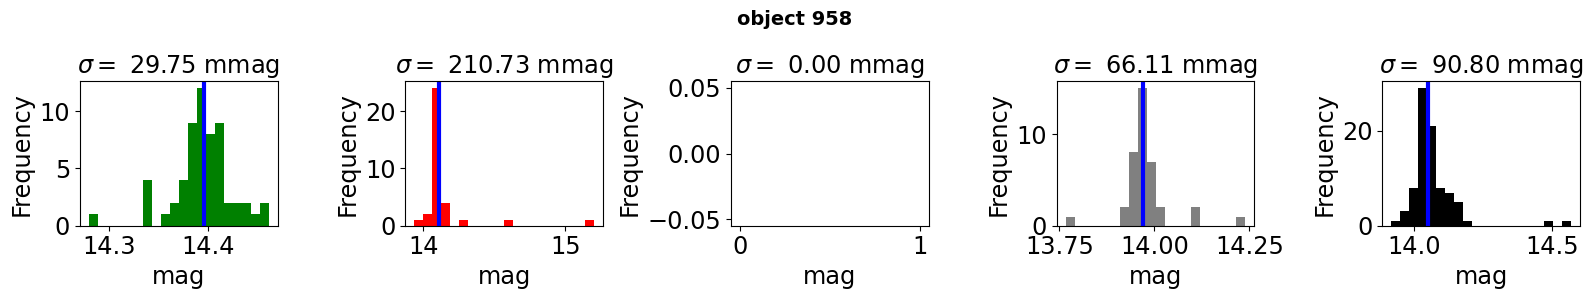

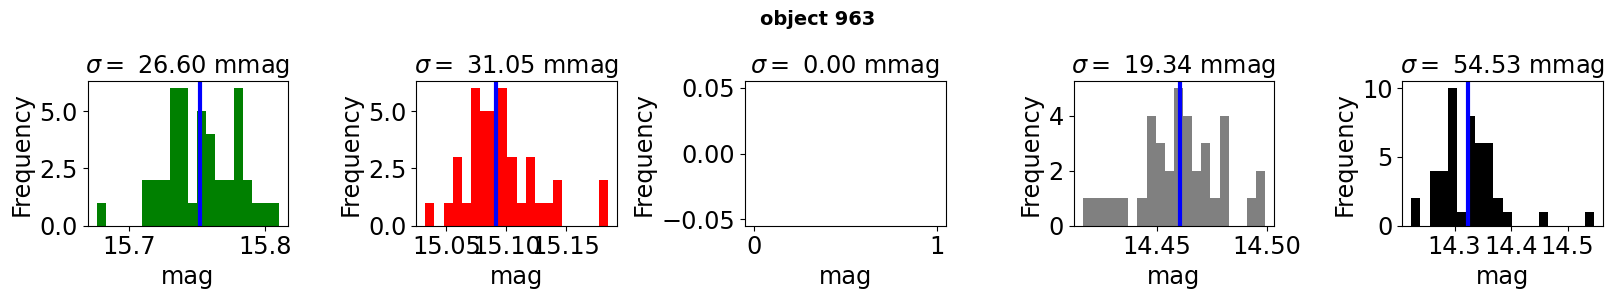

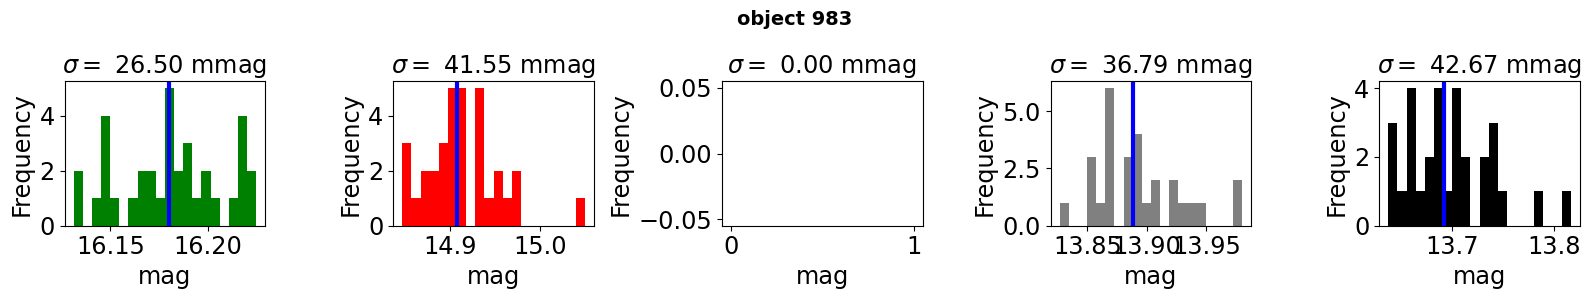

In [26]:
df_col_psf = pd.DataFrame(columns=["obj","g","r","i","z","y","sg","sr","si","sz","sy"])
for index in range(N):
    the_df = all_df[index]
    obj=selected_objectnum[index]
    
    plothistogram_valperband(the_df,ctag="psfMag")

    (medg,medr,medi,medz,medy) = get_df_median(the_df,ctag="psfMag")
    (sigg,sigr,sigi,sigz,sigy) = get_df_sigma(the_df,ctag="psfMag")
    df_col_psf.loc[index]=[obj,medg,medr,medi,medz,medy,sigg,sigr,sigi,sigz,sigy]

In [27]:
df_col_psf["g_r"] = df_col_psf["g"]- df_col_psf["r"]
df_col_psf["z_y"] = df_col_psf["z"]- df_col_psf["y"]
df_col_psf["sig_g_r"] = df_col_psf.apply(lambda row: np.sqrt(row["sg"]**2+ row["sr"]**2),axis=1)
df_col_psf["sig_z_y"] = df_col_psf.apply(lambda row: np.sqrt(row["sz"]**2+ row["sy"]**2),axis=1)

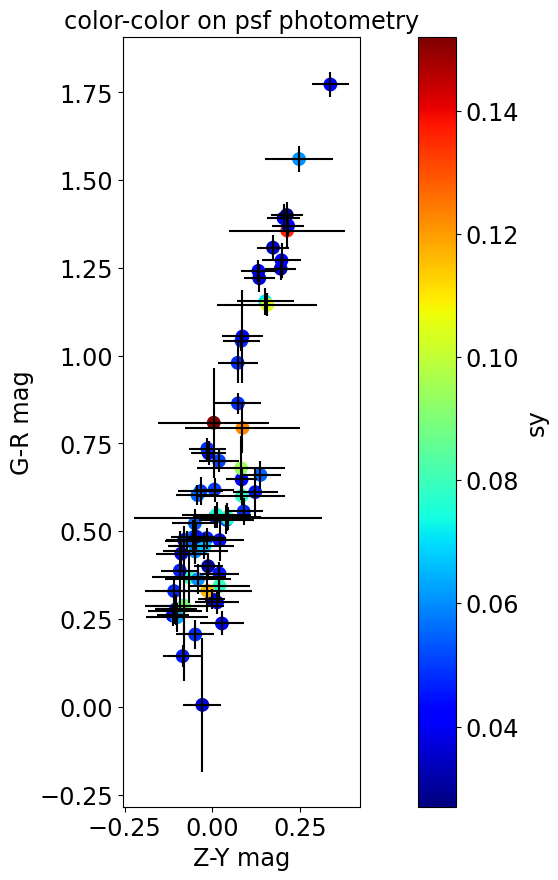

In [29]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.errorbar(df_col_psf["z_y"],df_col_psf["g_r"],xerr=df_col_psf["sig_z_y"] , yerr=df_col_psf["sig_g_r"], fmt=".",color='k',ecolor='k',markersize=1) 
df_col_psf.plot.scatter(x="z_y", y="g_r",marker= "o", s=80,c="sy",cmap="jet",ax=ax,colorbar=True)
ax.set_xlabel("Z-Y mag")
ax.set_ylabel("G-R mag")
ax.set_title("color-color on psf photometry")
ax.set_aspect("equal")
#ax.grid()
plt.show()

In [33]:
df_obj_colors = pd.merge(left=df_col_psf,right=df_col_ap,on="obj",suffixes=("_psf","_ap"))

In [34]:
df_obj_colors.to_csv("isolated_objects_magandcolors_psfap_good.csv")